# Laser Detection Algorithm
Run the laser detection algorithm.
Use this script for debugging and running on a small scale.

In [1774]:
import astropy.io.fits as fits
import matplotlib.pylab as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.interpolate import splev, splrep
import math
from mpmath import mp
import os
import os.path 
import random
from random import seed
from random import choice

## Necessary Functions
First two functions cpied from Anna Zuckerman's Github repository: https://github.com/annazuckerman/specmatch-emp-apf

In [1775]:
mp.dps=100
exp_array = np.frompyfunc(mp.exp, 1, 1)

# function to insert simulated gaussians
def insert_gaussian(spectrum, gaussian_params, midpoint, numpoints):
    height = gaussian_params[0]
    position = gaussian_params[1] #position within segment, not index in spectrum
    FWHM = gaussian_params[2]
    offset = gaussian_params[3]
    x = np.linspace(0,numpoints-1,numpoints) # numpoints must be even
    width = FWHM/(2*np.sqrt(2*np.log(2)))    
    gauss = gaussian(x,height,position,width,offset)
    new_spect = spectrum.copy()
    new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] = new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] + gauss
    return new_spect
    
def gaussian(x,a,b,c,d): # a = height, b = position of peak, c = width, x = numpy array of x values
    f = a*exp_array((-(x-b)**2)/(2*c)**2) + d
    return f 

def chi(model, data):
    '''given two arrays of the same length, calculate chi-squared'''
    return np.sum((data - model) ** 2)

## Set parameters

In [1776]:
plot = True  # plt.show()
save_figs = False  # save figures into folders

inject_signals = True  # inject signals into data
random_injections = True  # randomly inject signals into data
num_random_injections = 100  # number of injected signals
allow_overlap = False  # whether or not to allow injected signals to overlap

# for establishing threshold: how many SDs above median is the cutoff
use_local_median = True   # when calculating median of spectra, use 3000 pixels to the left and right of the index instead of the entire spectrum
SDs_above_median = 3   # number of SDs above the median the signal has to be in order to be detected

threshold_testing = True   # visualize which heights and widths go detected

only_test_certain_range = False  # whether or not to trucnate the spectra or run the algorithm on its entirety 
min_index = 0  # if truncating, which index to start at
max_index = 1000  # if truncating, which index to end at


# stars that have signals that exceed 3 SD above the local medians
which_stars = [9, 14, 17, 20, 22, 23, 26, 28, 30, 32, 35, 36, 37, 38,
 40, 41, 43, 44, 45, 48, 50, 53, 54, 57, 61, 62, 63, 64]

# stars that have signals that exceed 5 SD above the global median
which_stars = [35,   36,   45,   50,   53,   54,   57,   62,   69,
  75,   79,   80,   99,  102,  104,  112,  115,  117,
 122,  123,  126,  129,  132,  135,  163,  167,  177,
 195,  208,  213,  215,  220,  223,  241,  251,  256,
 283,  285,  293,  294,  295,  306,  308,  314,  321,
 347,  350,  383,  393,  425,  439,  445,  463,  497,
 535,  570,  619,  621,  626,  642,  646,  653,  656,
 663,  678,  682,  716,  723,  766,  771,  824,  852,
 876,  884,  886,  887,  892,  904,  905,  906,  907,
 908,  910,  911,  912,  936,  937,  968,  969,  970,
 993,  994, 1016, 1017, 1049, 1050, 1052, 1053, 1090]

which_star = int(which_stars[1])  # which star in the list of all stars to look at

which_star = 35

## Read in Reduced Data from Anna Zuckerman's repo

In [1777]:
plt.rcParams["figure.figsize"] = (18,12)
plt.rcParams.update({'font.size': 20})

directory = '/mnt_home/azuckerman/APF_spectra/NDR_corrected_wl_scale'

# every file in Anna's NDR_corrected_wl_scale folder
list_of_files = []
for filename in os.listdir(directory):
    if filename.endswith(".fits"): 
        file_path = os.path.join(directory, filename)
        list_of_files = np.append(list_of_files, file_path)
        
# Choose one star from list of all stars
APF_flux_path = list_of_files[which_star]

file = fits.open(APF_flux_path)
flux = file[0].data
wl = file[1].data

header = file[0].header
star = header['OBJECT']

print('File path: ' + APF_flux_path)
print('Star: ' + star)

if only_test_certain_range == True:
    # truncate wavelenght and flux for testing purposes
    wl = wl[min_index:max_index]
    flux = flux[min_index:max_index]

File path: /mnt_home/azuckerman/APF_spectra/NDR_corrected_wl_scale/ranr.296.NDR.fits
Star: HIP65378


In [1778]:
if threshold_testing == True:
    # injected signals information
    heights = []
    widths = []
    indicies = []
    wavelengths = []
    
    # recovered signals information
    recovered_widths = []
    recovered_heights = []
    recovered_indicies = []
    recovered_wavelengths = []
    
    # uninjected detected signals information
    
    detected_widths = []
    detected_heights = []
    detected_indicies = []
    detected_wavelengths = []

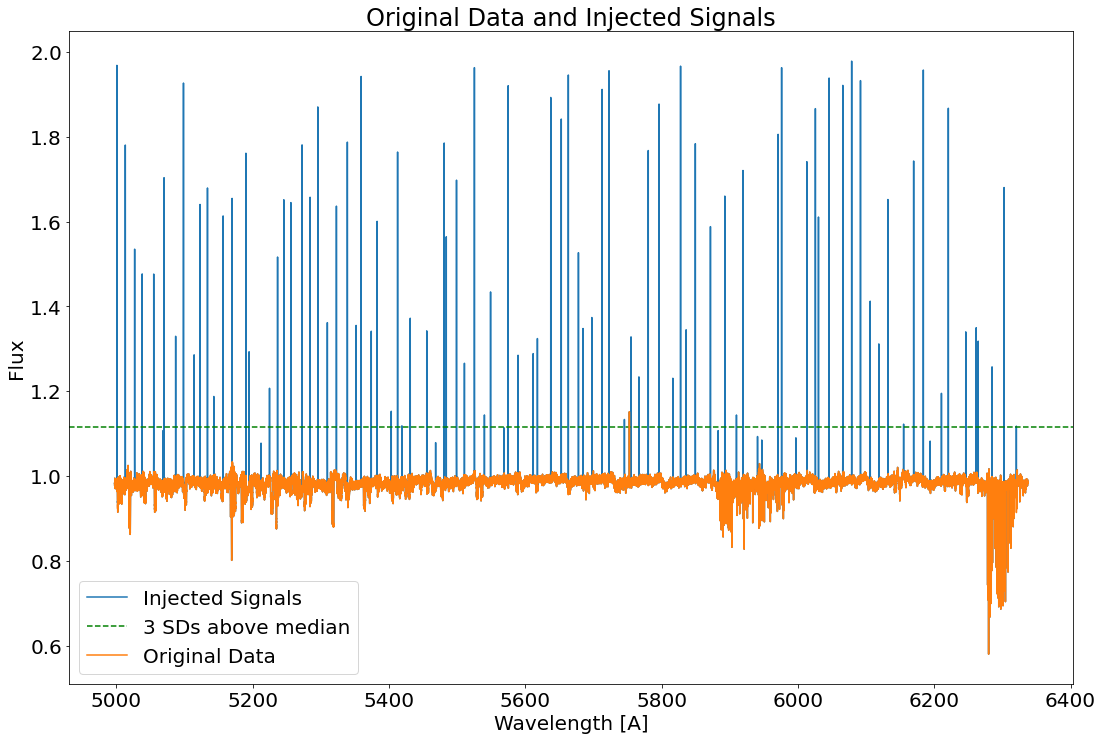

median is 0.9853206156880545
SD is 0.04334099415909924


In [1779]:
spect = flux

if inject_signals == True:
    if random_injections == True:
        if allow_overlap == True:
            # inject random signals allowing overlap
            for i in np.arange(num_random_injections):
                random_val = np.random.choice(flux[100:-100], size = 1)
                location = flux.tolist().index(random_val)
                height = choice(np.arange(0.1, 0.5, 0.1).tolist())
                width = choice(np.arange(1, 5, 0.1).tolist())

                if width > 8:
                    spect = insert_gaussian(spect,[height, 15, width, 0], location, 30)
                    # position should be half of num_points
                    # 
                elif width > 5:
                    spect = insert_gaussian(spect,[height, 10, width, 0], location, 20)
                elif width > 2:
                    spect = insert_gaussian(spect,[height, 5, width, 0], location, 10)
                else:
                    spect = insert_gaussian(spect,[height, 5, width, 0], location, 10)
                heights = np.append(heights, height)
                
                
                
#                 # find the width of the gaussian in pixels
#                 left = wl[location] - width
#                 absolute_difference_function = lambda list_value : abs(list_value - left)
#                 w = min(wl.tolist(), key = absolute_difference_function)
#                 left_index = wl.tolist().index(w)


#                 right = wl[location] + width
#                 absolute_difference_function = lambda list_value : abs(list_value - right)
#                 w = min(wl.tolist(), key = absolute_difference_function)
#                 right_index = wl.tolist().index(w)

#                 pixel_width = right_index - left_index
#                 widths = np.append(widths, pixel_width)

    
    
                widths = np.append(widths, width)
                indicies = np.append(indicies, location)
                wavelengths = np.append(wavelengths, wl[location])
        else:
            # inject random signals with no overlap
            interval = len(spect) / num_random_injections
            for i in np.arange(interval, len(spect), interval):
                random_val = np.random.choice(flux[int(i - interval + 30):int(i - 30)])
                location = flux.tolist().index(random_val)
                height = choice(np.arange(0.1, 1, 0.01).tolist())
                width = choice(np.arange(1, 5, 0.01).tolist())            

                if width > 8:
                    position = 15
                    numpoints = 30
                elif width > 5:
                    position = 10
                    numpoints = 20
                else:
                    position = 5
                    numpoints = 10
                
                spect = insert_gaussian(spect,[height, position, width, 0], location, numpoints)
                heights = np.append(heights, height)
                
                
#                 # find the width of the gaussian in pixels    
#                 w = width/(2*np.sqrt(2*np.log(2))) 
#                 offset = 0
#                 x = np.linspace(0,numpoints-1,numpoints)
#                 gauss = gaussian(x,height,position,w,offset)

#                 peak = max(gaus)
#                 half_max = peak - height / 2

#                 peak_index = gaus.tolist().index(peak)
#                 temp_left_bound = peak_index
#                 temp_right_bound = peak_index


#                 while gaus[temp_left_bound] > half_max and temp_left_bound > 0:
#                     temp_left_bound -=1

#                 while gaus[temp_right_bound] > half_max and temp_right_bound < len(gaus) - 1:
#                     temp_right_bound += 1

#                 pixel_width = temp_right_bound - temp_left_bound

#                 print('pixel width is ' + str(pixel_width))

#                 widths = np.append(widths, pixel_width)
    
    
                widths = np.append(widths, width)
                indicies = np.append(indicies, location)
                wavelengths = np.append(wavelengths, wl[location])
    else:
        spect = insert_gaussian(spect,[0.5, 5, 6, 0], 560, 10)
        



if (plot == True) or (save_figs == True):
    fig = plt.figure()
    if inject_signals == True: 
        plt.plot(wl, spect, label = 'Injected Signals')
        plt.title('Original Data and Injected Signals')
        global_median = np.median(spect)
        global_SD = np.std(spect)
        plt.axhline(SDs_above_median * global_SD + global_median, label= str(SDs_above_median) + ' SDs above median', color='green', linestyle='--')
    else:
        plt.title('Original Data')
        global_median = np.median(flux)
        global_SD = np.std(flux)
        plt.axhline(SDs_above_median * global_SD + global_median, label= str(SDs_above_median) + ' SDs above median', color='green', linestyle='--')  
    plt.plot(wl, flux, label = 'Original Data')
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
#     plt.xlim(wl[200], wl[400])
#     plt.xlim(wl[100], wl[400])
    plt.legend()
if plot == True:
    plt.show()
if save_figs == True:
    path = '/mnt_home/zoek/code/APF-BL-DAP/Zoe/LaserDetectionResults/' + star
    if not (os.path.isdir(path)):
        os.mkdir(path)
    path = path + '/order' + str(order)
    if not (os.path.isdir(path)):
        os.mkdir(path)
    fig.savefig(path + '/' + star + '_order' + str(order) + '_injected_signals.png')
    
global_median = np.median(spect)
global_SD = np.std(spect)
print('median is ' + str(global_median))
print('SD is ' + str(global_SD))

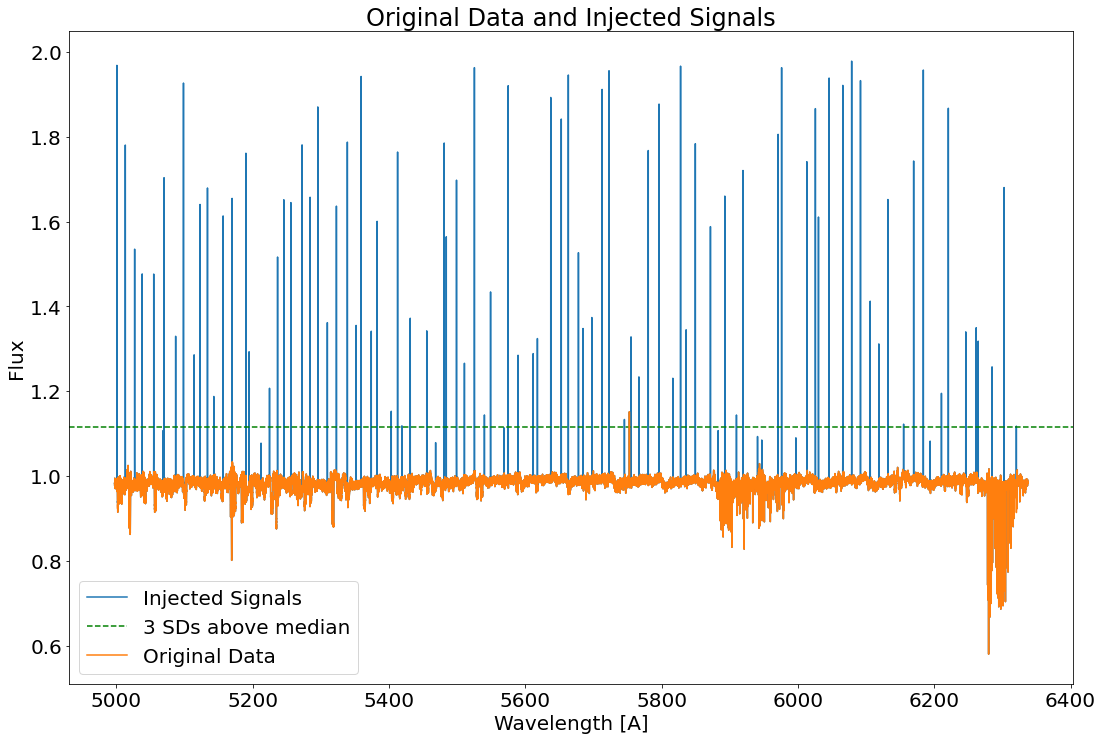

In [1780]:
if (plot == True) or (save_figs == True):
    fig = plt.figure()
    if inject_signals == True: 
        plt.plot(wl, spect, label = 'Injected Signals')
        plt.title('Original Data and Injected Signals')
        global_median = np.median(spect)
        global_SD = np.std(spect)
        plt.axhline(SDs_above_median * global_SD + global_median, label= str(SDs_above_median) + ' SDs above median', color='green', linestyle='--')
    else:
        plt.title('Original Data')
        global_median = np.median(flux)
        global_SD = np.std(flux)
        plt.axhline(SDs_above_median * global_SD + global_median, label= str(SDs_above_median) + ' SDs above median', color='green', linestyle='--')  
    plt.plot(wl, flux, label = 'Original Data')
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
#     plt.xlim(wl[262], wl[272])
#     plt.xlim(wl[100], wl[400])
    plt.legend()
if plot == True:
    plt.show()
if save_figs == True:
    path = '/mnt_home/zoek/code/APF-BL-DAP/Zoe/LaserDetectionResults/' + star
    if not (os.path.isdir(path)):
        os.mkdir(path)
    path = path + '/order' + str(order)
    if not (os.path.isdir(path)):
        os.mkdir(path)
    fig.savefig(path + '/' + star + '_order' + str(order) + '_injected_signals.png')

In [1781]:
# median = np.median(spect)
# SD = np.std(spect)

idxs1 = [] # indicies that are 3 SDs above the median flux value
idxs2 = [] # indicies in idxs1 that are local maximums
idxs3 = [] # indicies in idxs2 that are greater than 5 pixels in width
idxs4 = [] # indicies in idxs3 that are gaussian-shaped

for idx in np.arange(len(spect)):
    # first test: create an array of all indices that are above 3 SDs above local median
    if idx < 3000:
        median = np.median(spect[100 : idx + 3000])
        SD = np.std(spect[100 : idx + 3000])
    elif idx > len(spect) - 3000:
        median = np.median(spect[idx - 3000 : len(spect) - 100])
        SD = np.std(spect[idx - 3000 : len(spect) - 100])
    else:
        median = np.median(spect[idx - 3000: idx + 3000])
        SD = np.std(spect[idx - 3000: idx + 3000])
        
    if spect[idx] > SDs_above_median * SD + median:
        idxs1 = idxs1 + [idx]

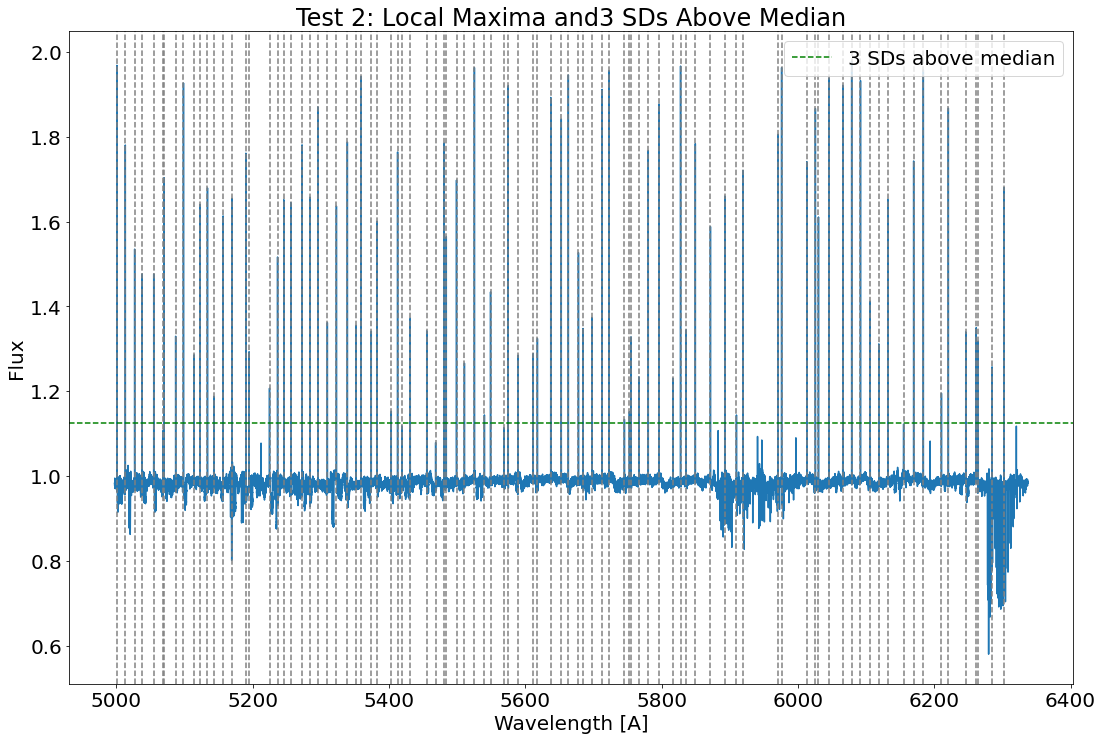

In [1782]:
for idx in idxs1:            
    # second test: keep the index if it is a local maximum  
    if spect[idx] >= spect[idx-1] and spect[idx] >= spect[idx+1]: 
        if spect[idx] >= spect[idx-2] and spect[idx] >= spect[idx+2]:
            idxs2 = idxs2 + [idx]
if (plot == True or save_figs == True) & (idxs2 != []):
    fig = plt.figure()
    plt.plot(wl, spect)
    plt.axhline(SDs_above_median * SD + median, label= str(SDs_above_median) + ' SDs above median', color='green', linestyle='--')
    for ind in idxs2:
        plt.axvline(x=wl[ind], color='gray', linestyle='--')
#         plt.axvline(x=wl[ind], label= 'Detected Signal at ' + str(round(wl[ind], 2)) + ' A', color='gray', linestyle='--')    
    plt.title('Test 2: Local Maxima and' + str(SDs_above_median) + ' SDs Above Median')
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.legend() 
    if plot == True:
        plt.show()
    if save_figs == True:
        path = '/mnt_home/zoek/code/APF-BL-DAP/Zoe/LaserDetectionResults/' + star
        if not (os.path.isdir(path)):
            os.mkdir(path)
        path = path + '/order' + str(order)
        if not (os.path.isdir(path)):
            os.mkdir(path)
        fig.savefig(path + '/' + star + '_order' + str(order) + '_test2.png')

In [1783]:
# # measuring width of signal without gaussian fitting


# for idx in idxs2:
#     # third test: determine if the signal is greater than 5 pixels in width 
    
#     # METHOD 1 FOR DETERMINING EDGES OF SIGNAL: the left and rightmost points where
#     # the flux value falls under the established threshold 
    
    
    
#     # first test: create an array of all indices that are above 3 SDs above local median
#     if idx < 3000:
#         median = np.median(spect[100 : idx + 3000])
#         SD = np.std(spect[100 : idx + 3000])
#     elif idx > len(spect) - 3000:
#         median = np.median(spect[idx - 3000 : len(spect) - 100])
#         SD = np.std(spect[idx - 3000 : len(spect) - 100])
#     else:
#         median = np.median(spect[idx - 3000: idx + 3000])
#         SD = np.std(spect[idx - 3000: idx + 3000])
        
#     threshold = SDs_above_median * SD + median 
# #     print(threshold)
# #     threshold = 1
    
#     temp_ind = idx
#     left_bound = 0
#     while temp_ind > 0:
#         temp_ind -= 1
#         if spect[temp_ind] < threshold:
#             left_bound = temp_ind
#             break
#     temp_ind = idx
#     right_bound = len(spect) - 1
#     while temp_ind < len(spect) - 1:
#         temp_ind += 1
#         if spect[temp_ind] < threshold:
#             right_bound = temp_ind
#             break
            
 
# #     # METHOD 2 FOR DETERMINING EDGES OF SIGNAL: mark edge when flux reaches a local minimum
# #     temp_ind = idx
# #     left_bound = 0
# #     while temp_ind > 1:
# #         temp_ind -= 1
# #         if spect[temp_ind] < spect[temp_ind - 1] and spect[temp_ind] < spect[temp_ind + 1]:
# #             left_bound = temp_ind
# #             break
# #     temp_ind = idx
# #     right_bound = len(spect) - 1
# #     while temp_ind < len(spect) - 4:
# #         temp_ind += 1
# #         if (spect[temp_ind] < spect[temp_ind - 1]) and (spect[temp_ind] < spect[temp_ind + 1]):
# #             right_bound = temp_ind
# #             break
            
            
#     passed = False
#     if ((right_bound - left_bound) > 3):
#         passed = True
#         idxs3 = idxs3 + [idx]
#     if (plot == True or save_figs == True):
#         fig = plt.figure()
#         plt.plot(wl, spect, label = 'Detected Signal at ' + str(round(wl[idx], 2)) + ' A') 
#         if passed:
#             plt.title('Test 3: Width Greater than 3 Pixels - PASSED with width of ' + str(right_bound - left_bound))
#         else:
#             plt.title('Test 3: Width Greater than 3 Pixels - FAILED with width of ' + str(right_bound - left_bound))
#         plt.scatter(wl[left_bound], spect[left_bound], label = 'Left Bound', color = 'orange')
#         plt.scatter(wl[right_bound], spect[right_bound], label = 'Right Bound', color = 'orange')
#         plt.xlabel('Wavelength [A]')
#         plt.xlim(wl[left_bound - 1], wl[right_bound + 1])
# #         plt.hlines(median + SD, wl[left_bound - 1], wl[right_bound + 1], label = '1 SD above median')
#         for ind in np.arange(left_bound, right_bound):
#             plt.axvline(x=wl[ind], color='gray', linestyle='-', linewidth=0.2)
#         plt.annotate(s='1 pixel', xy=(wl[left_bound], min(spect)), xytext=(wl[left_bound + 1], min(spect)), arrowprops=dict(arrowstyle='<->'))
#         plt.ylabel('Flux')
#         plt.legend()
#     if plot == True:
#         plt.show()
#     if save_figs == True:
#         test3_path = path + '/test3'
#         if not (os.path.isdir(test3_path)):
#             os.mkdir(test3_path)
#         pos_path = test3_path + '/pass'
#         neg_path = test3_path + '/fail'
#         if not (os.path.isdir(pos_path) and os.path.isdir(neg_path)):
#             os.mkdir(pos_path)
#             os.mkdir(neg_path)
#         if passed:
#             fig.savefig(pos_path + '/test3' + '_' + str(round(wl[idx], 2)) + '.png')
#         else:
#             fig.savefig(neg_path + '/test3' + '_' + str(round(wl[idx], 2)) + '.png')


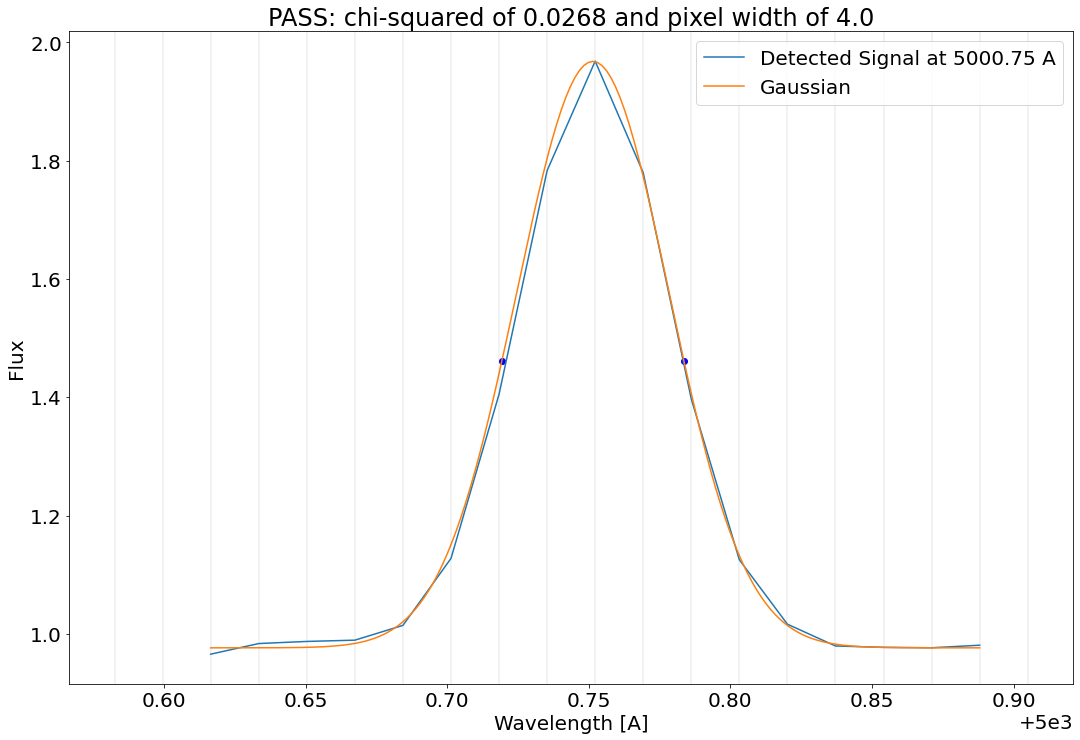

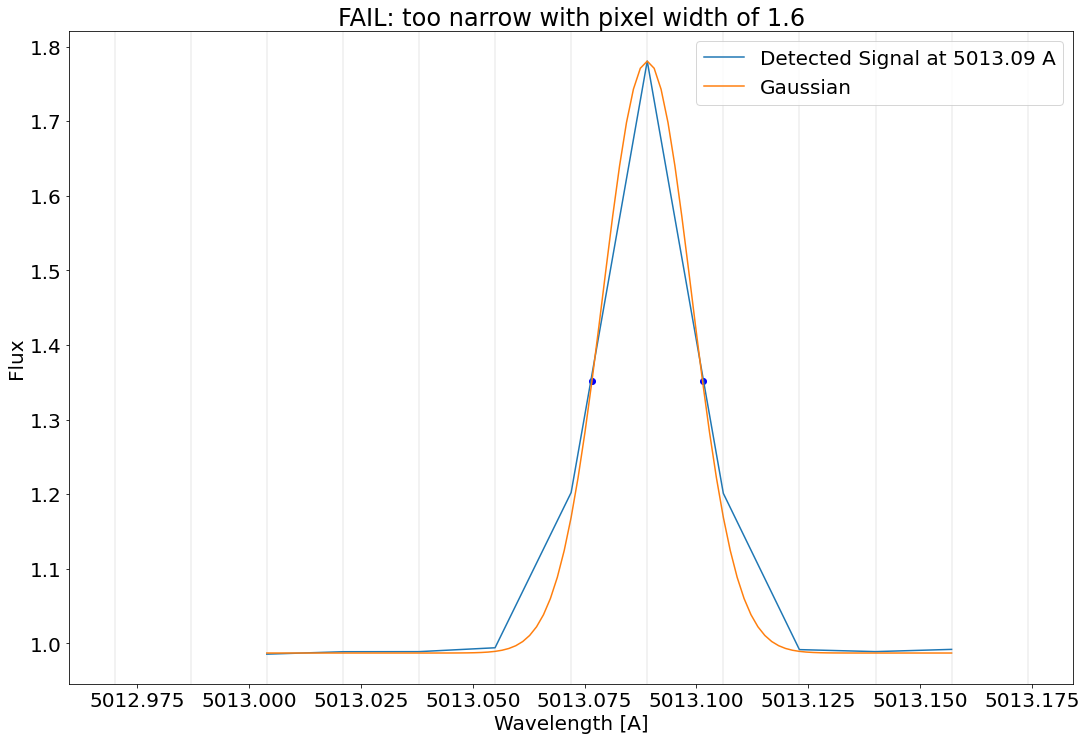

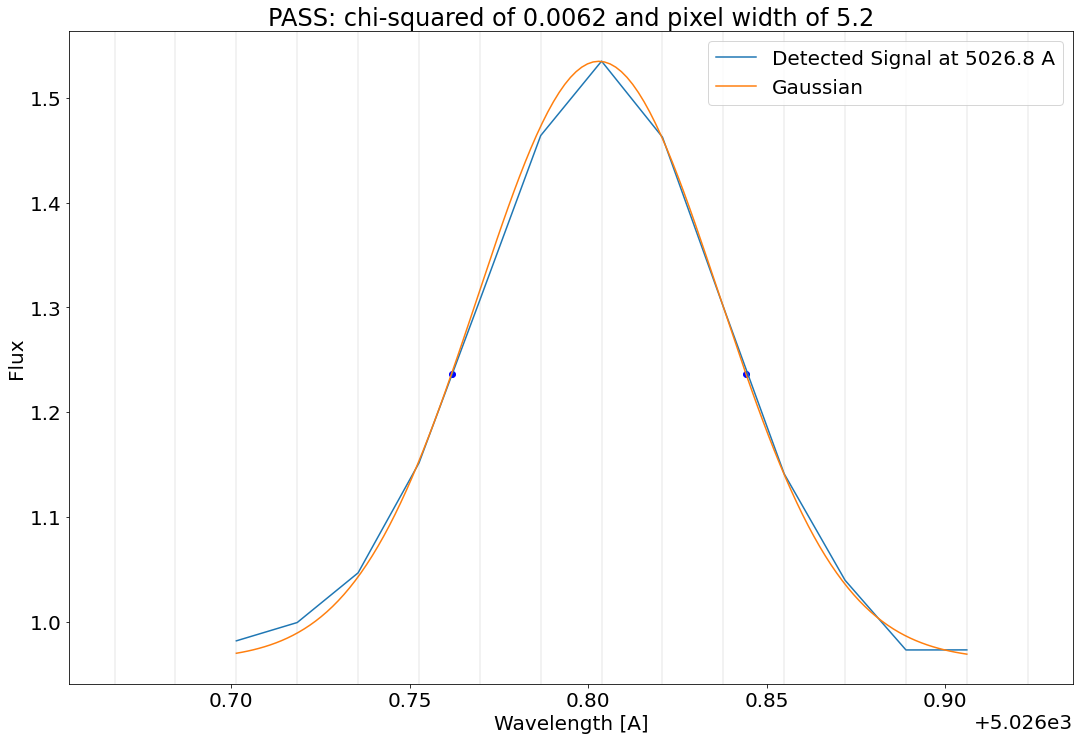

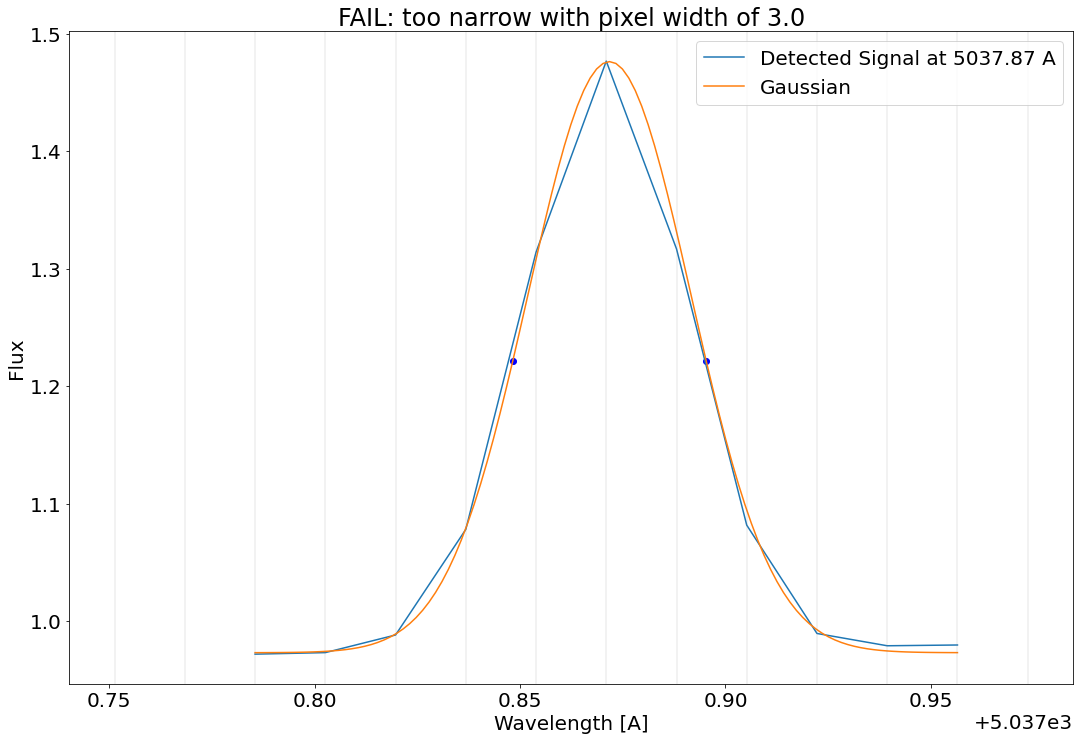

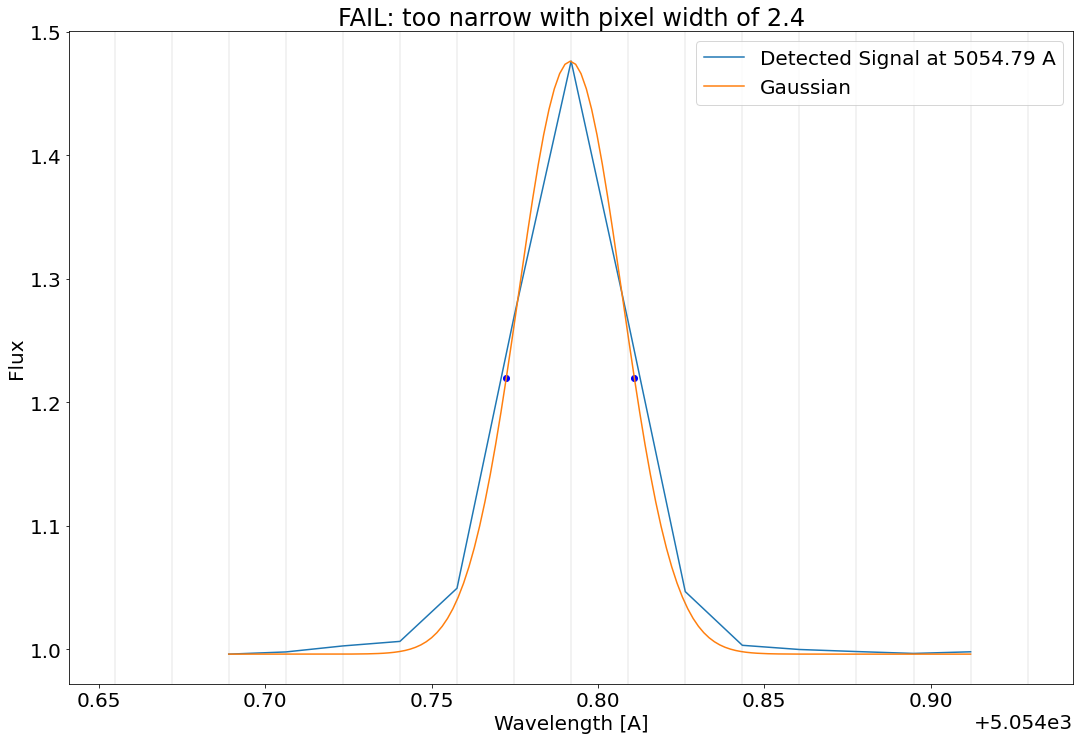

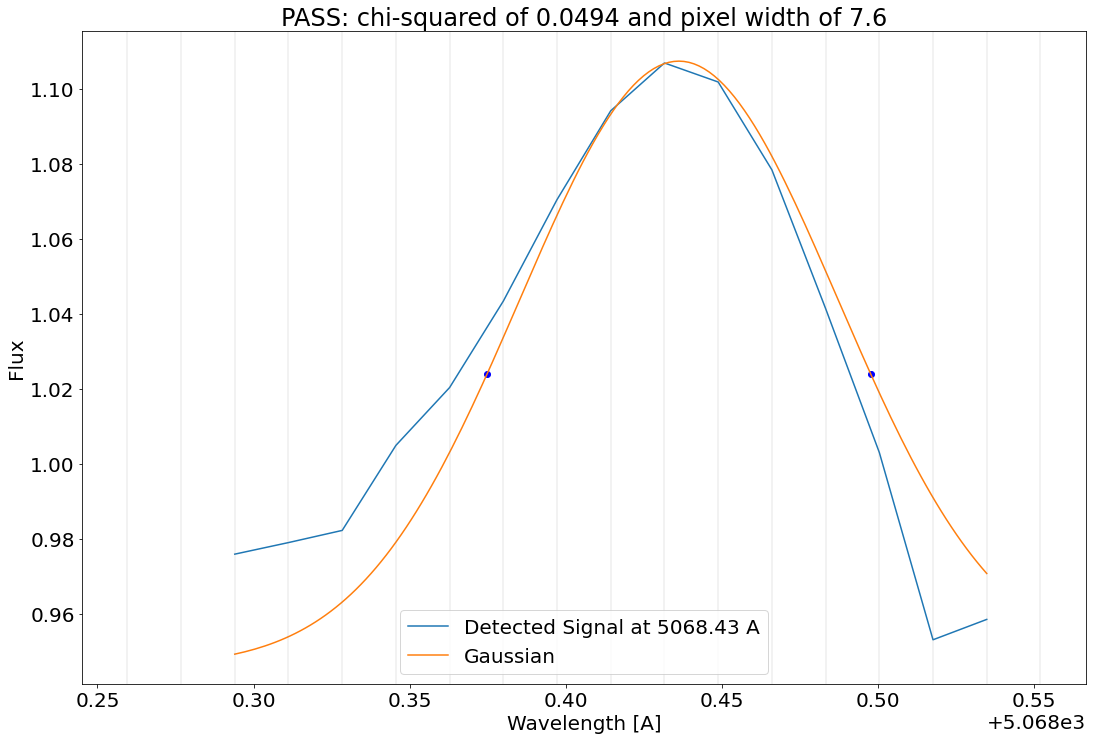

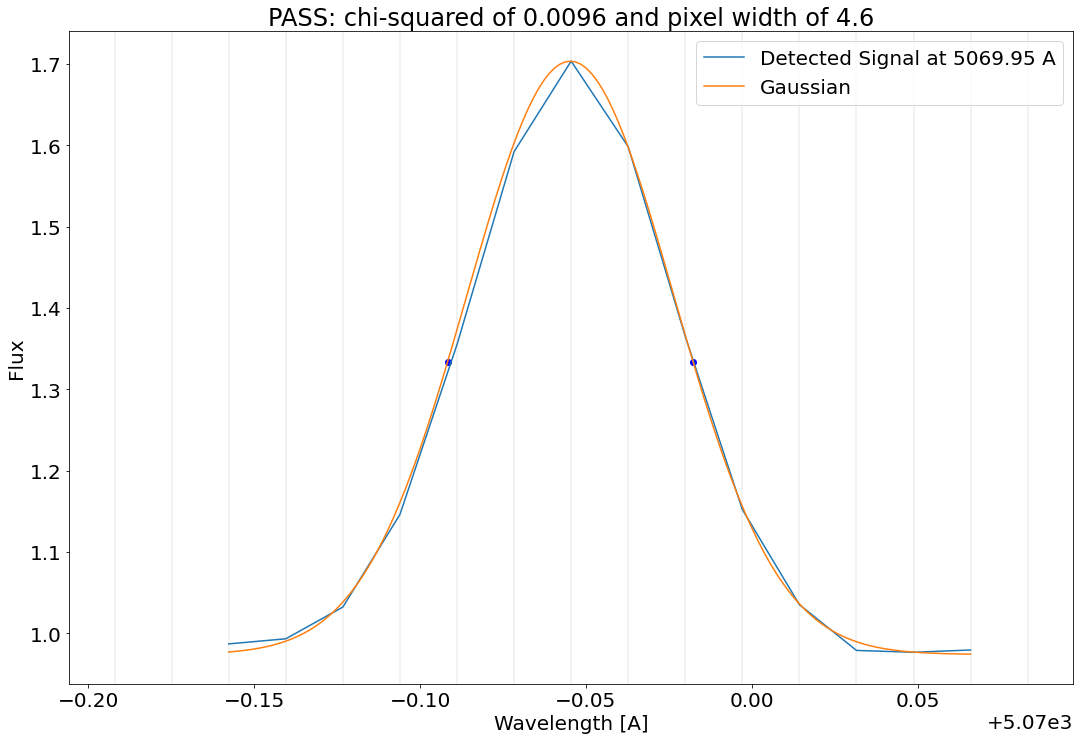

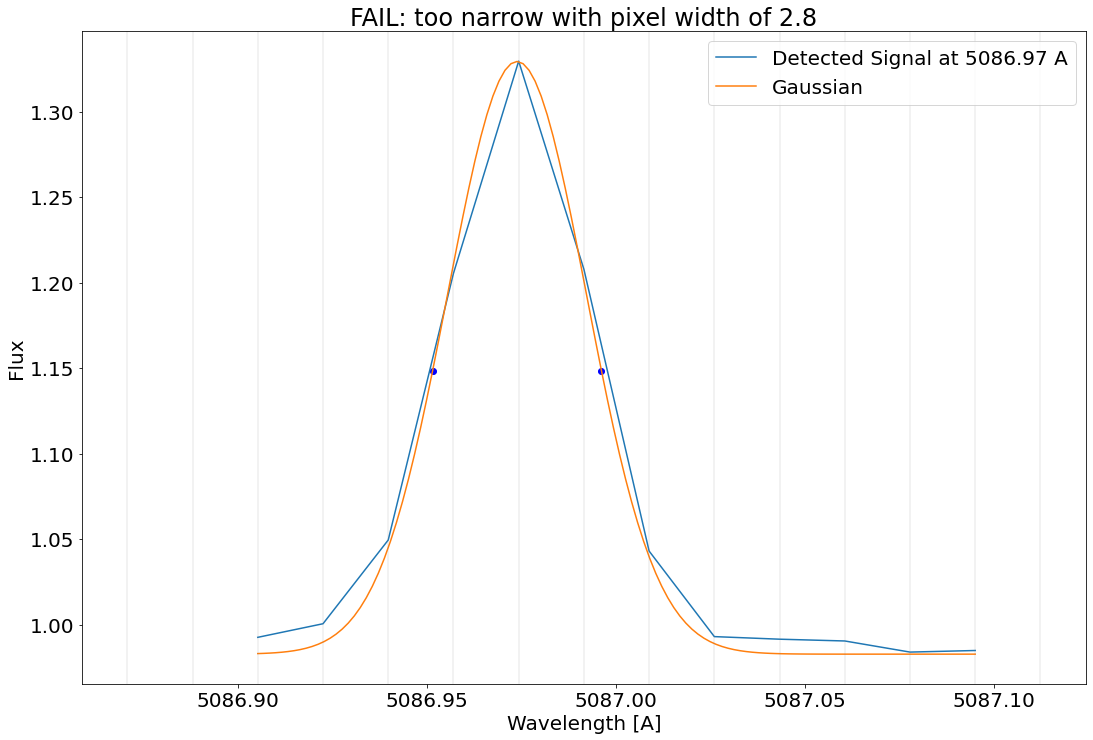

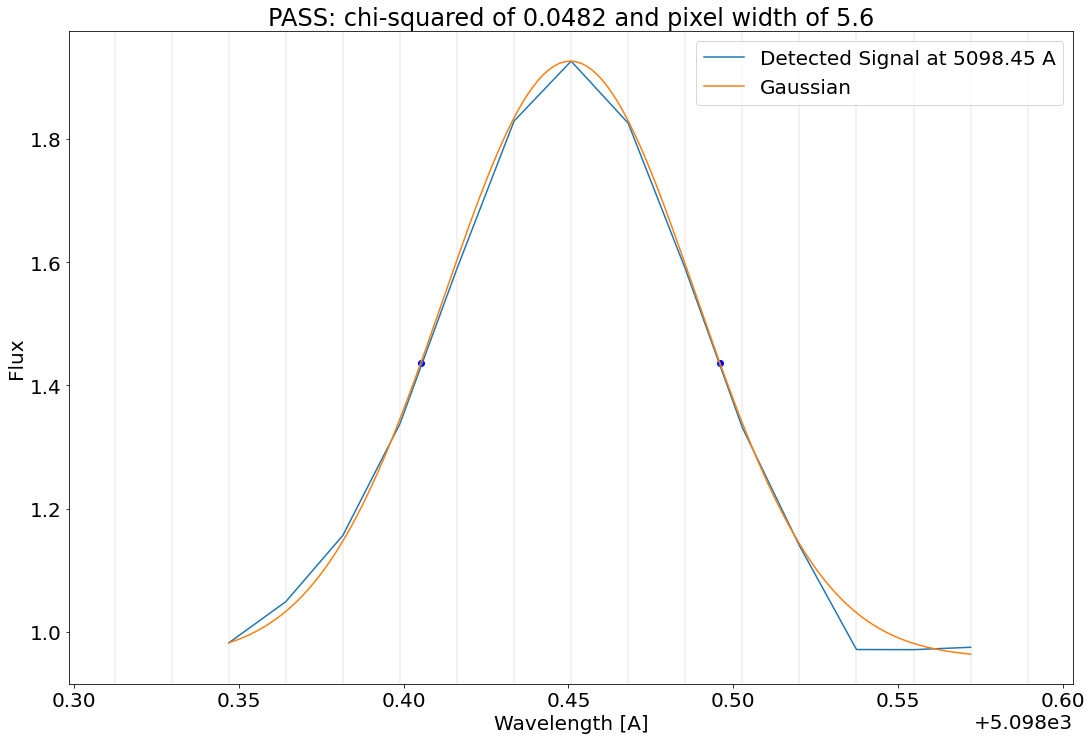

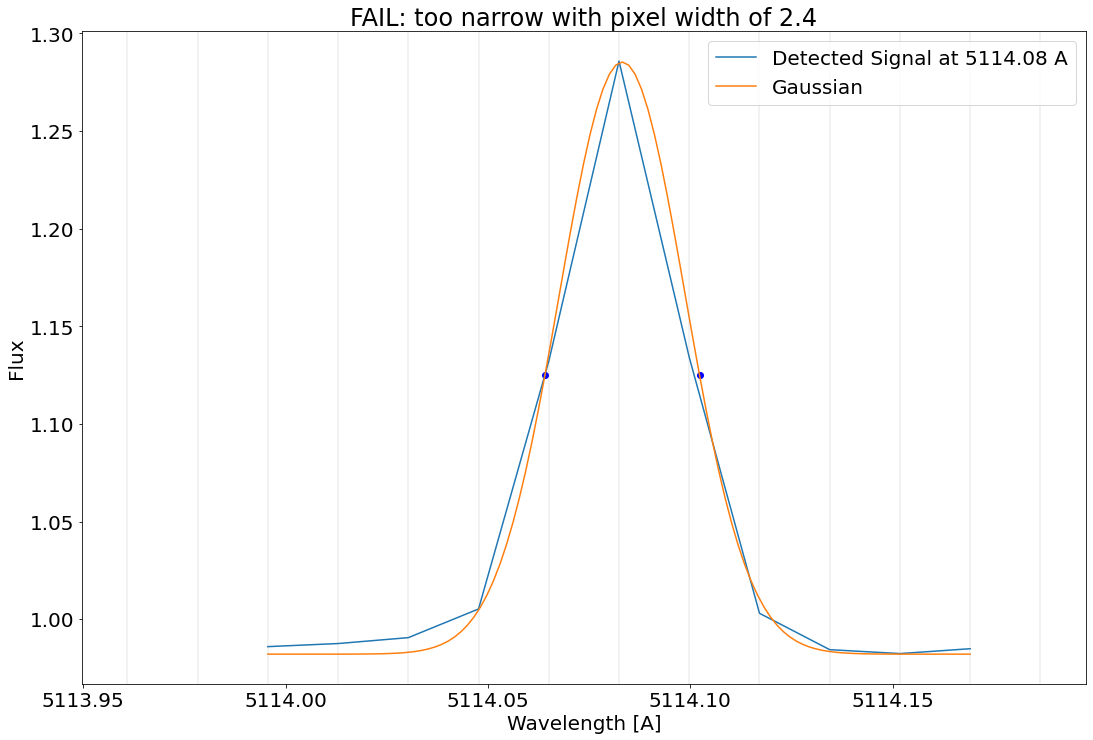

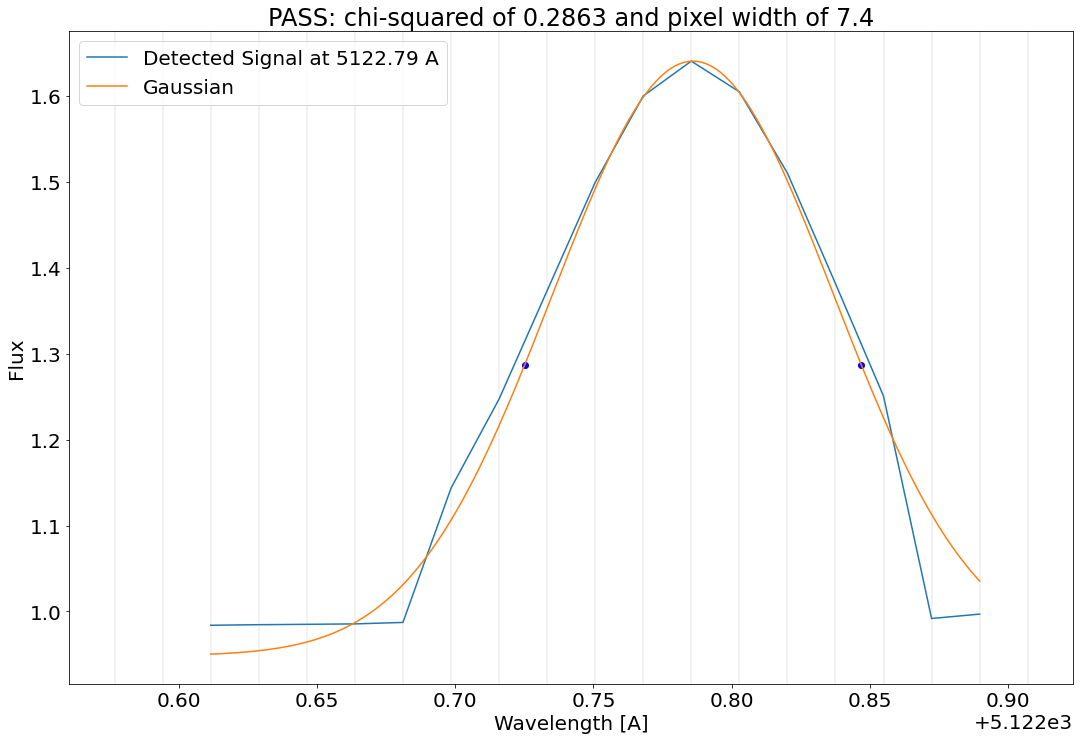

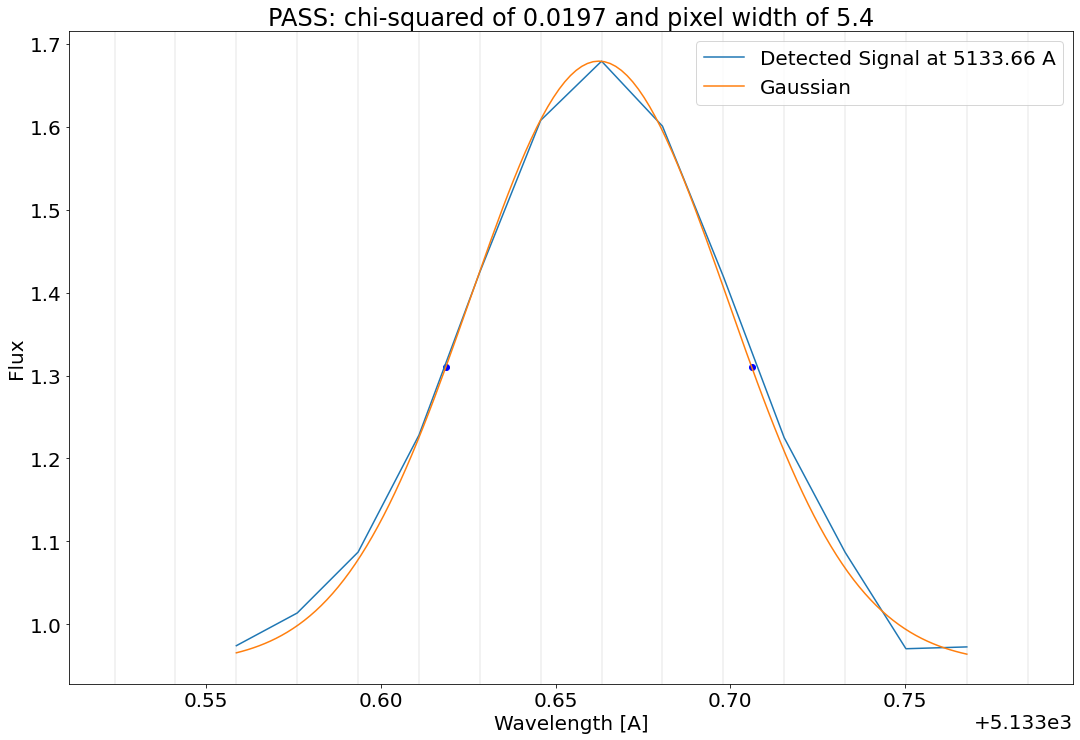

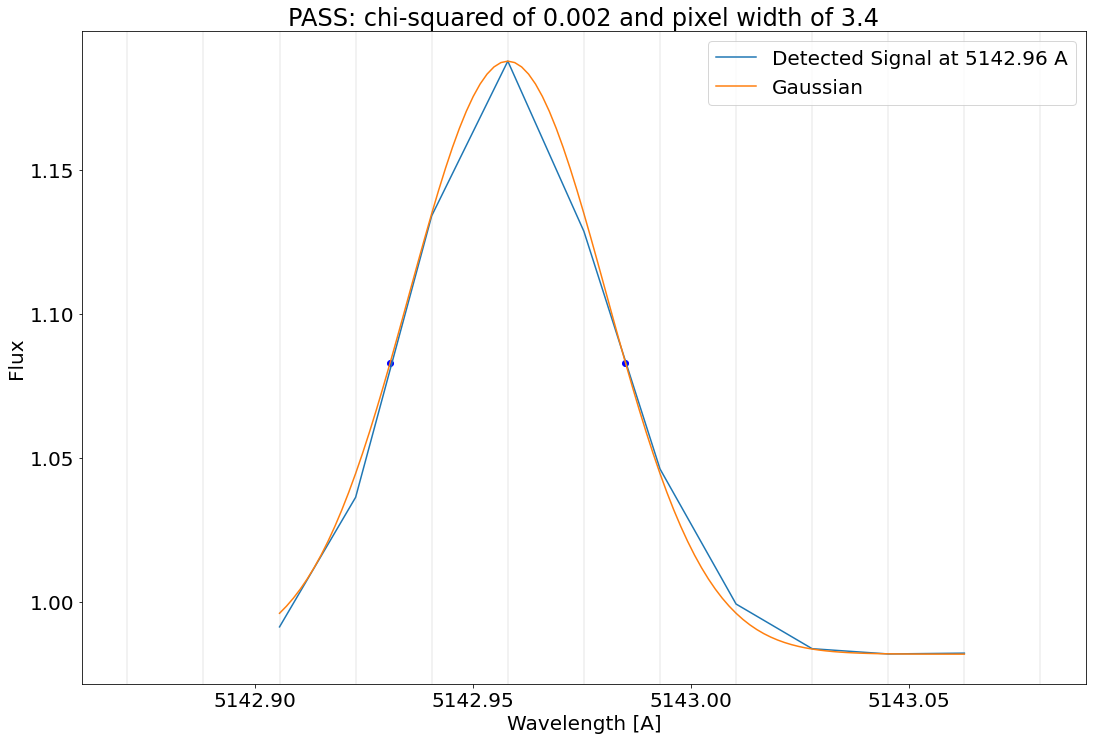

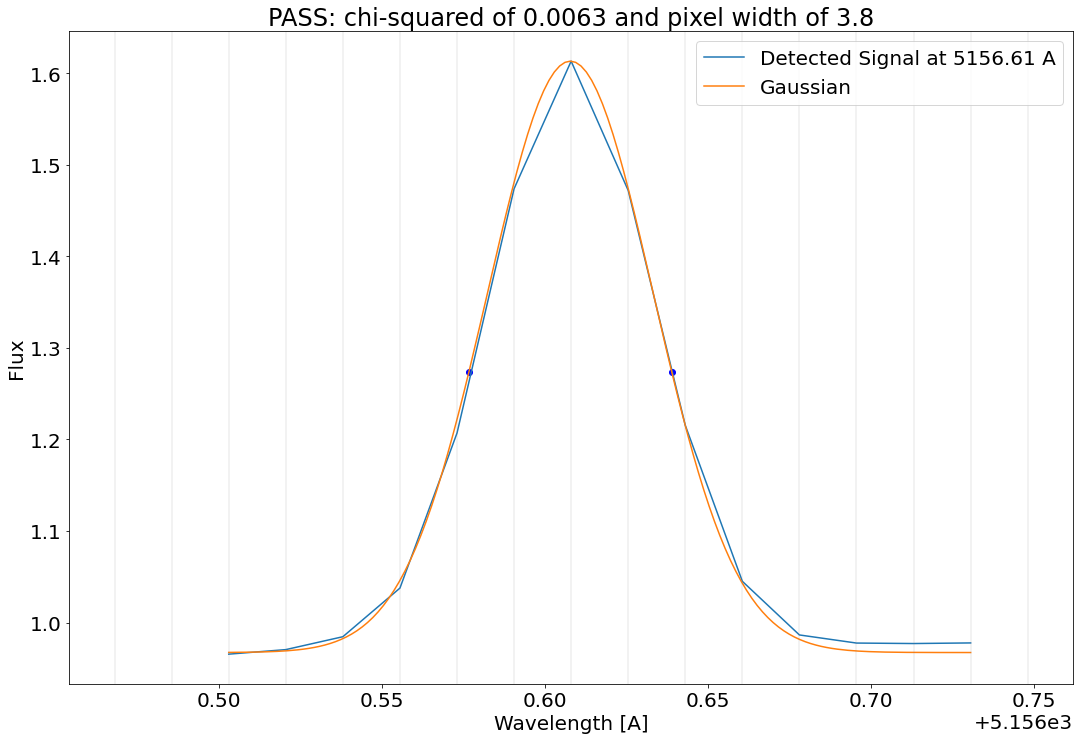

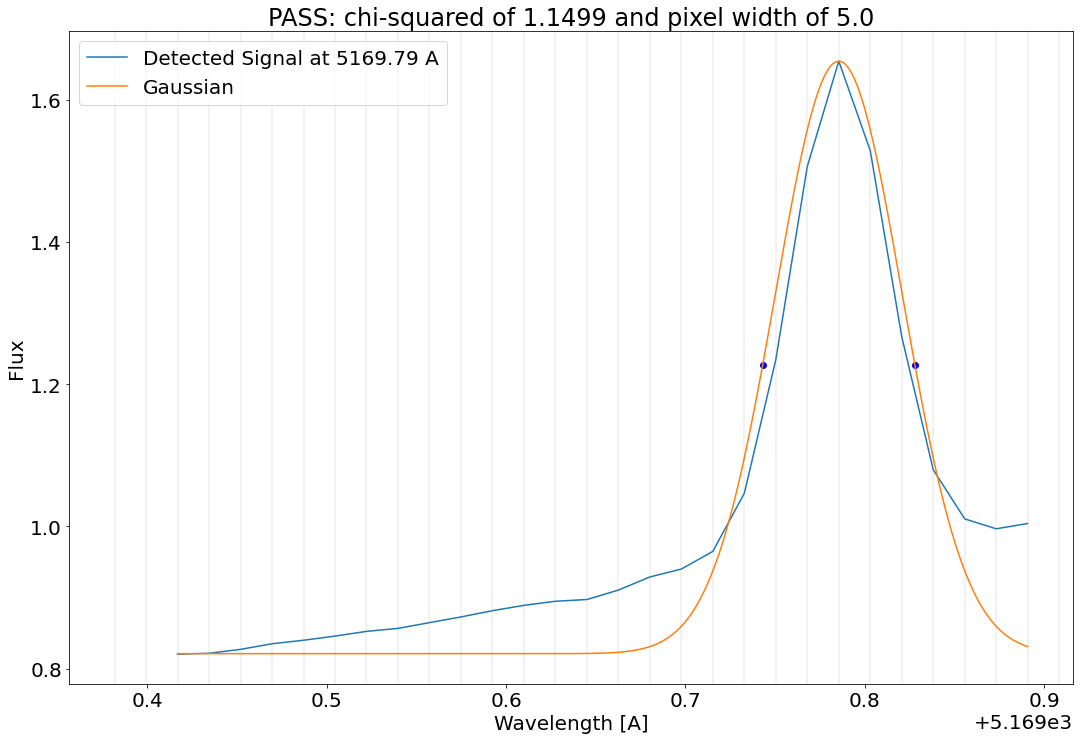

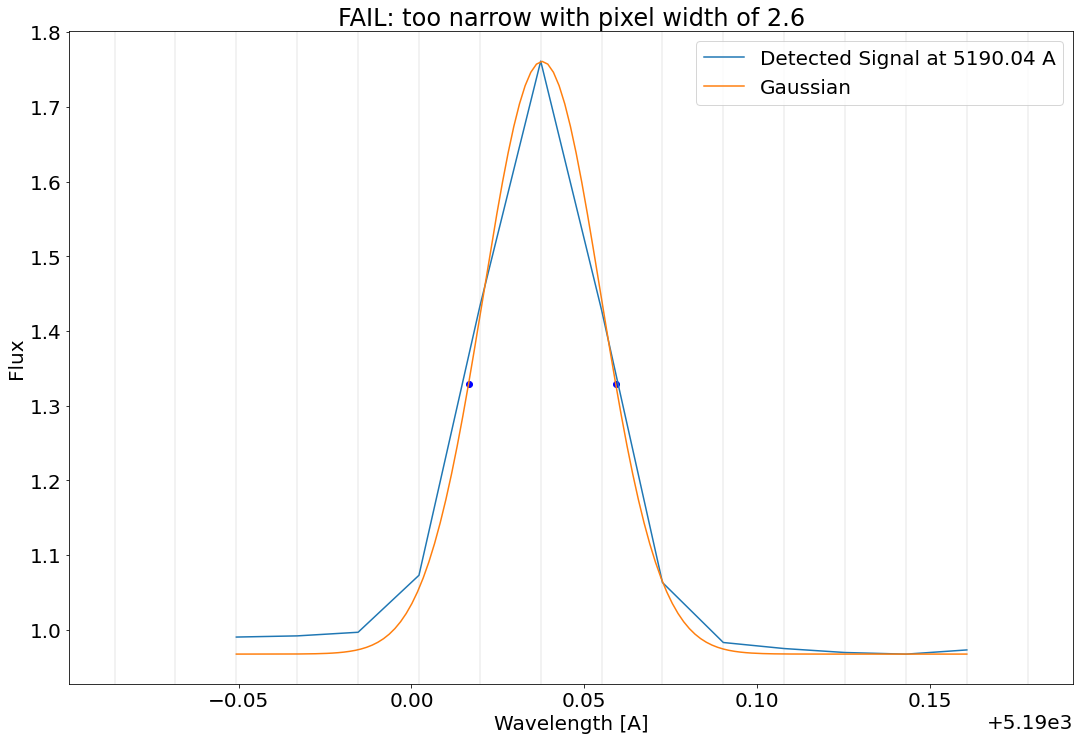

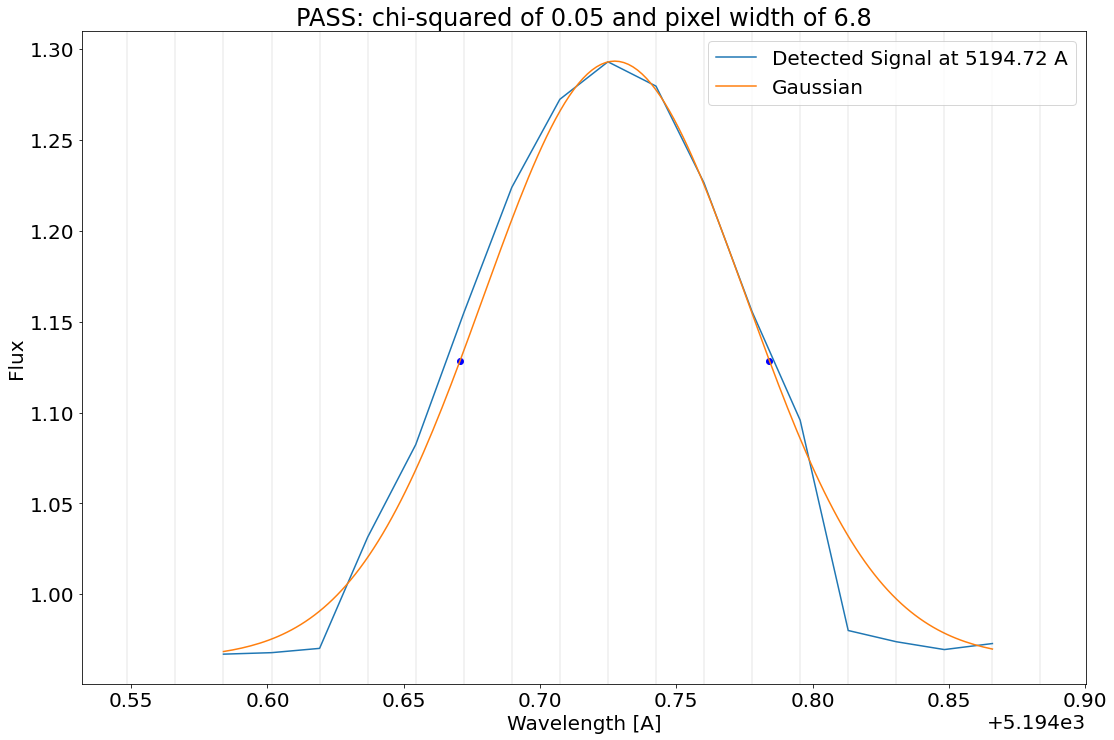

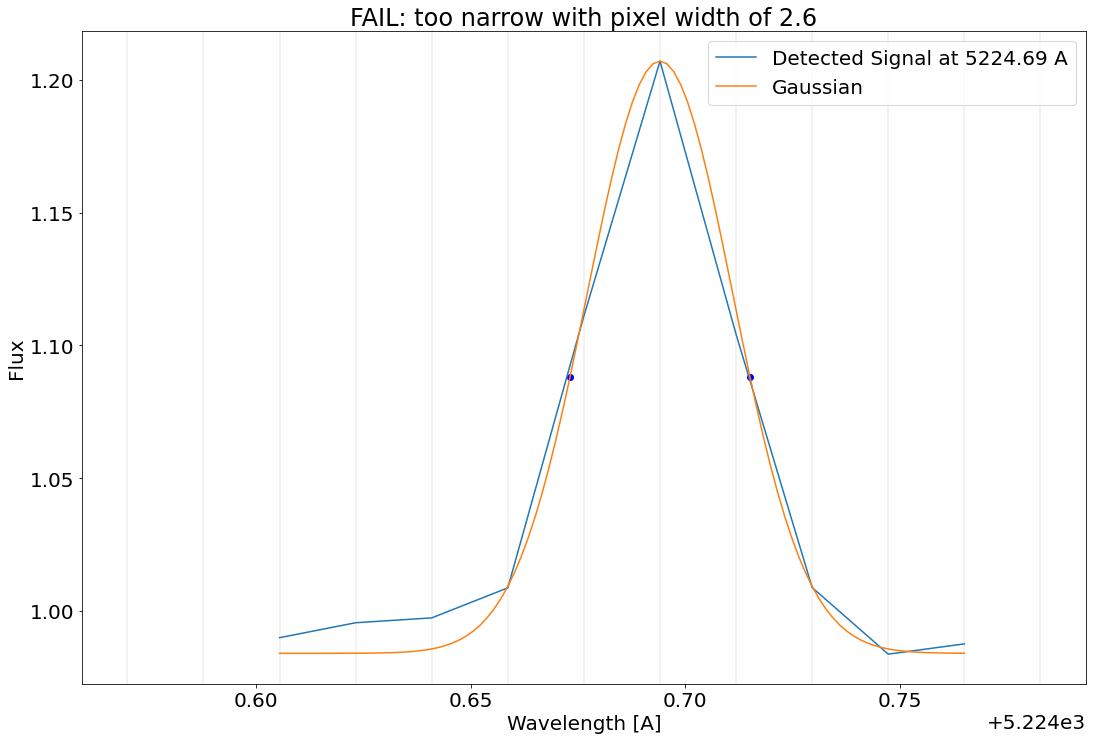

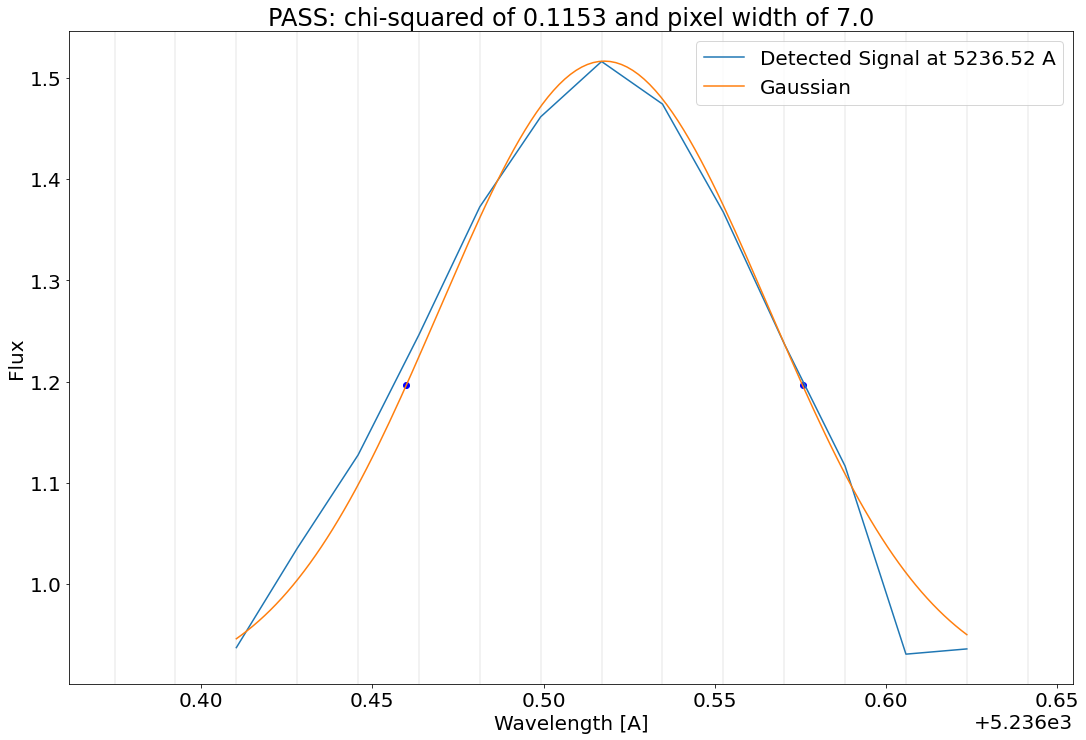

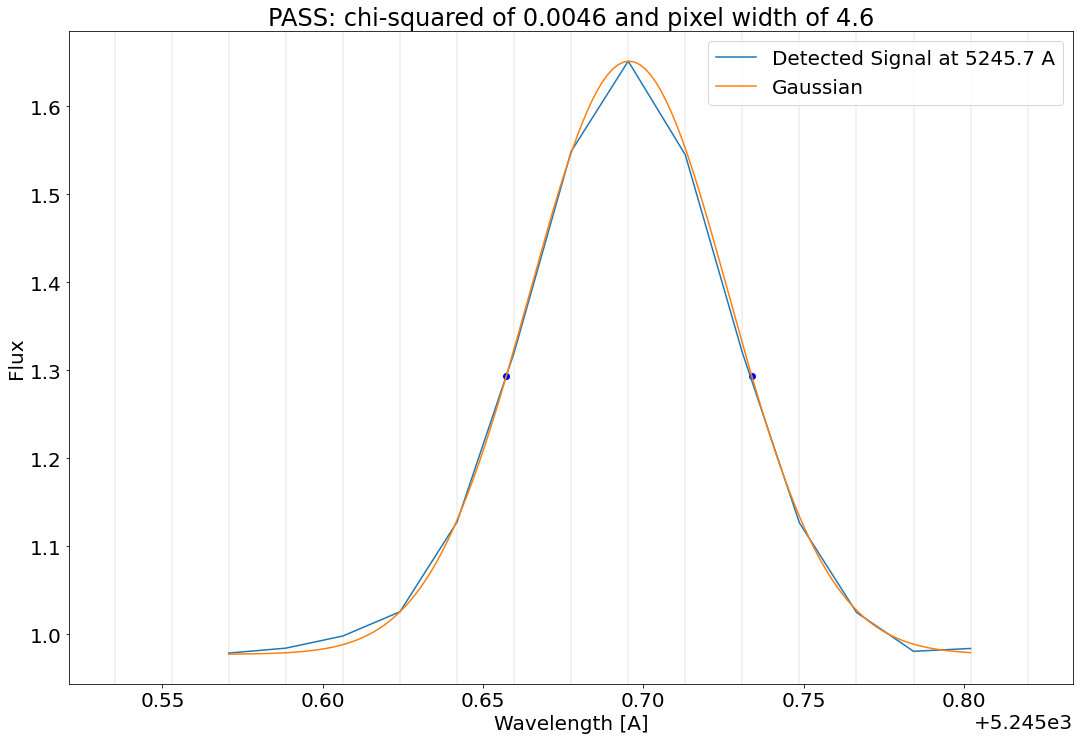

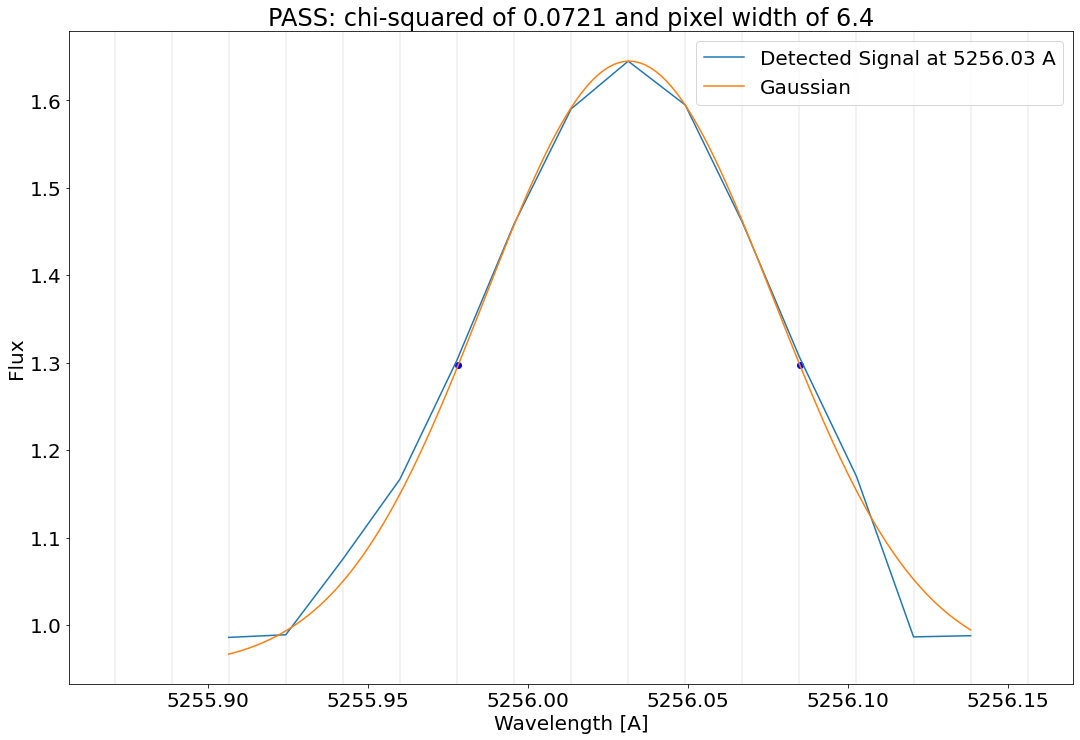

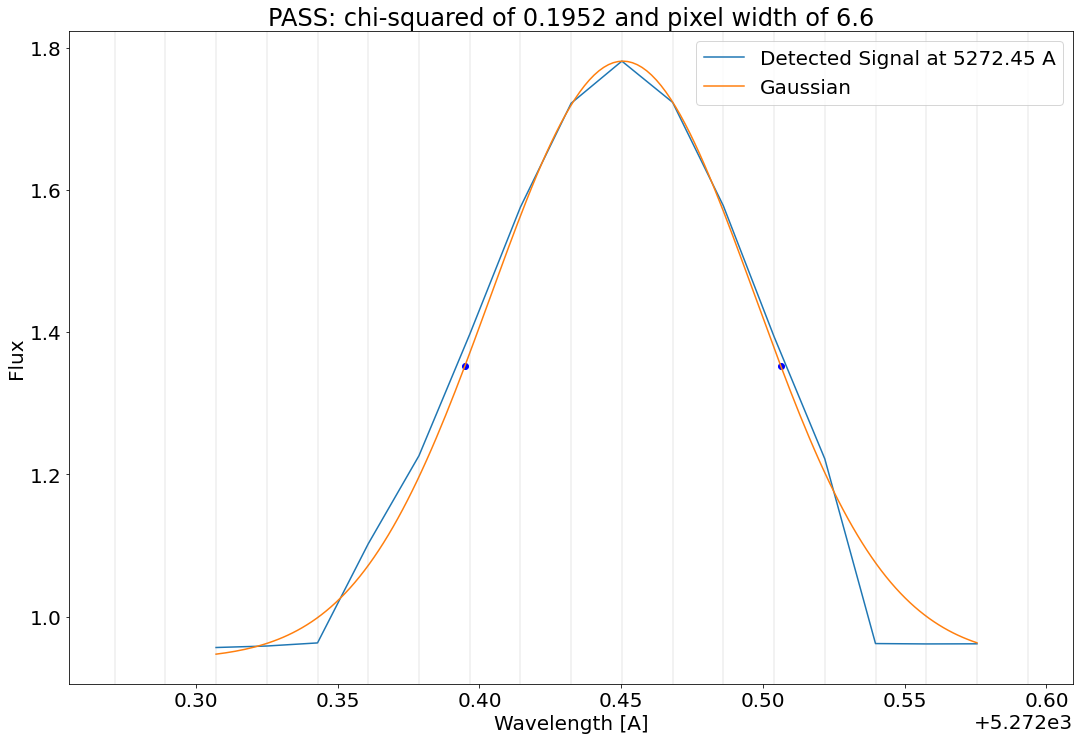

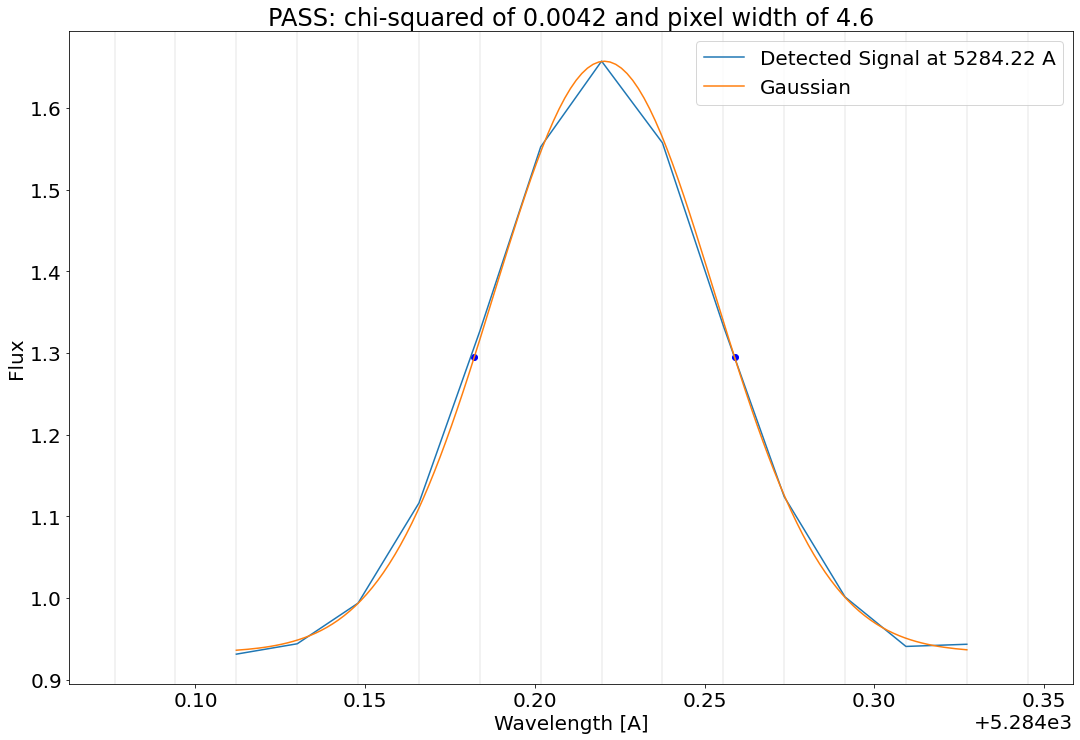

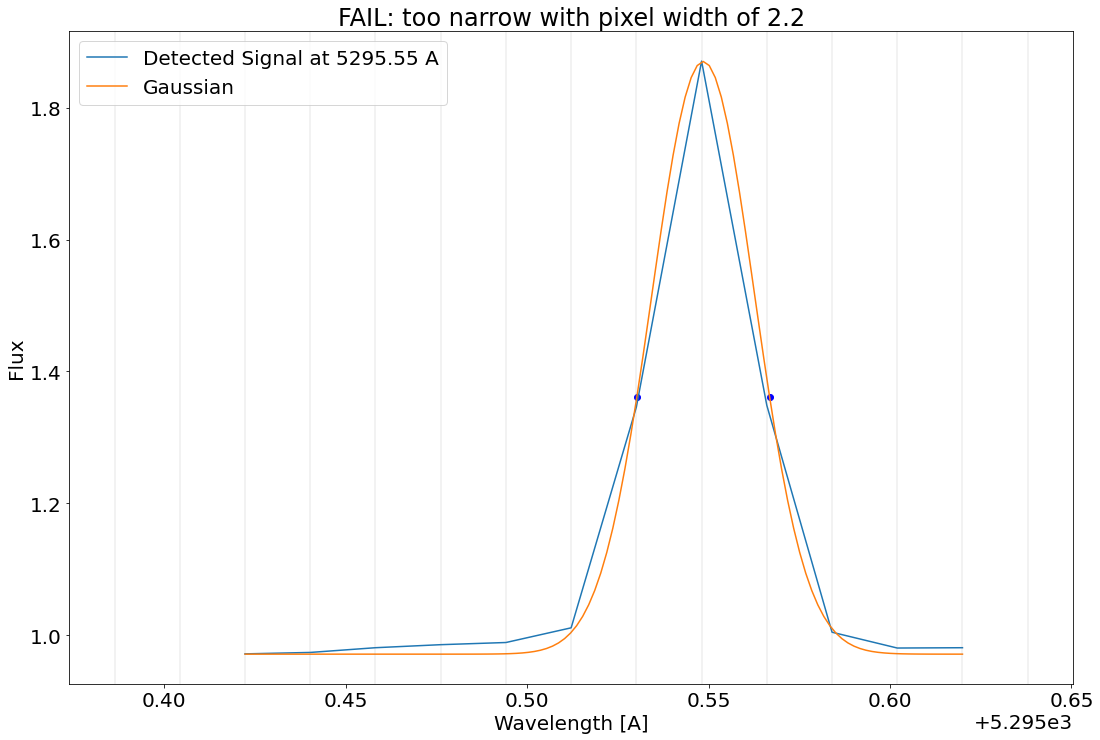

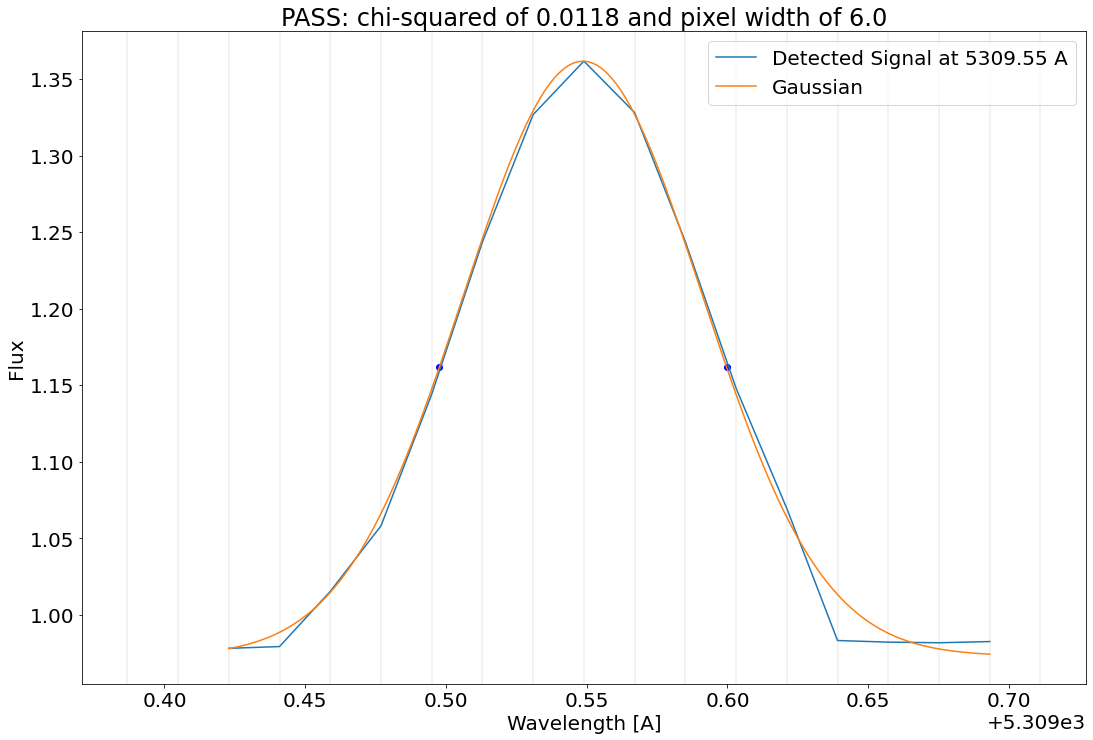

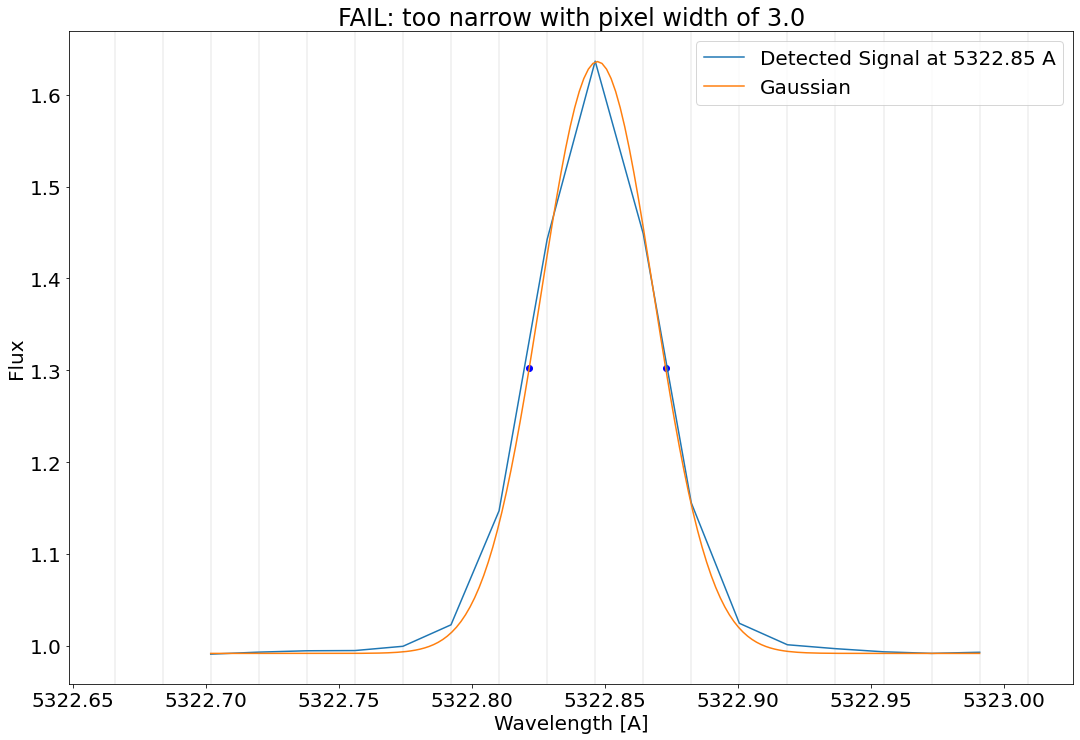

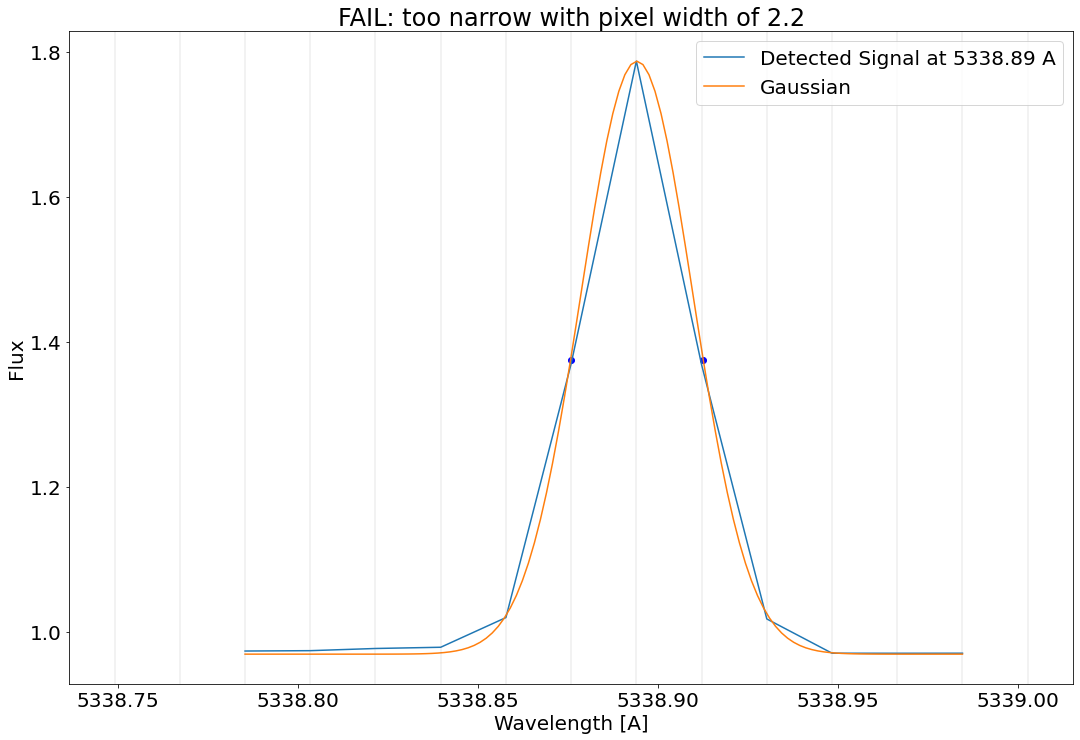

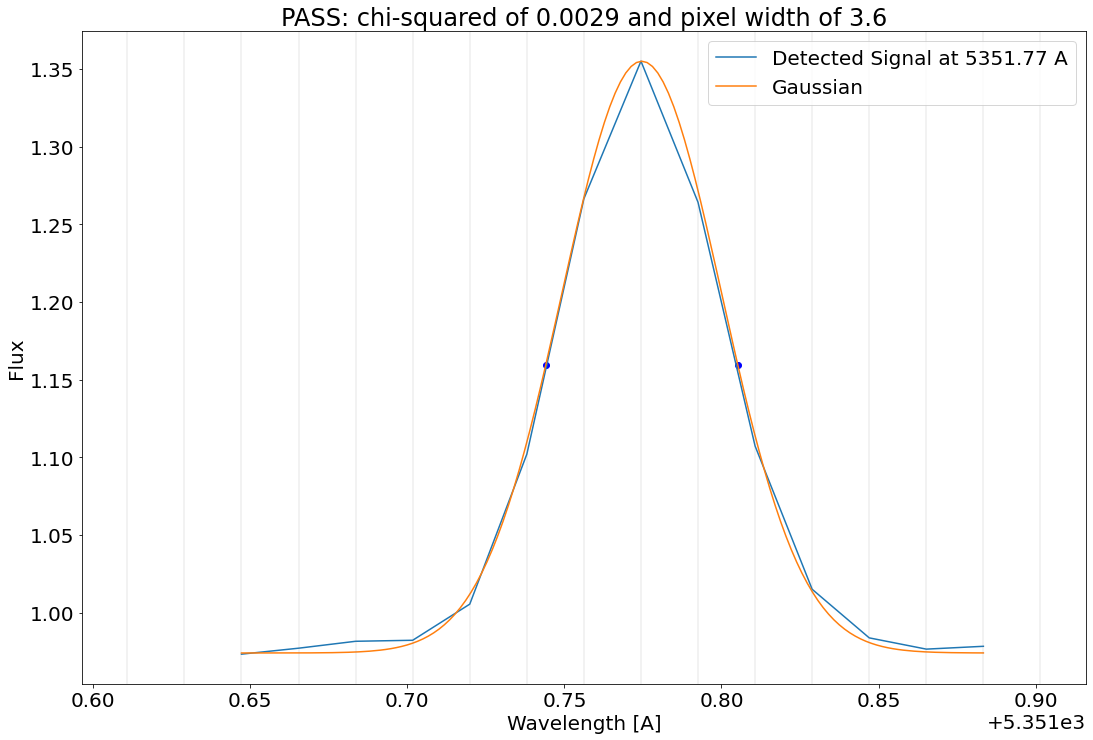

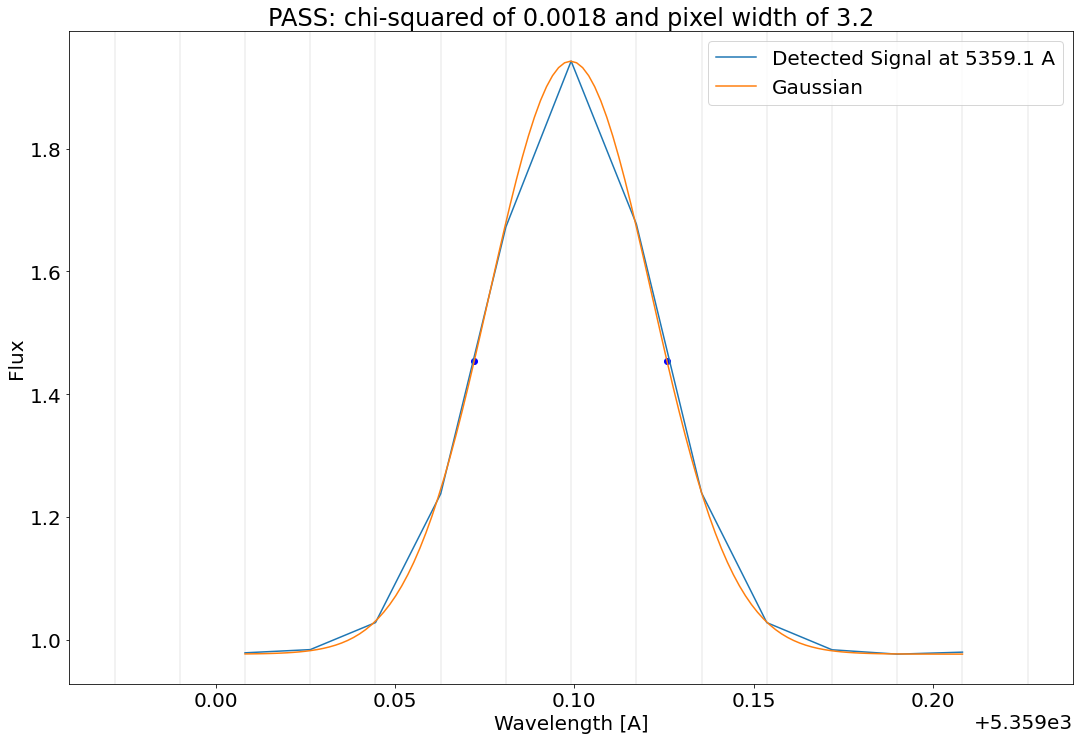

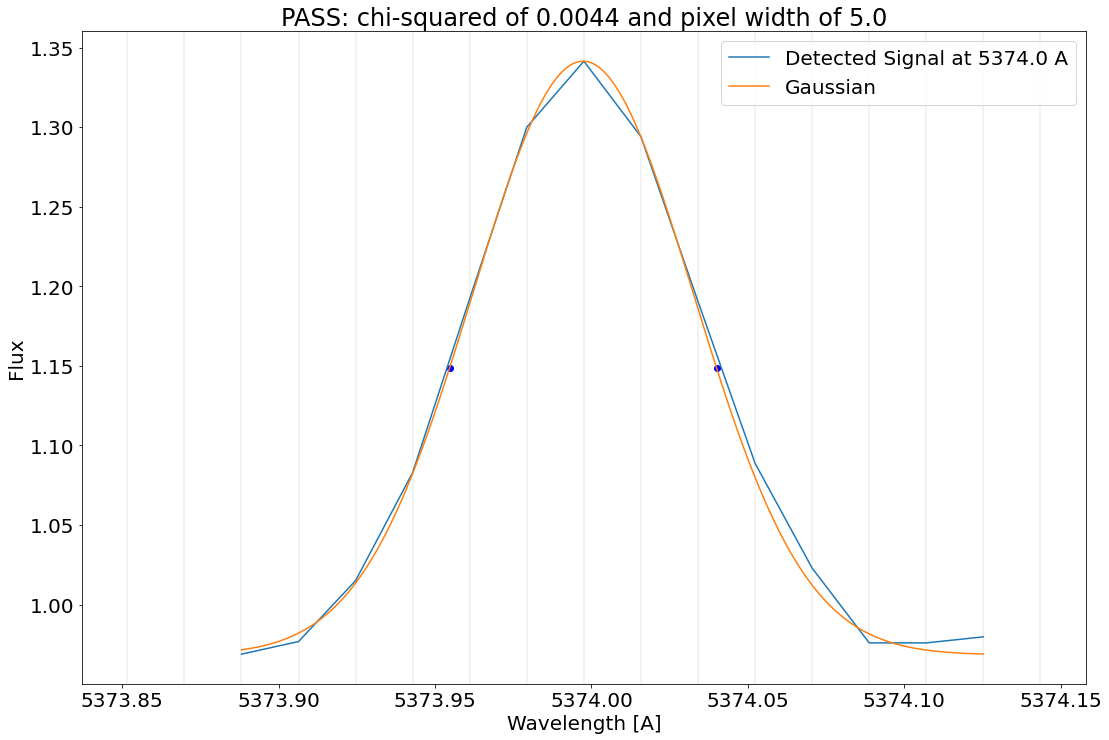

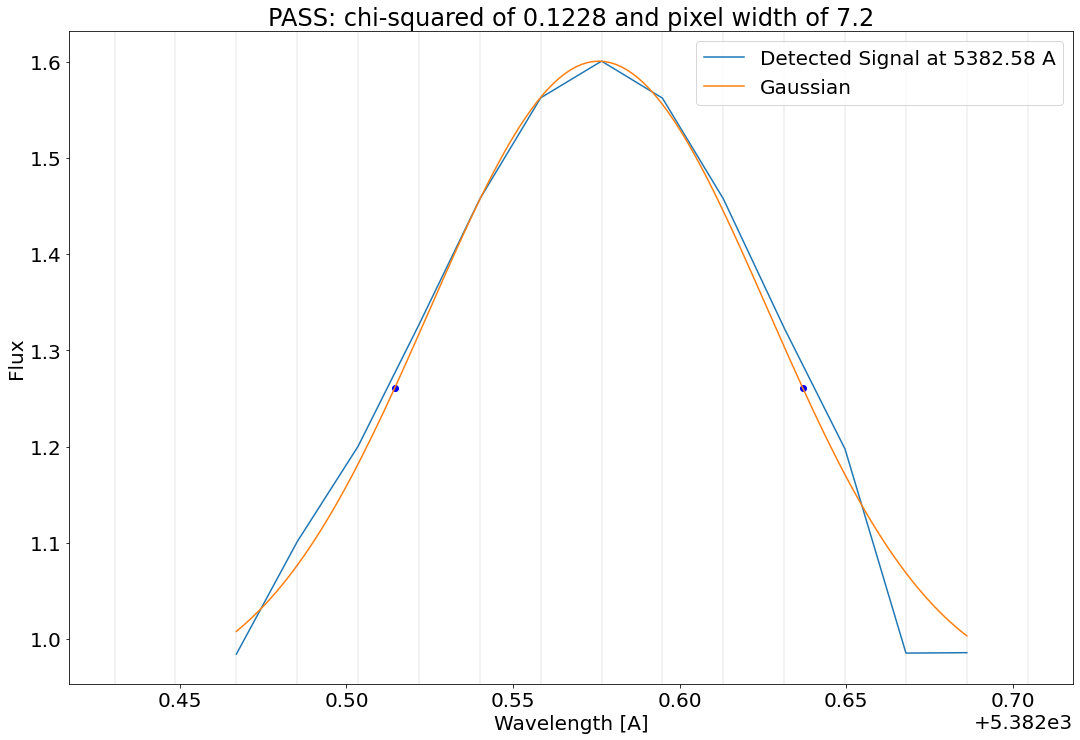

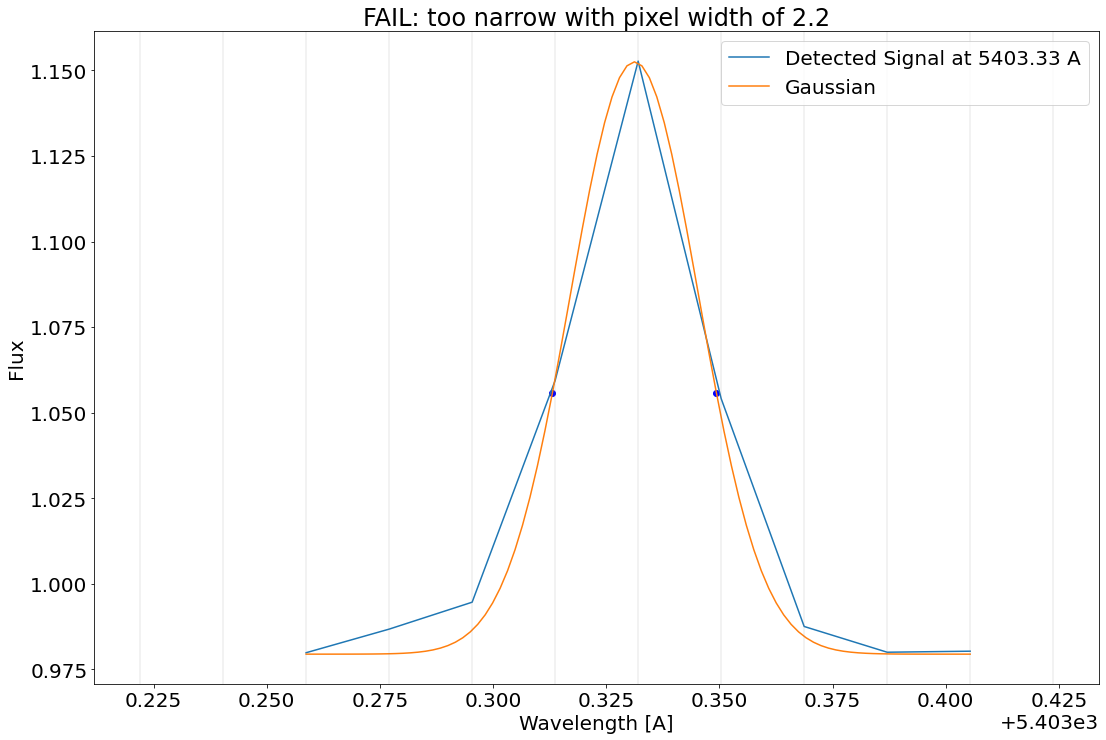

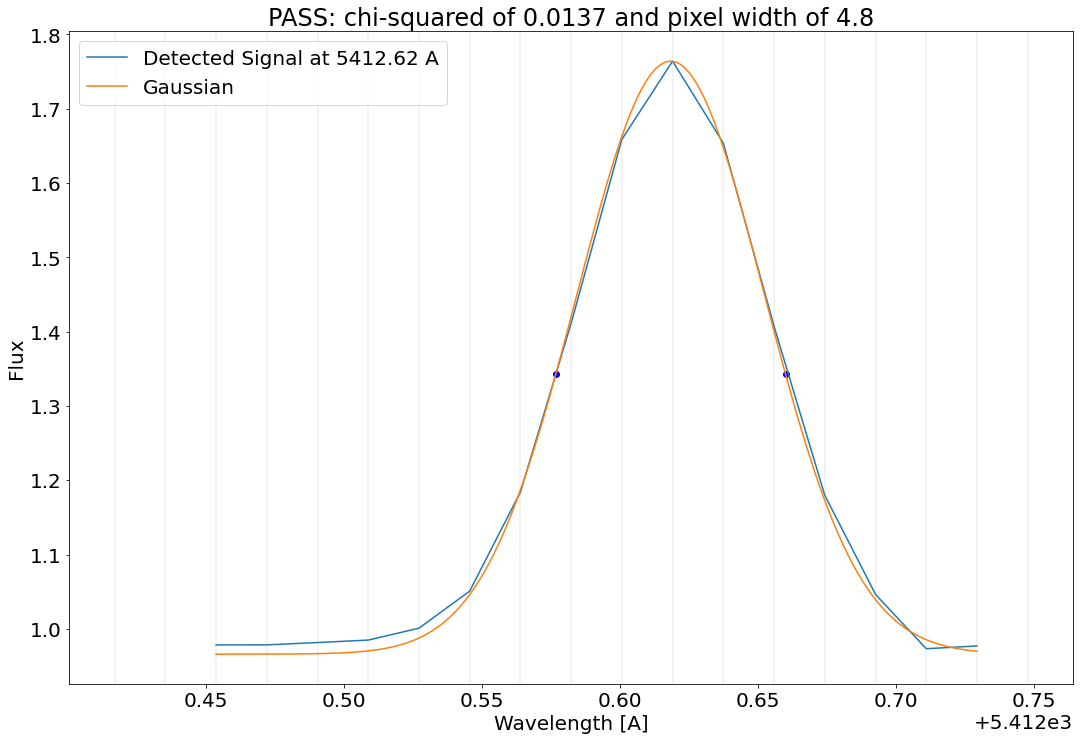

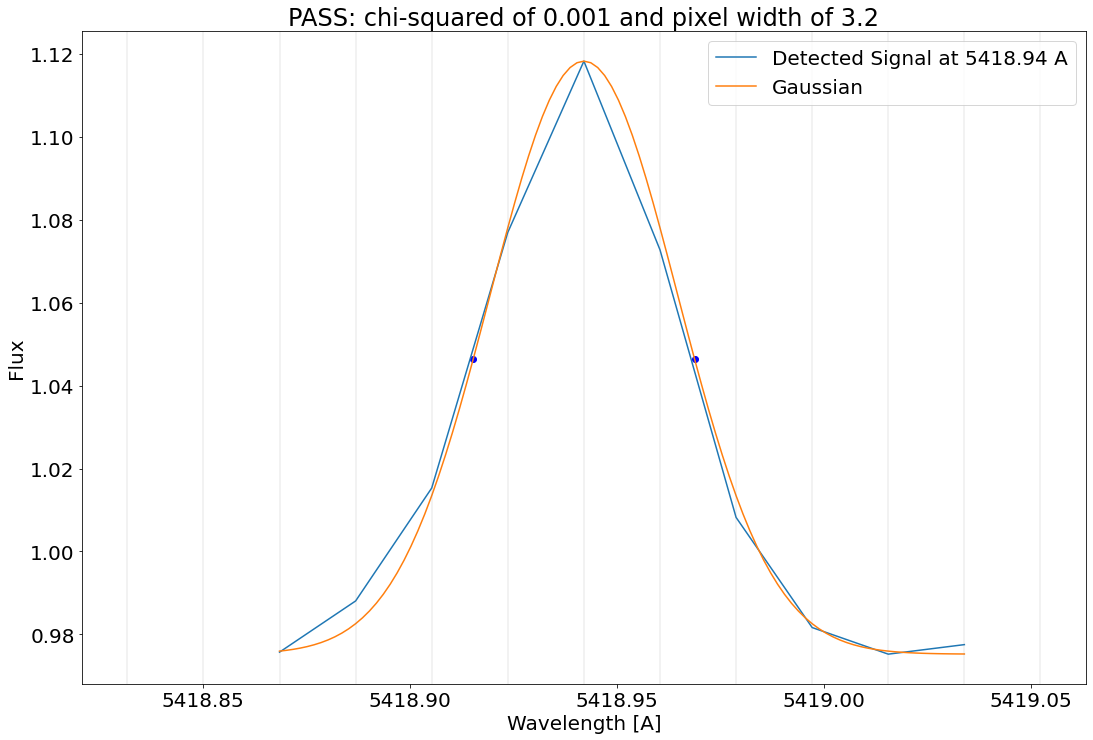

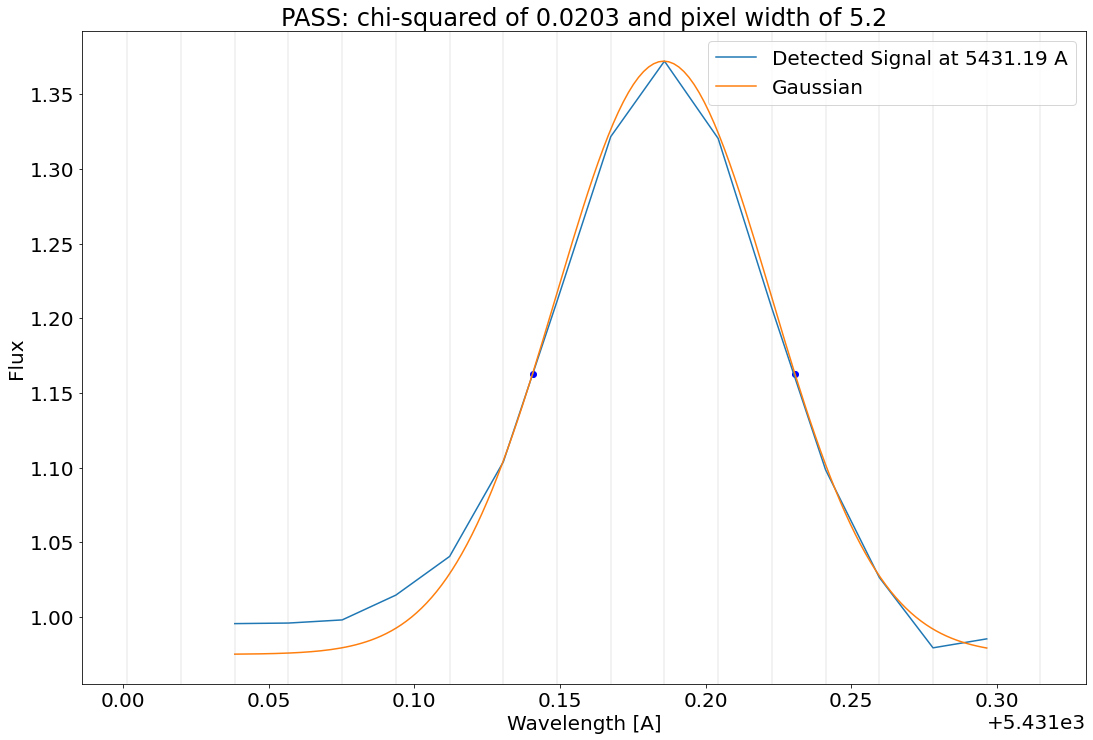

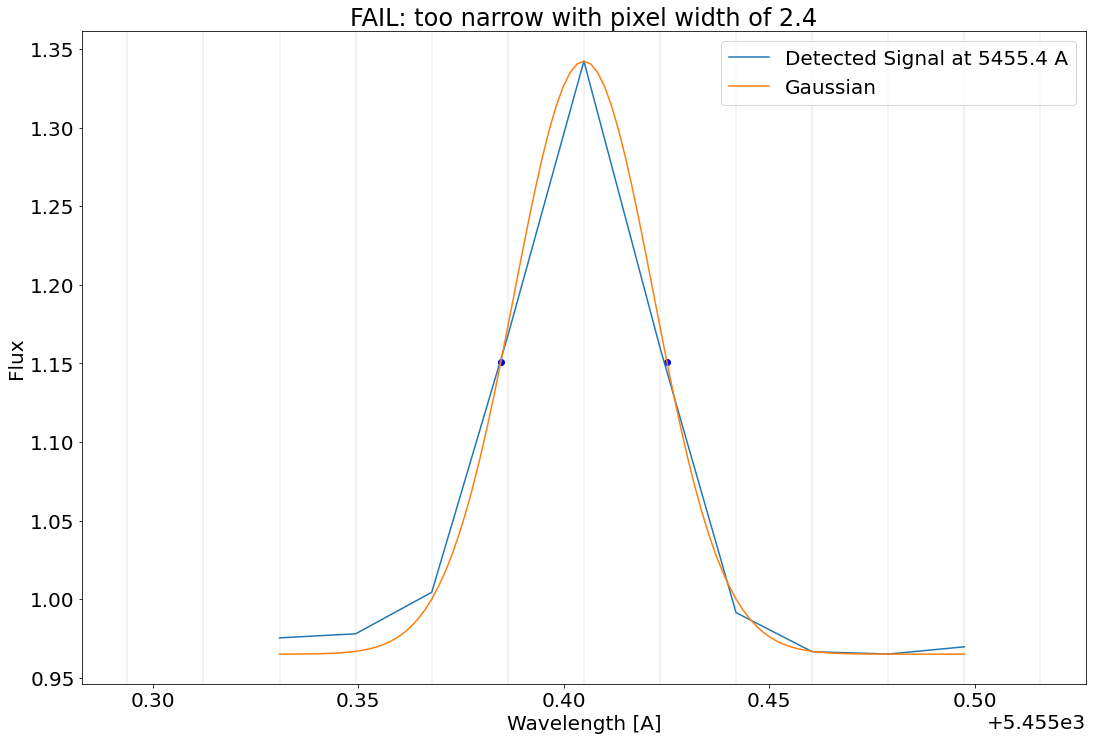

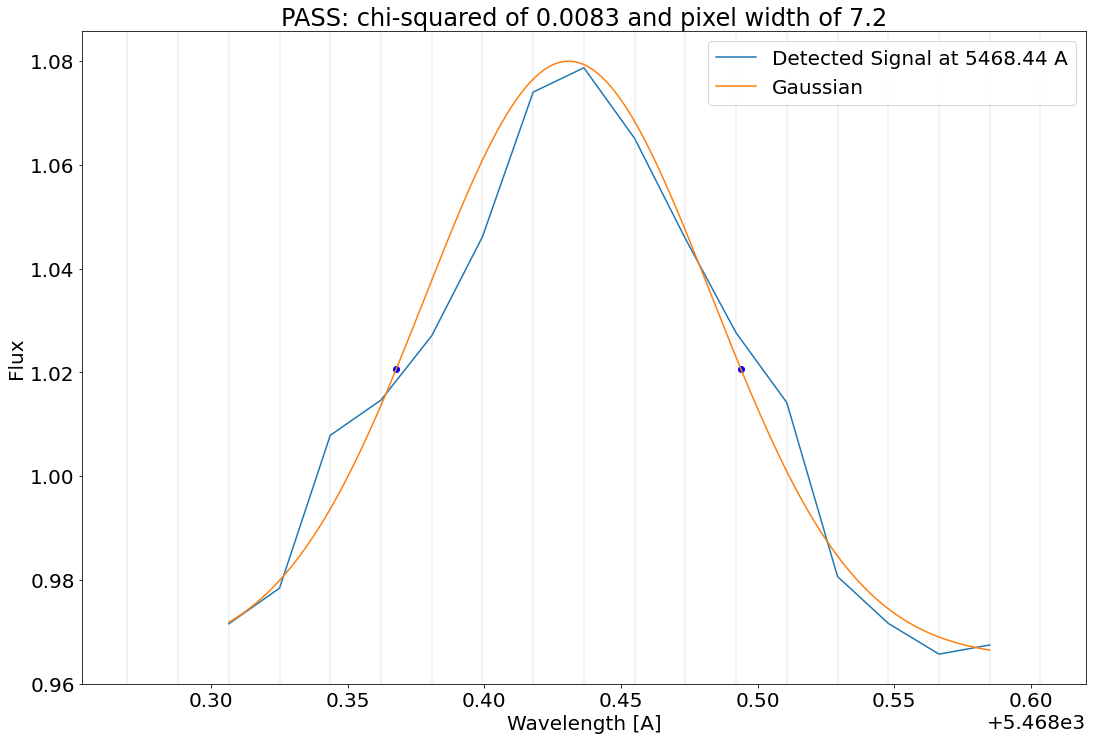

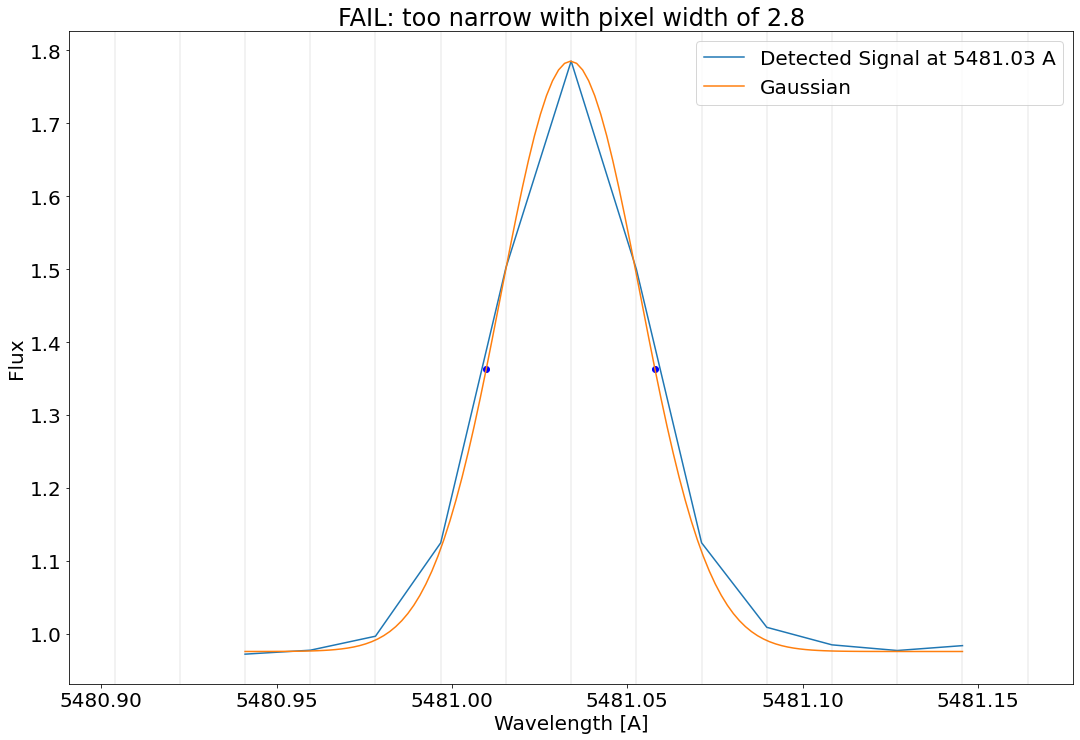

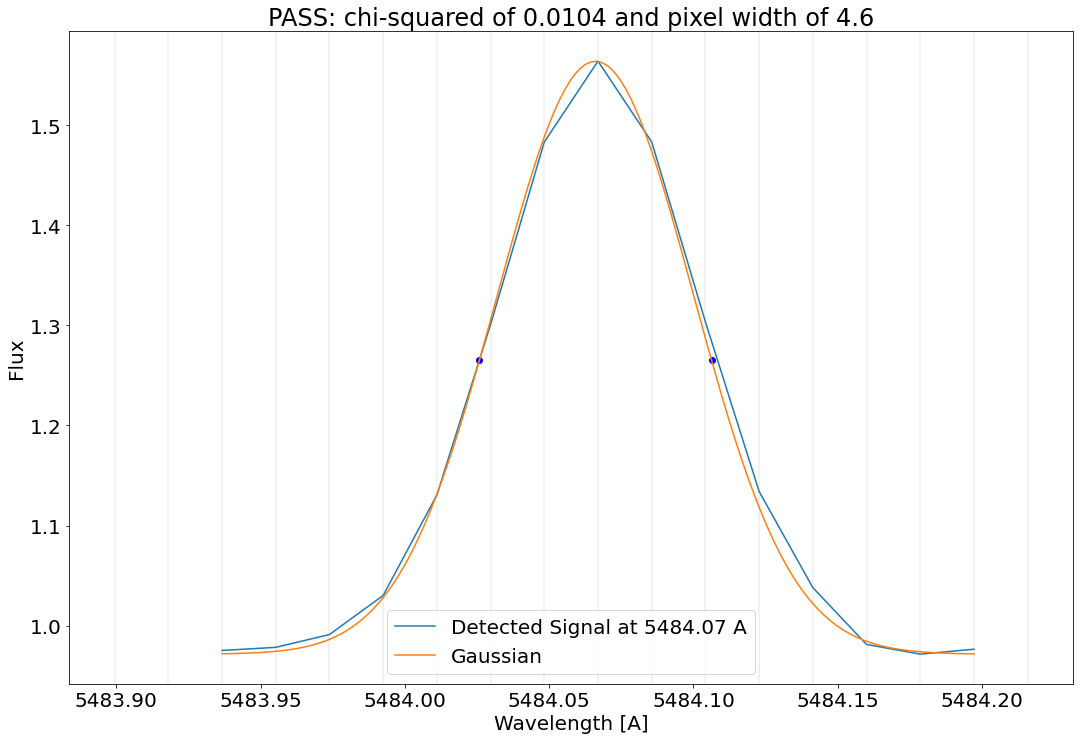

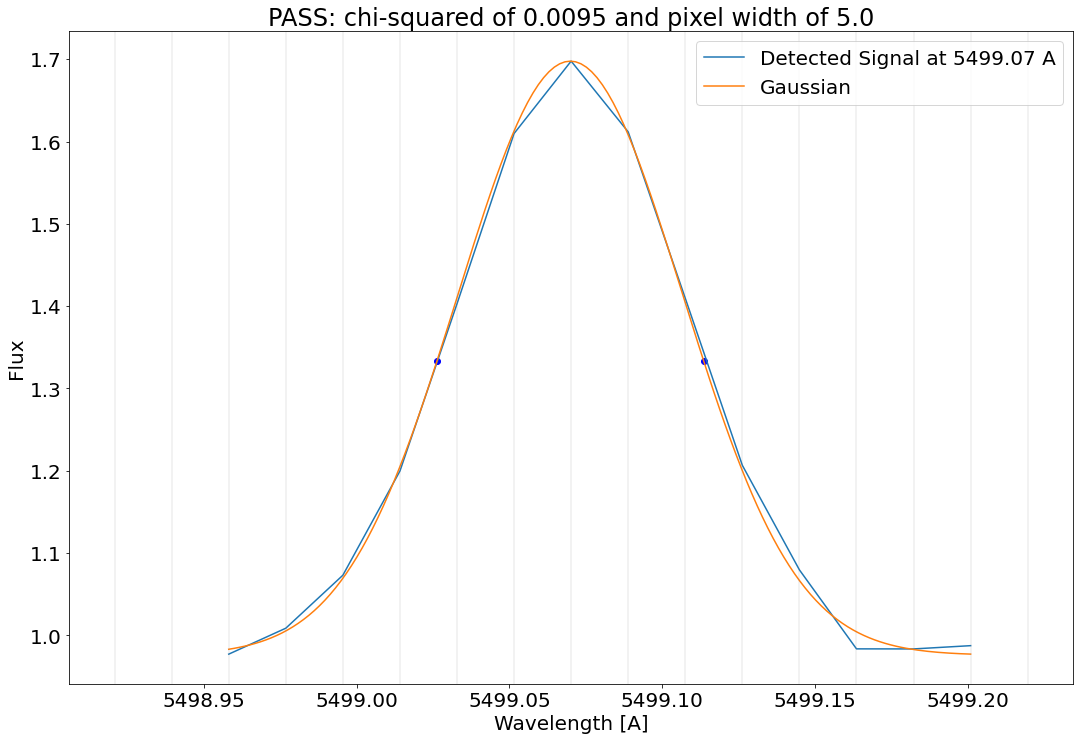

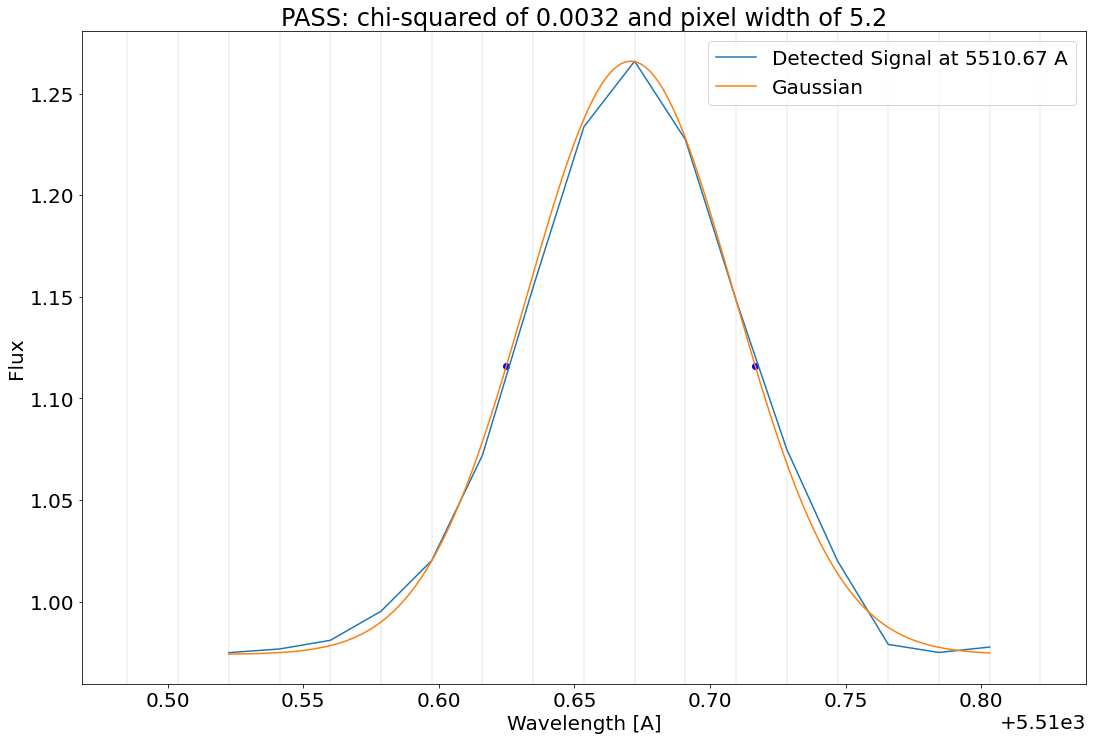

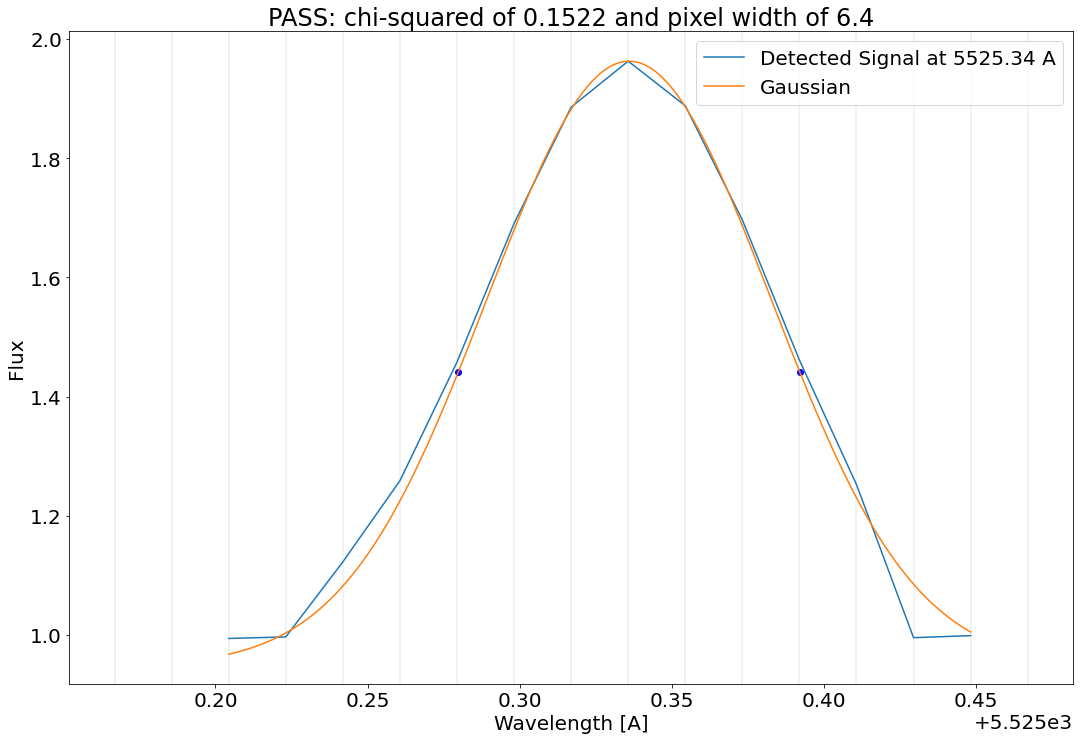

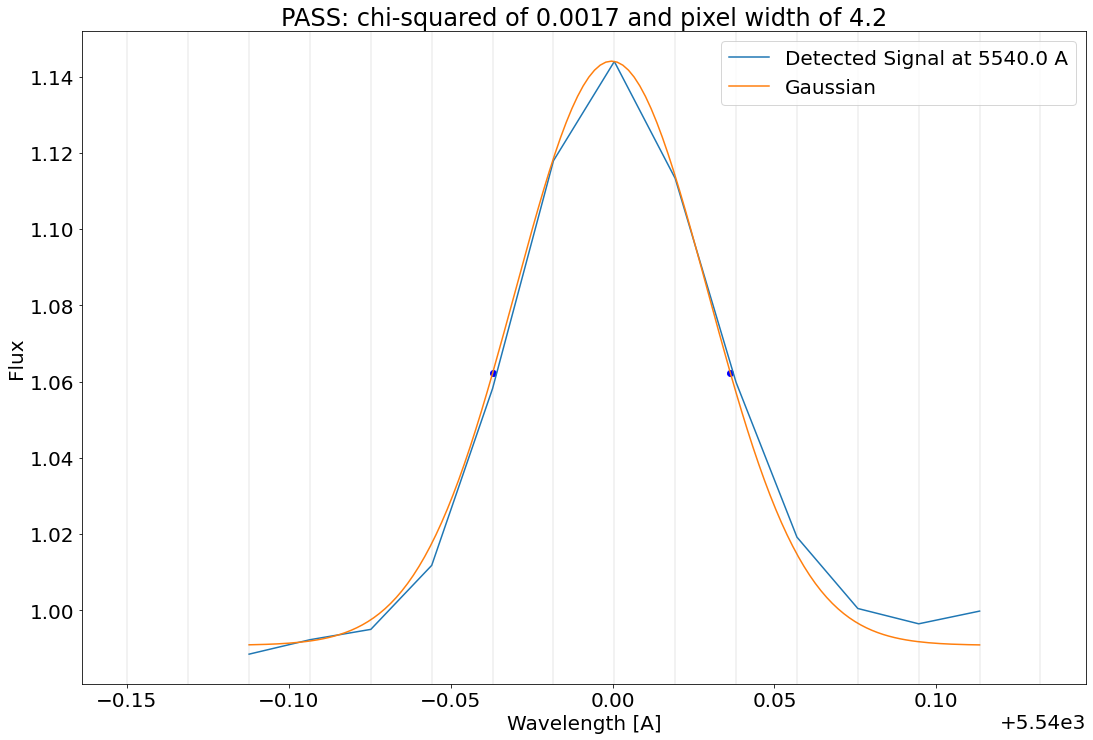

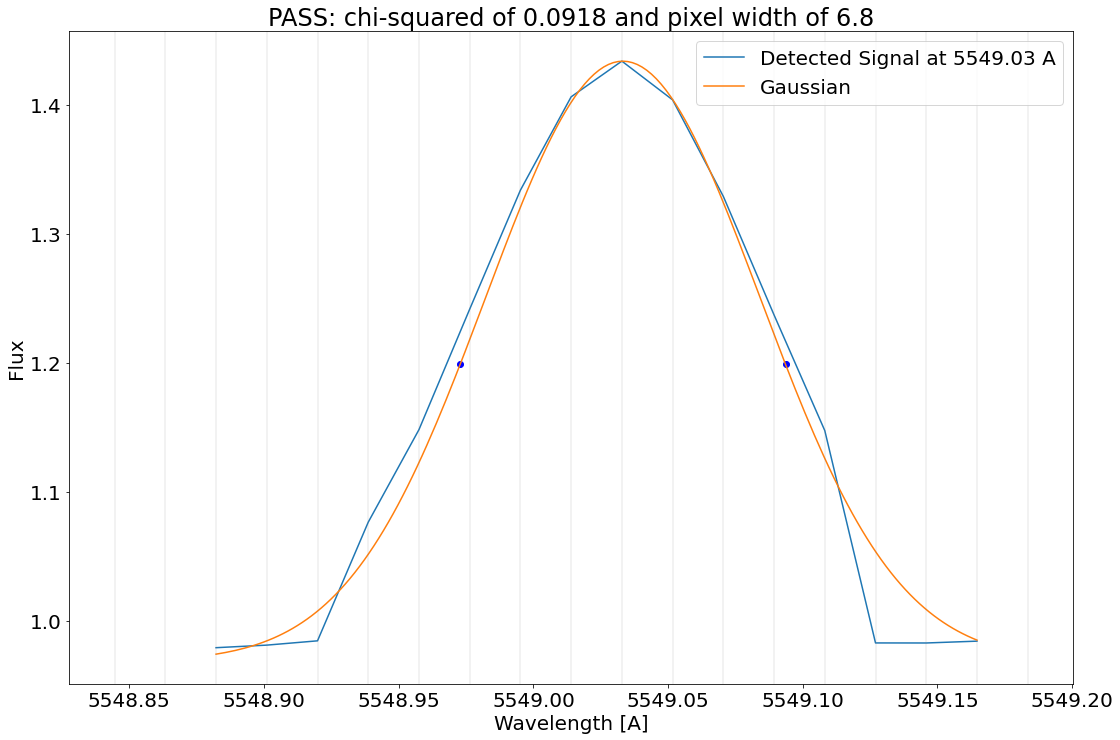

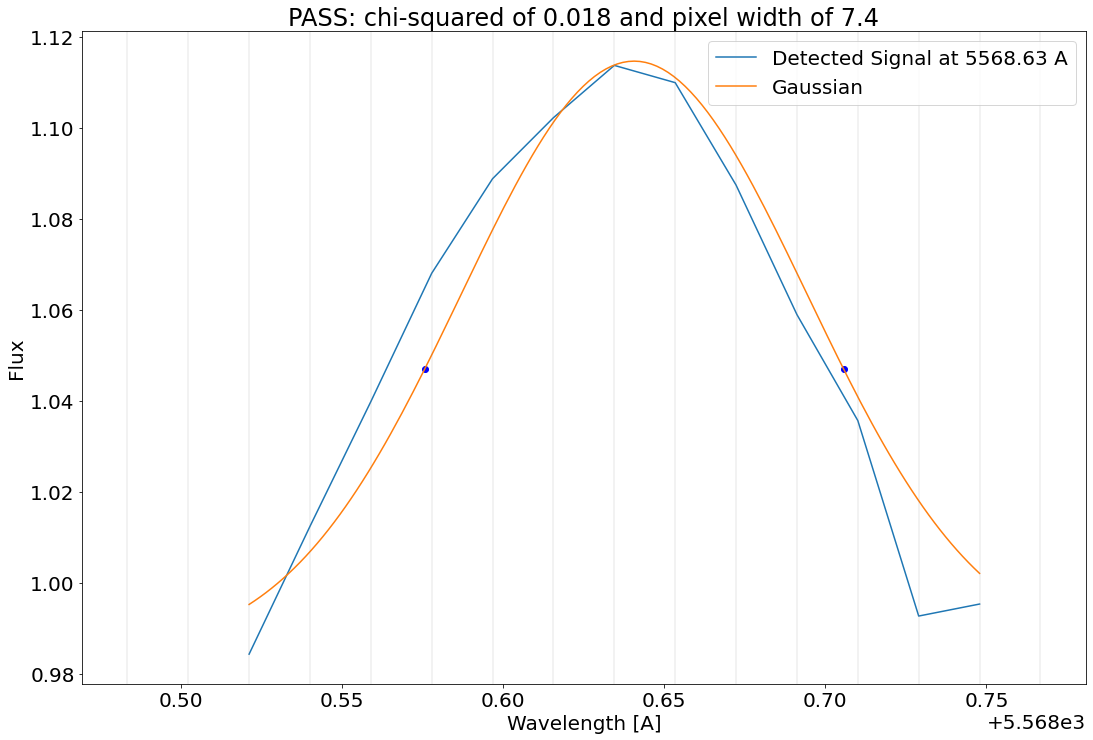

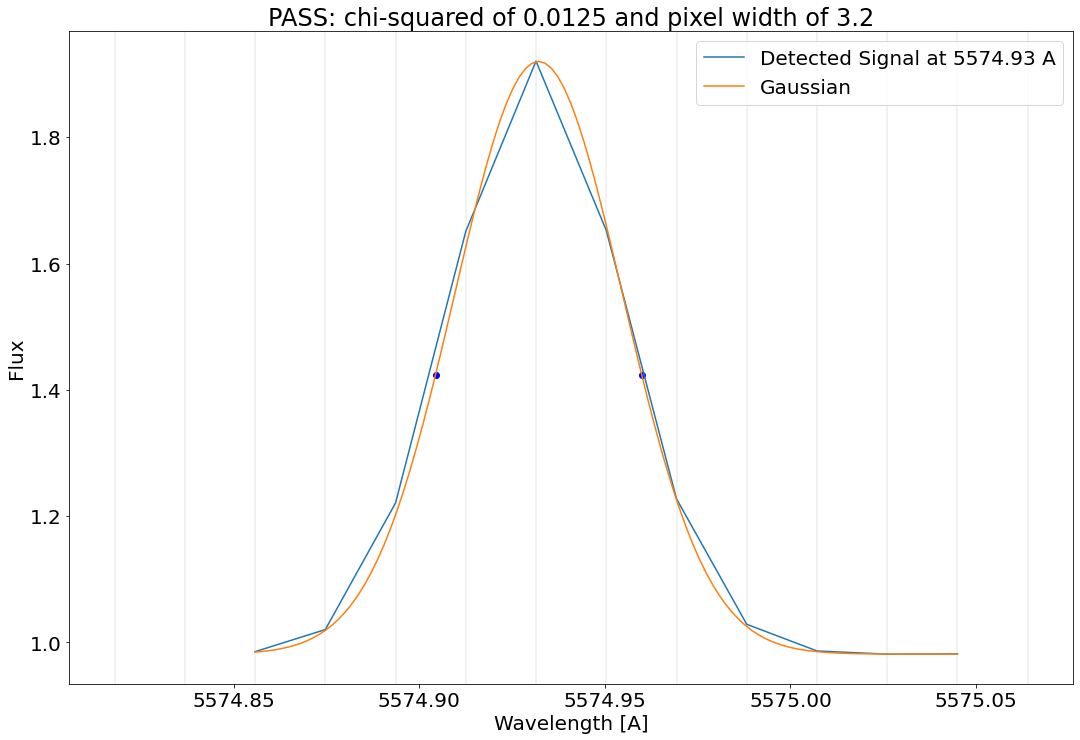

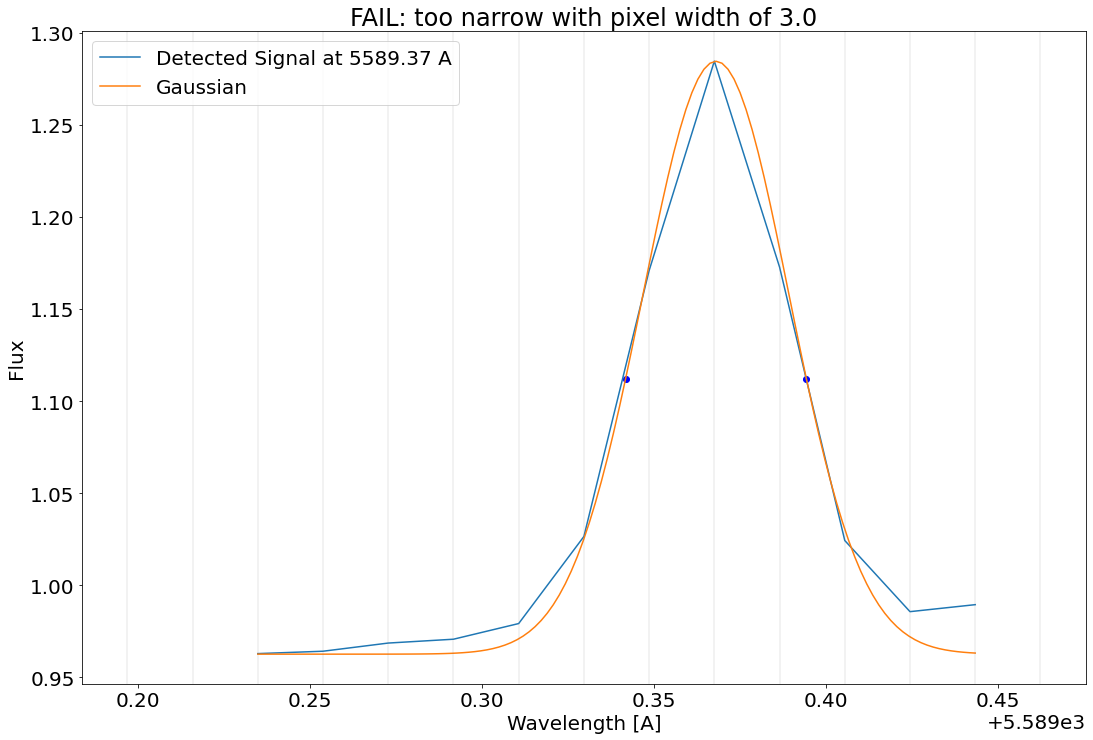

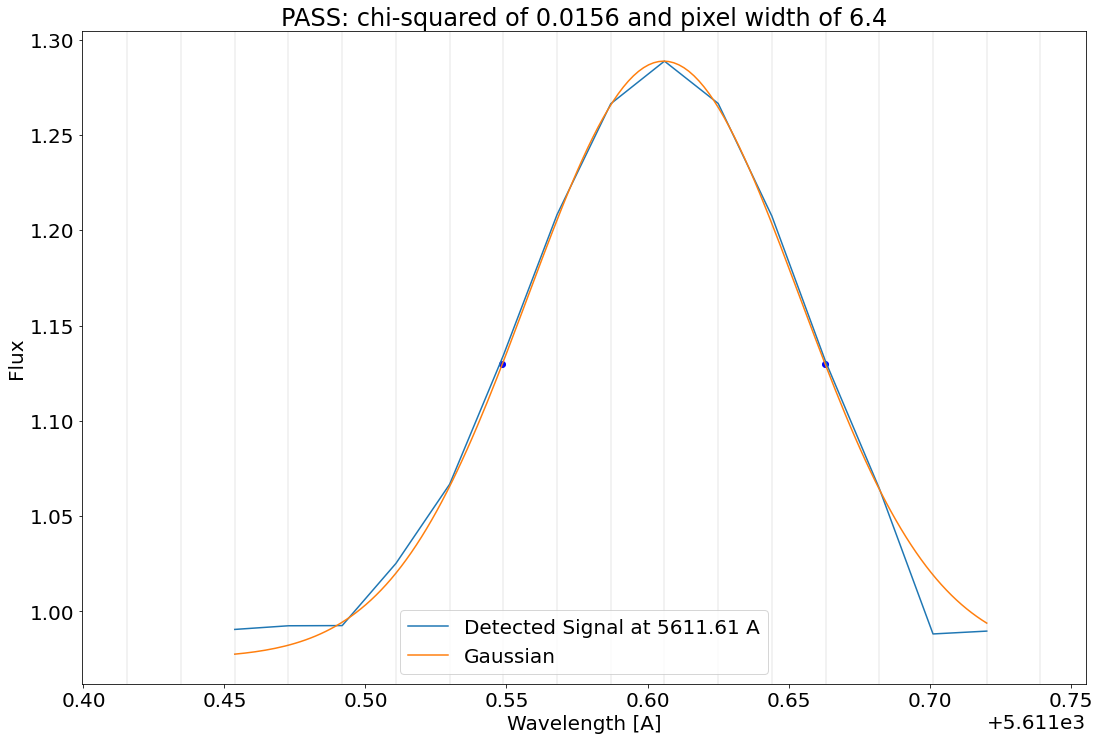

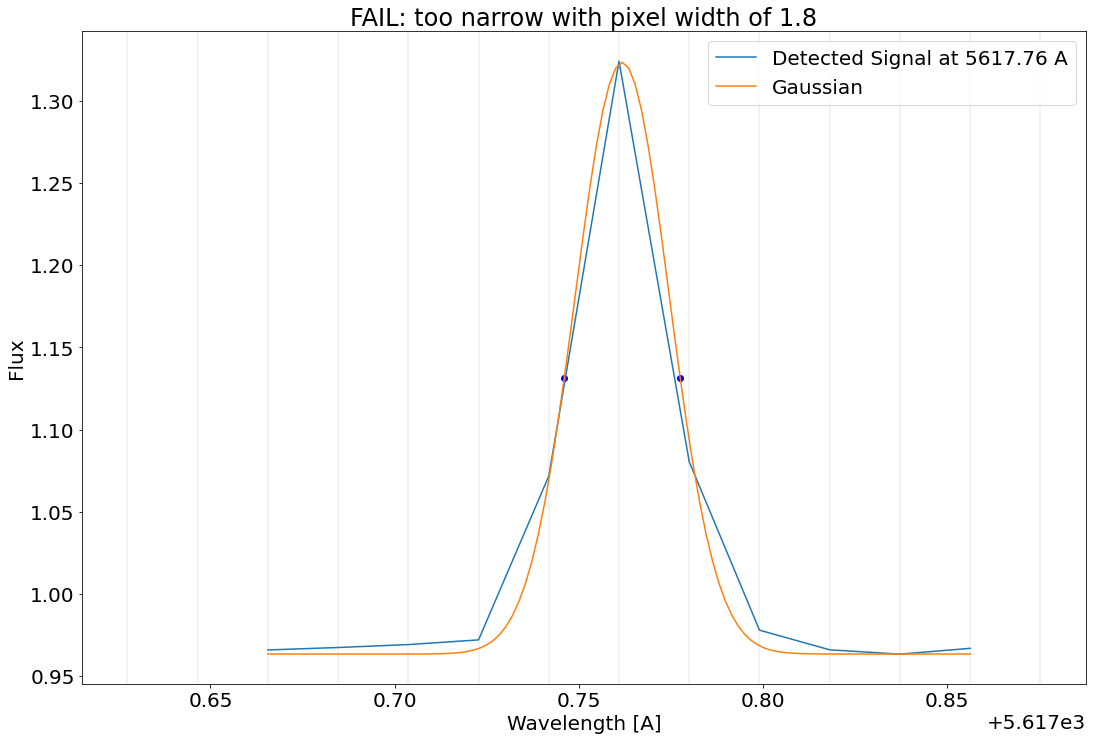

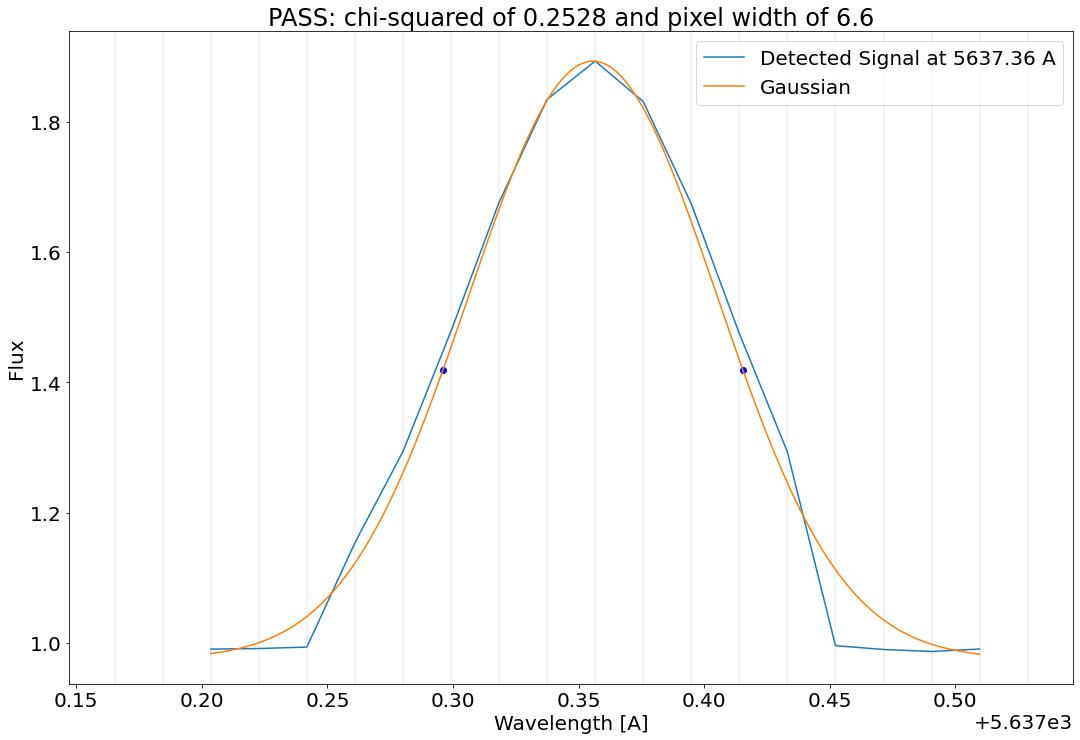

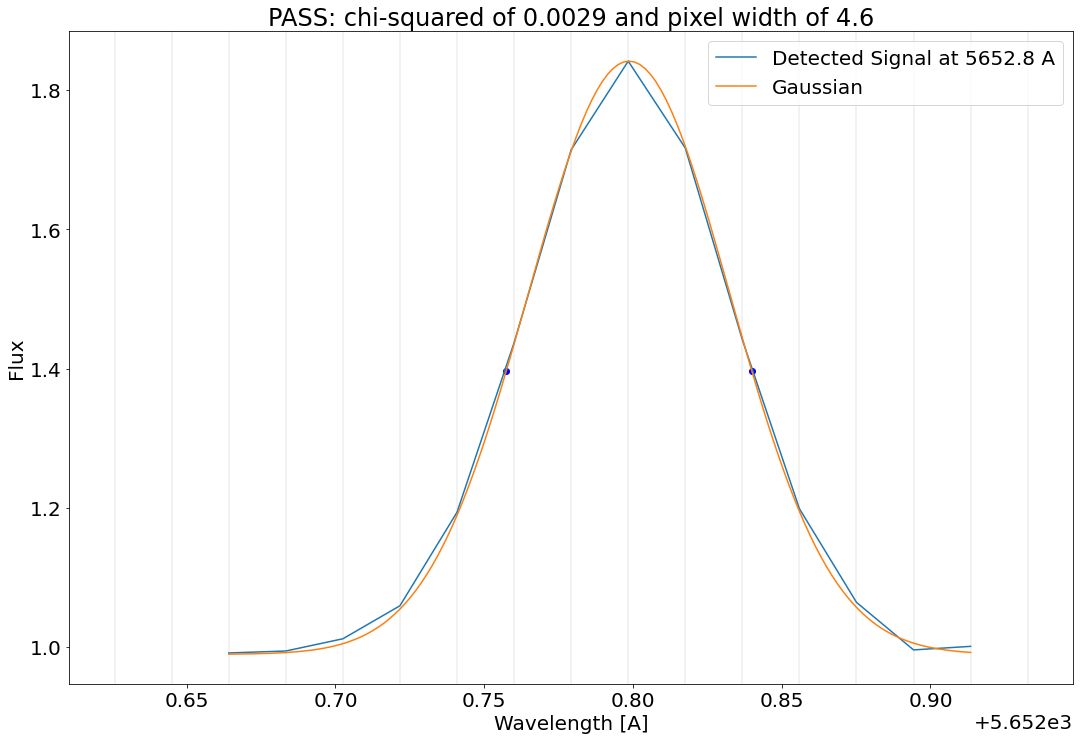

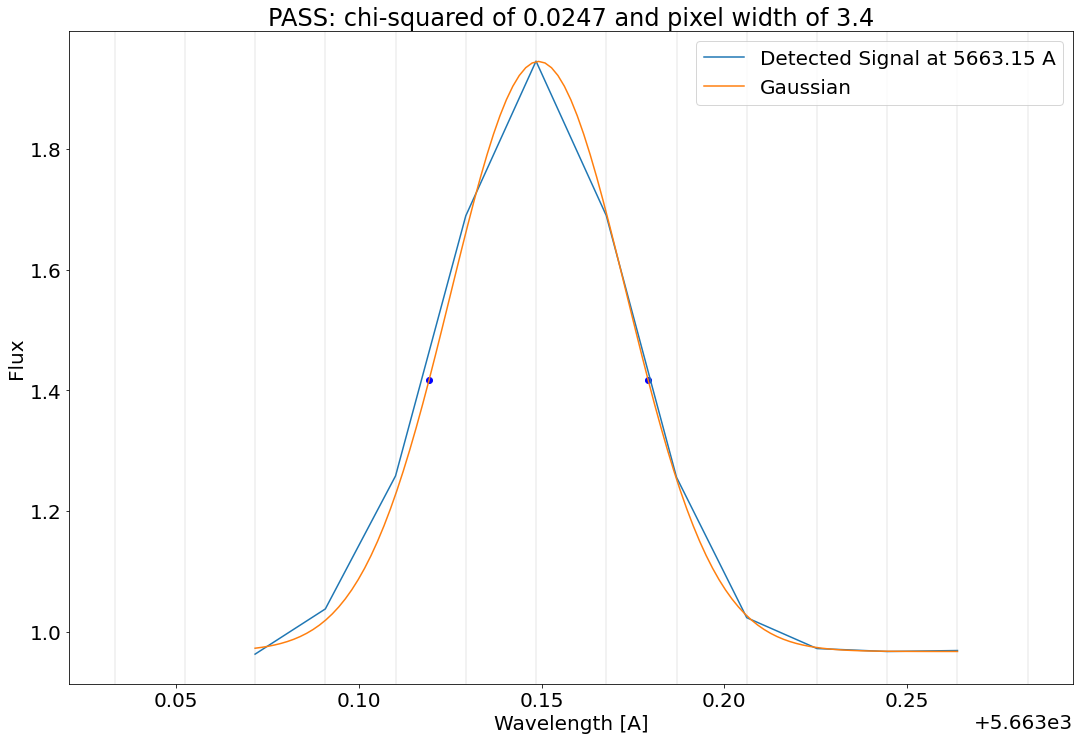

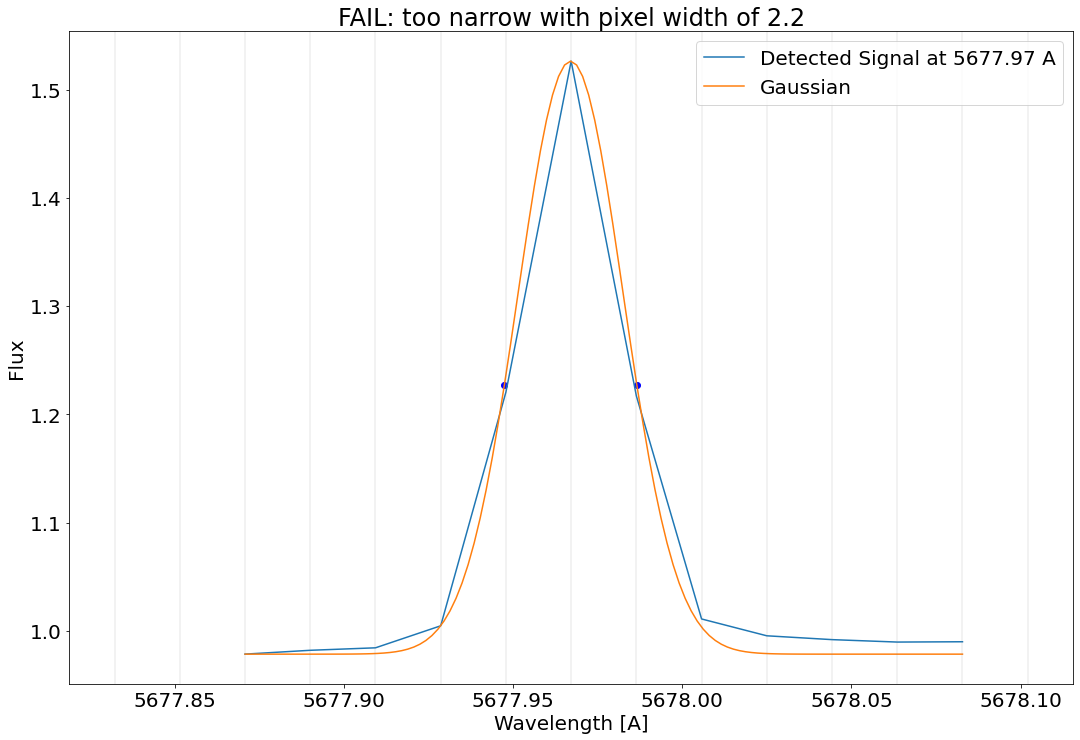

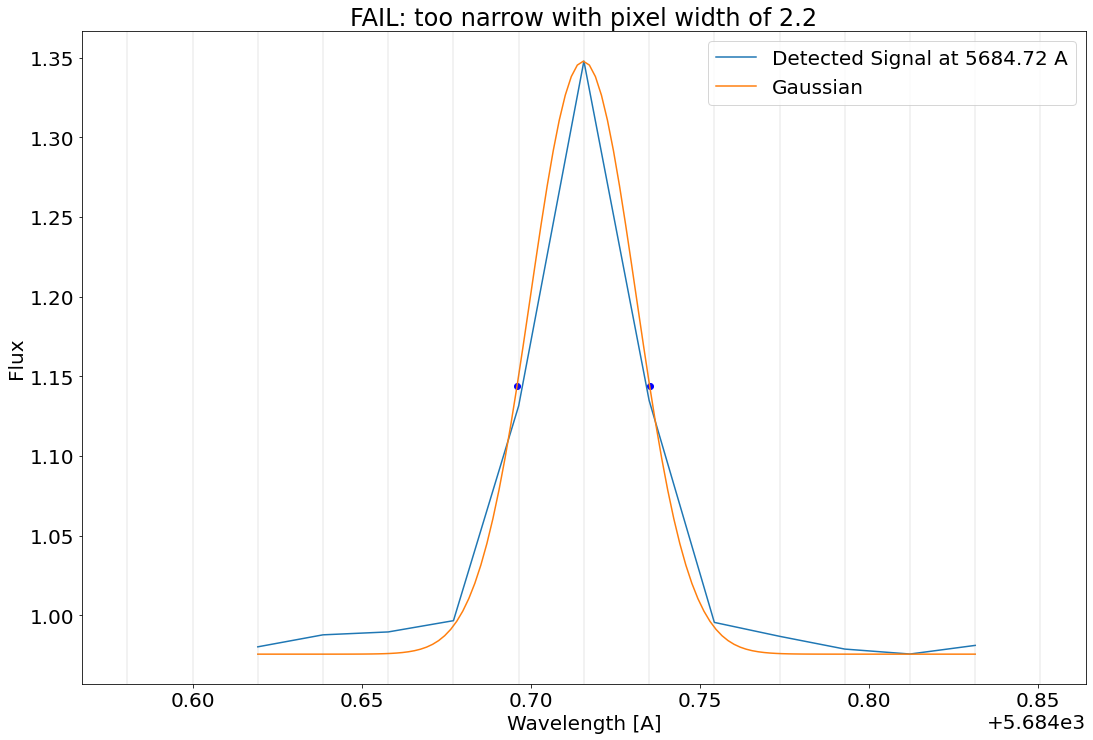

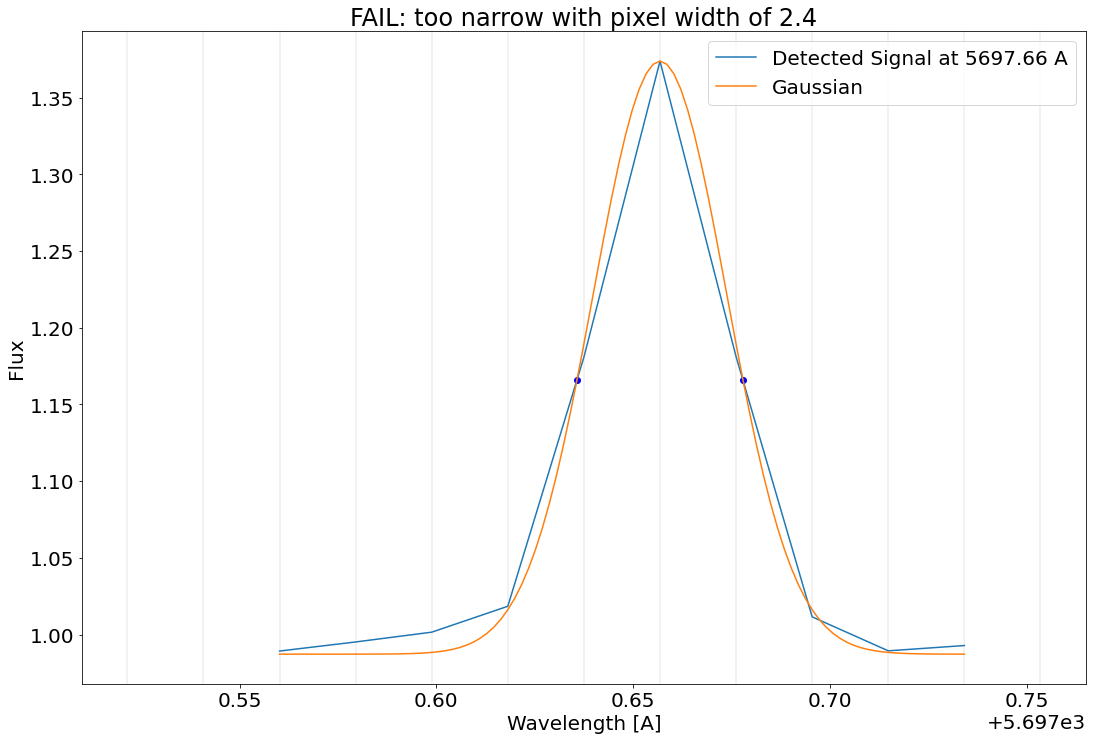

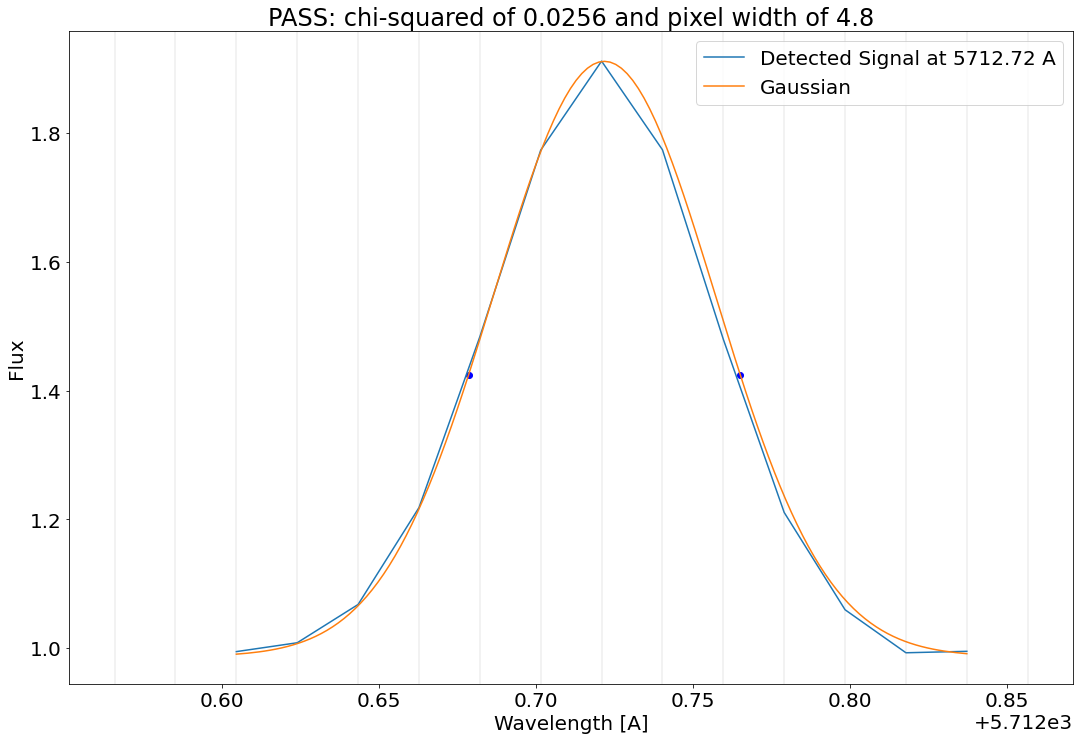

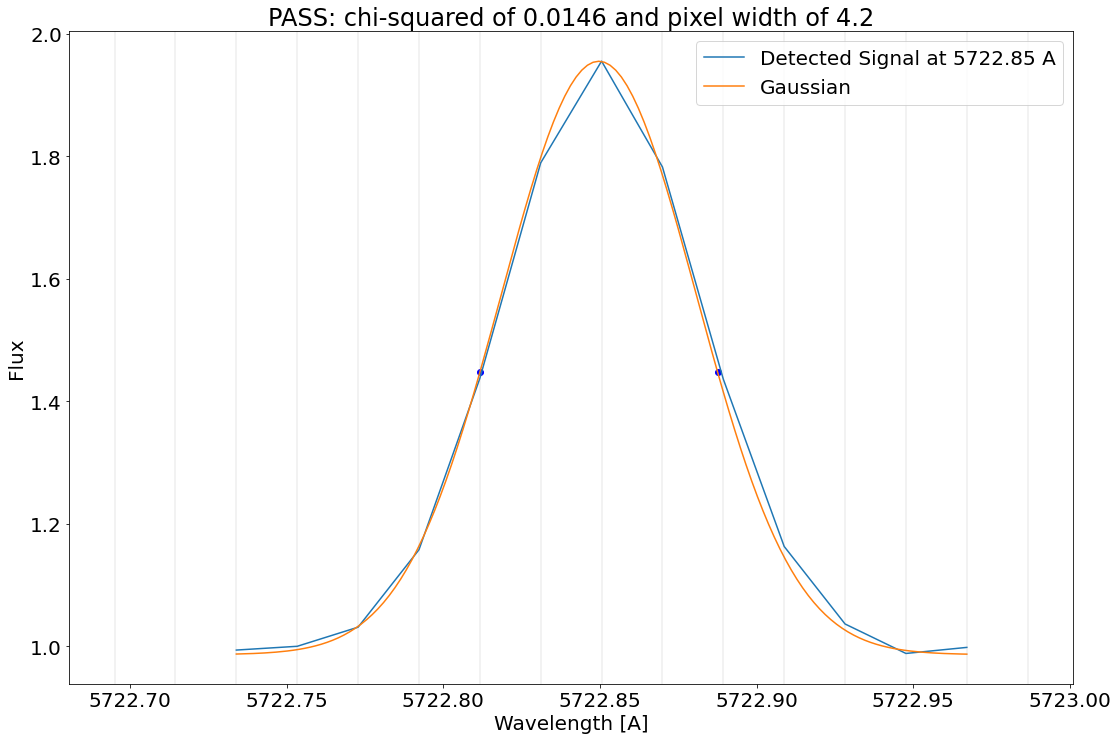

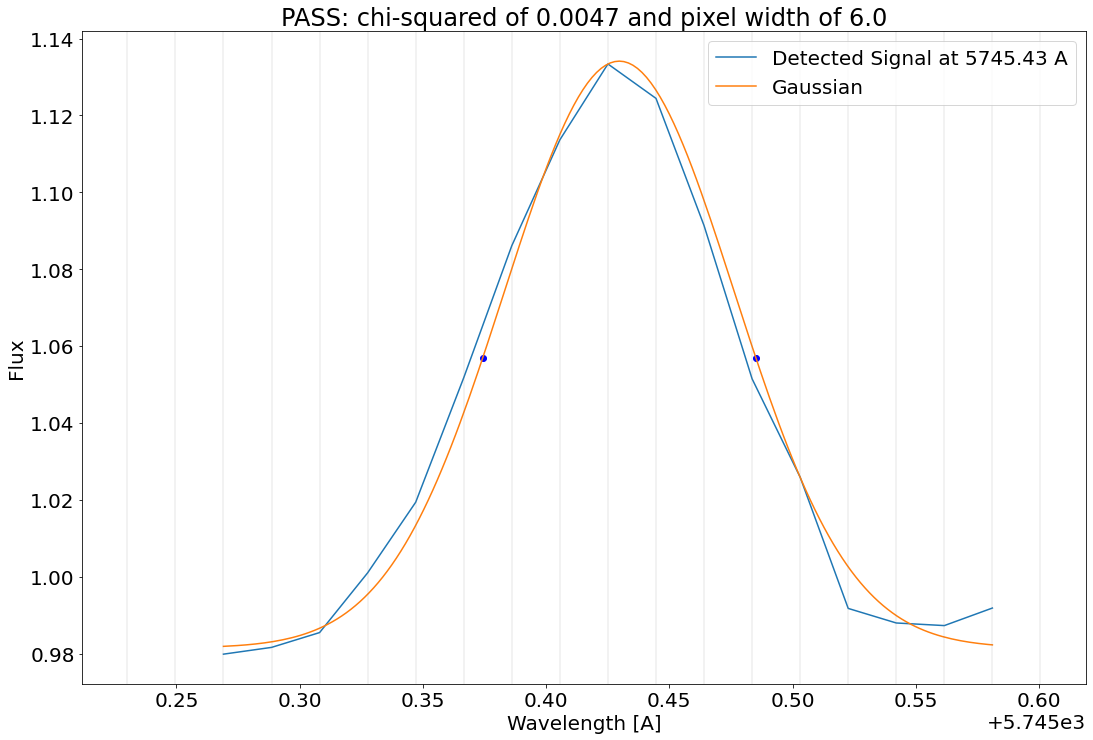

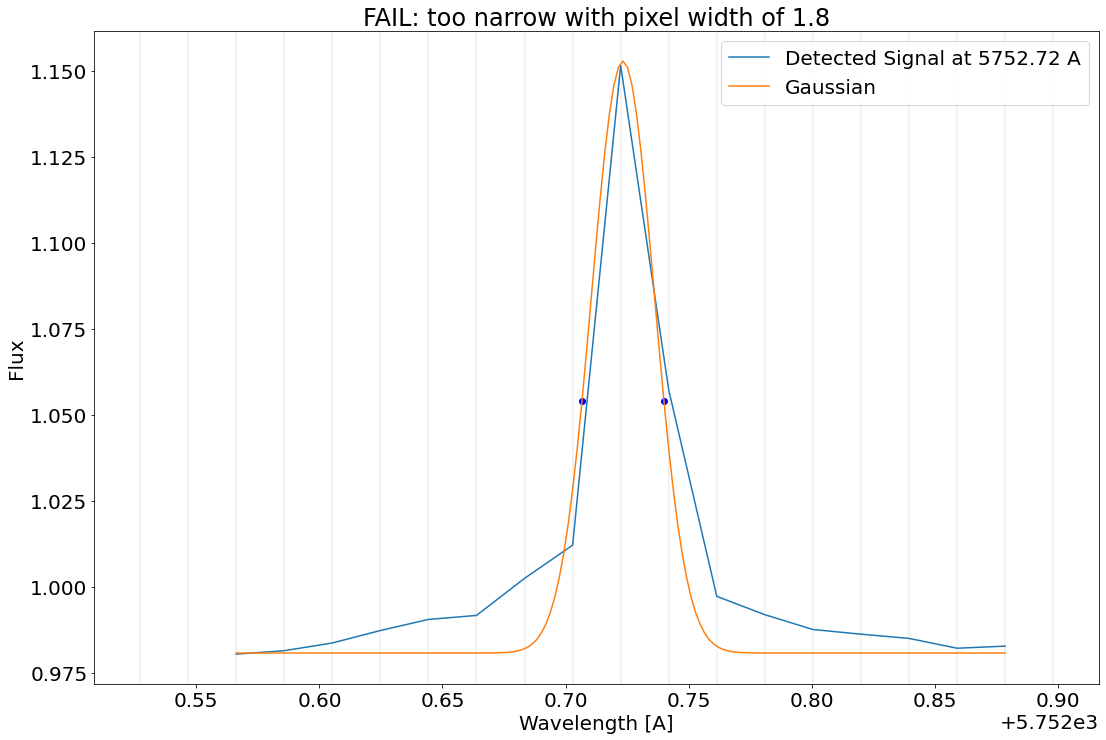

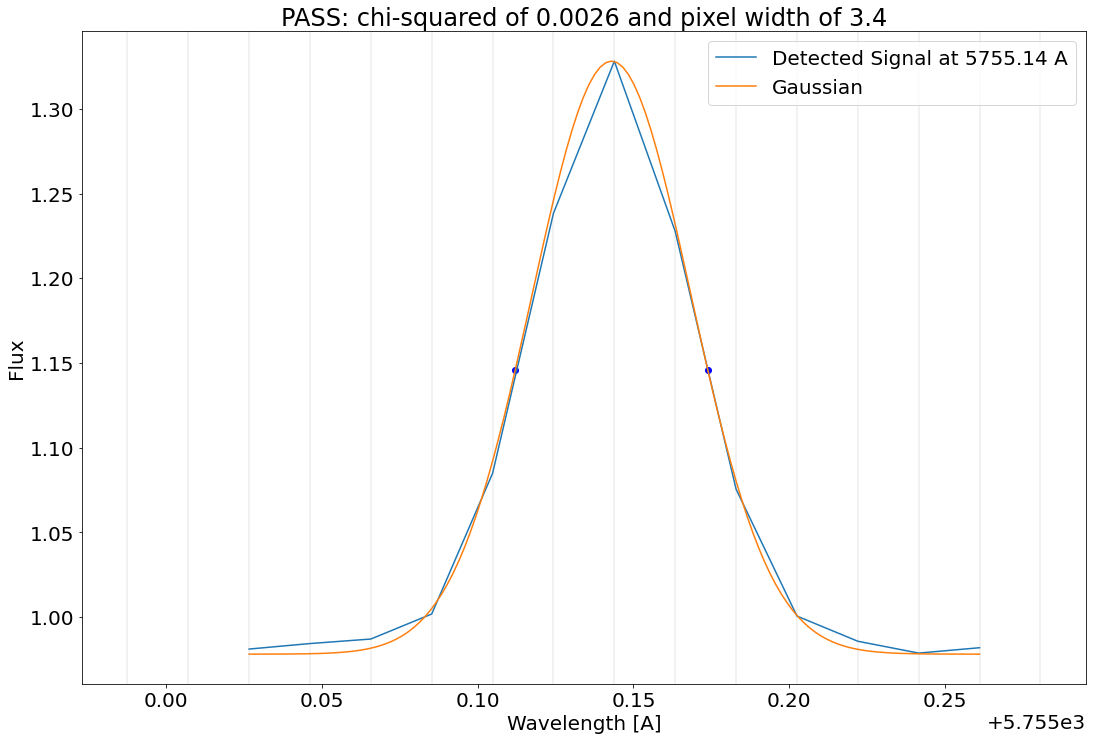

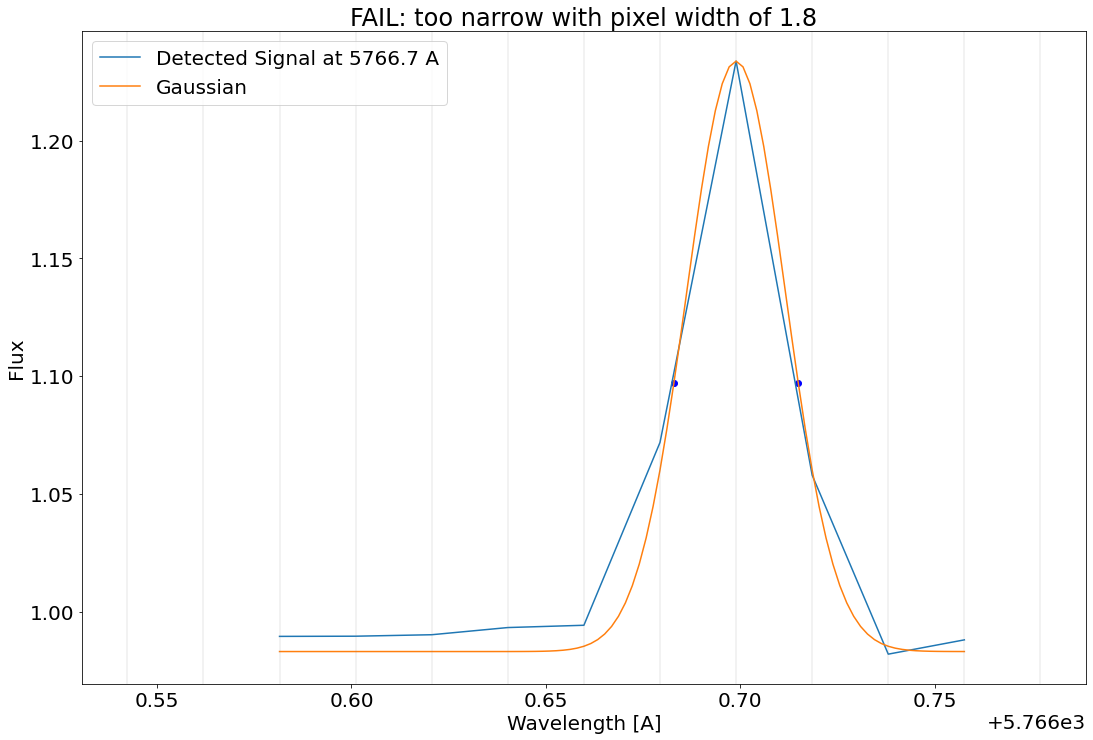

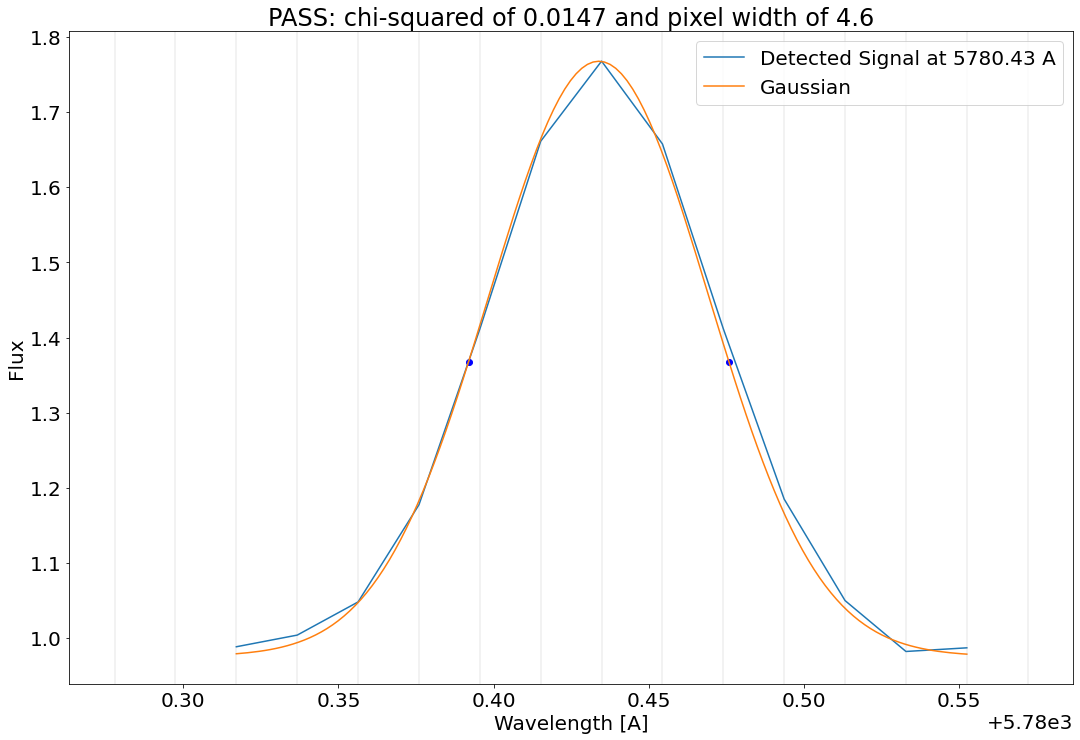

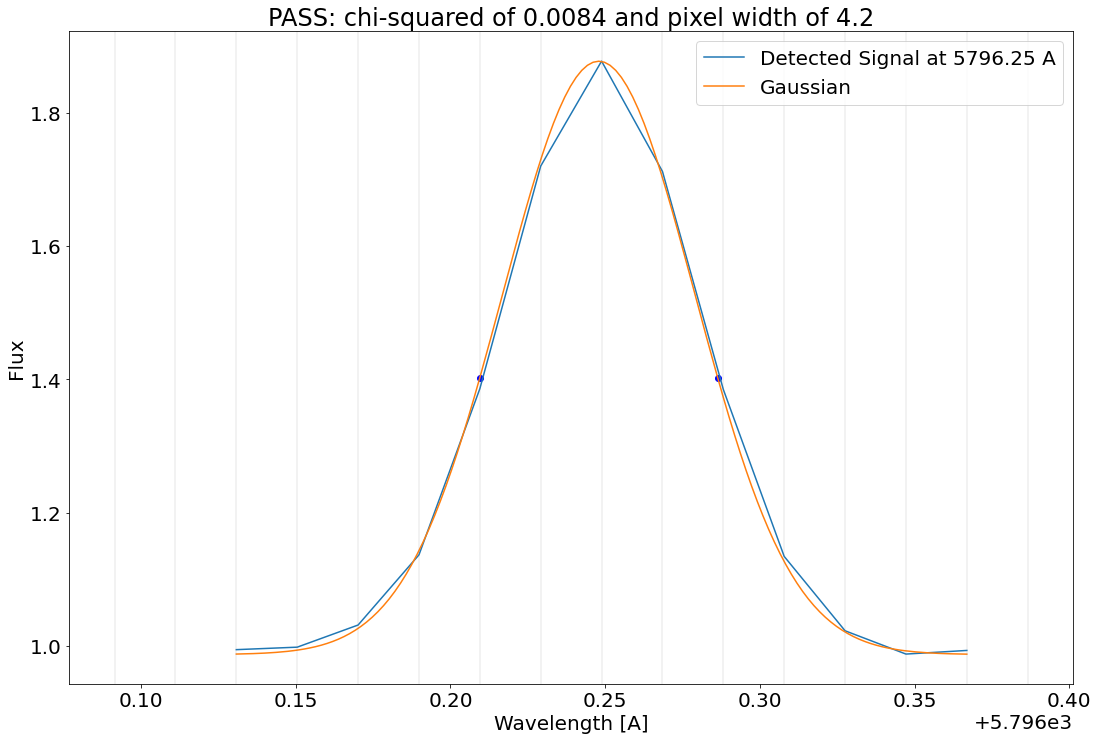

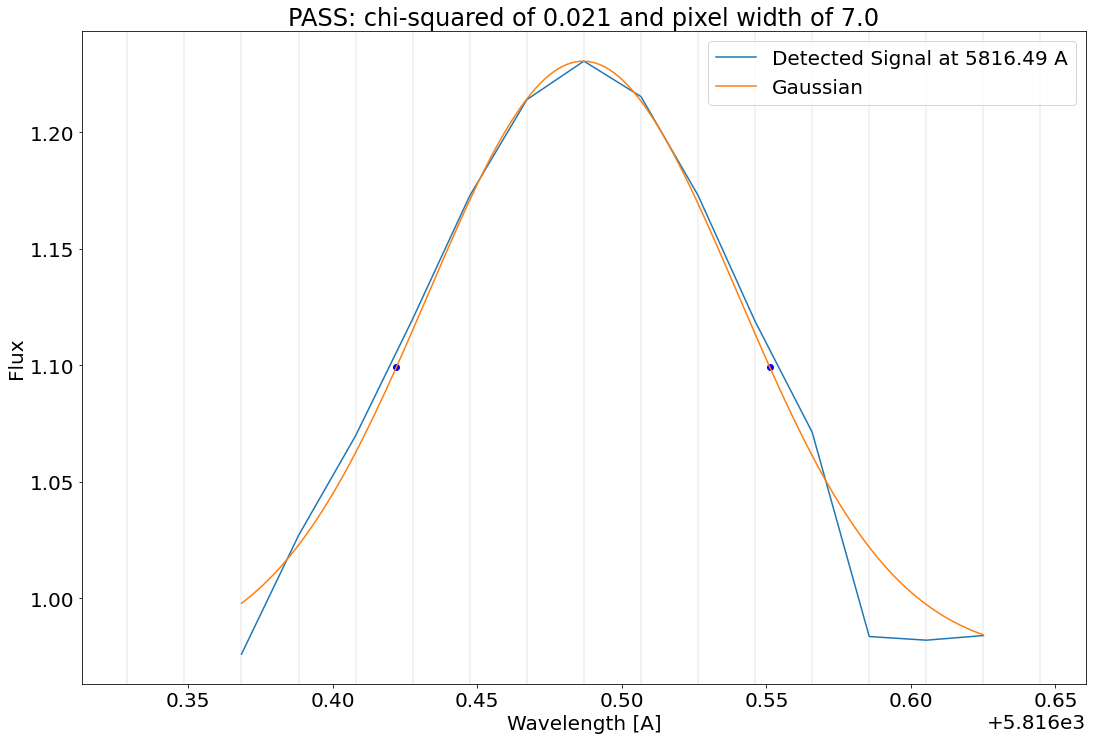

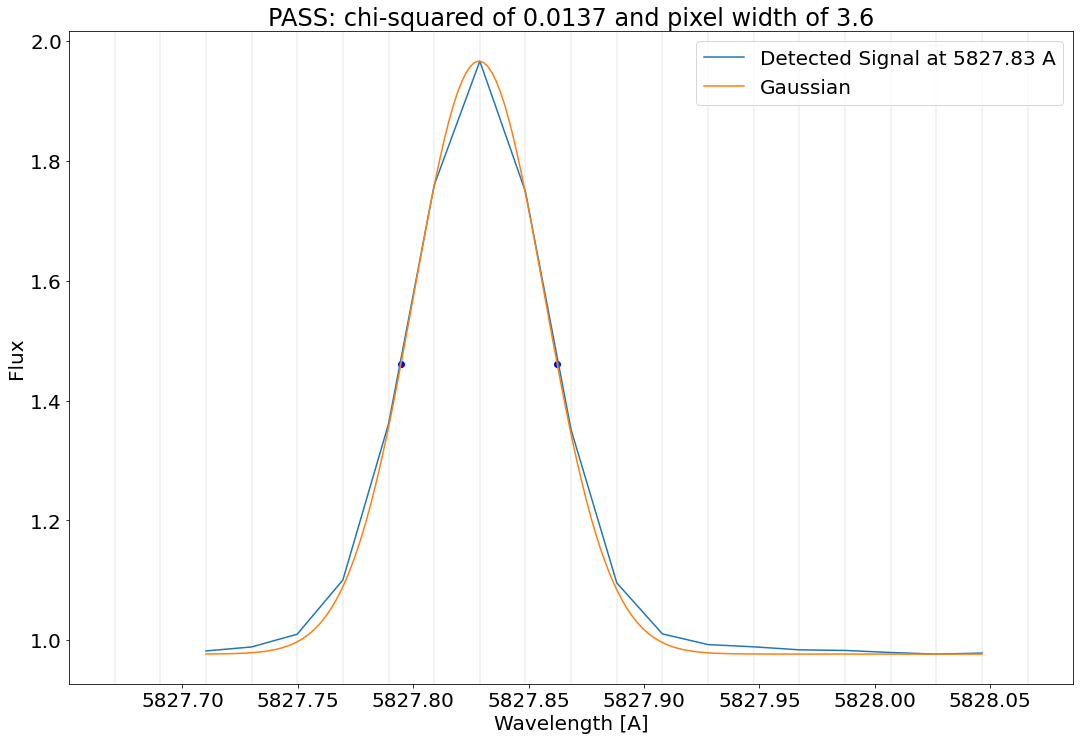

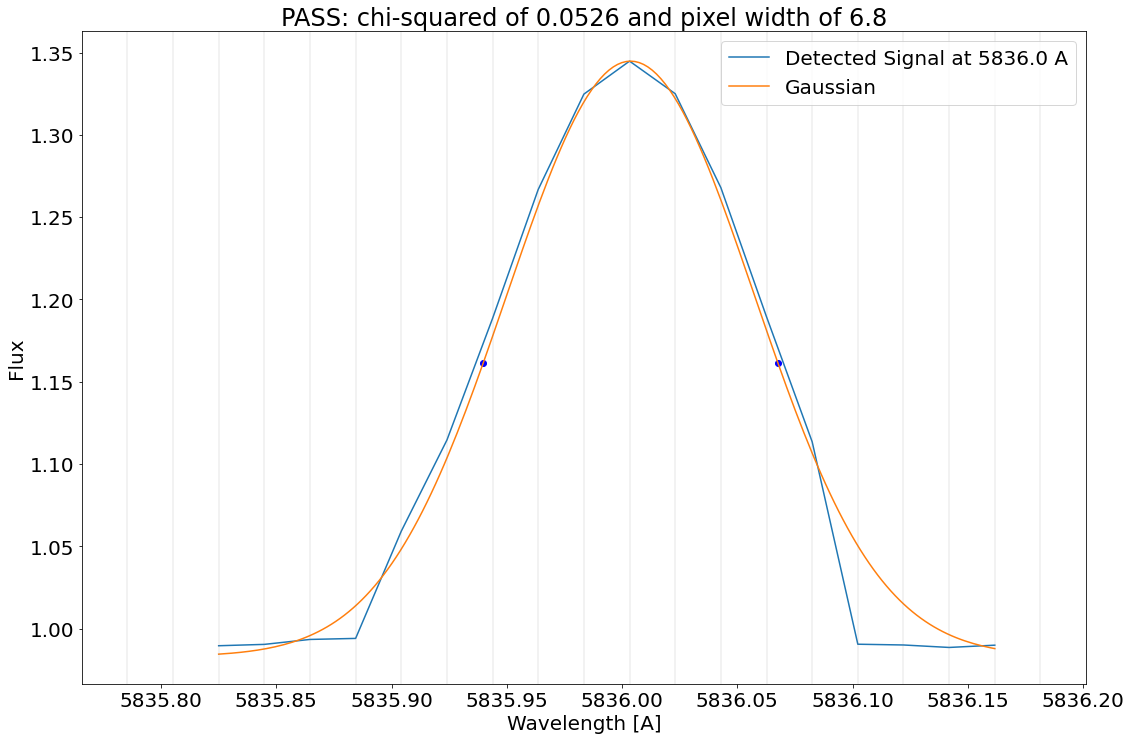

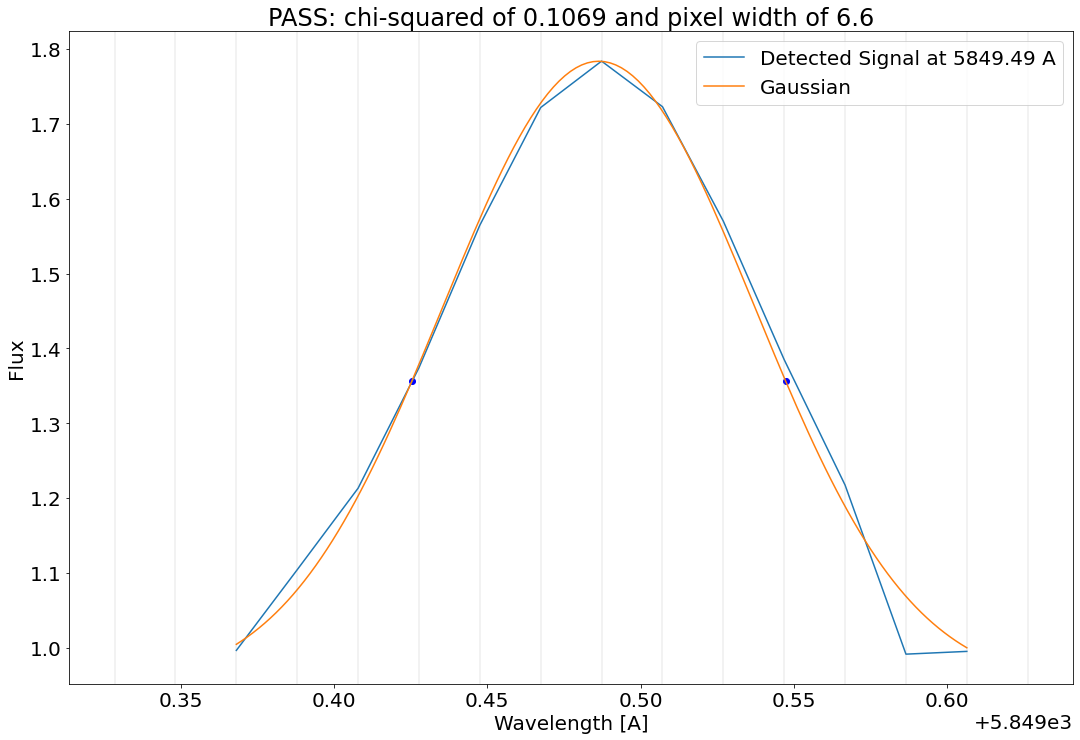

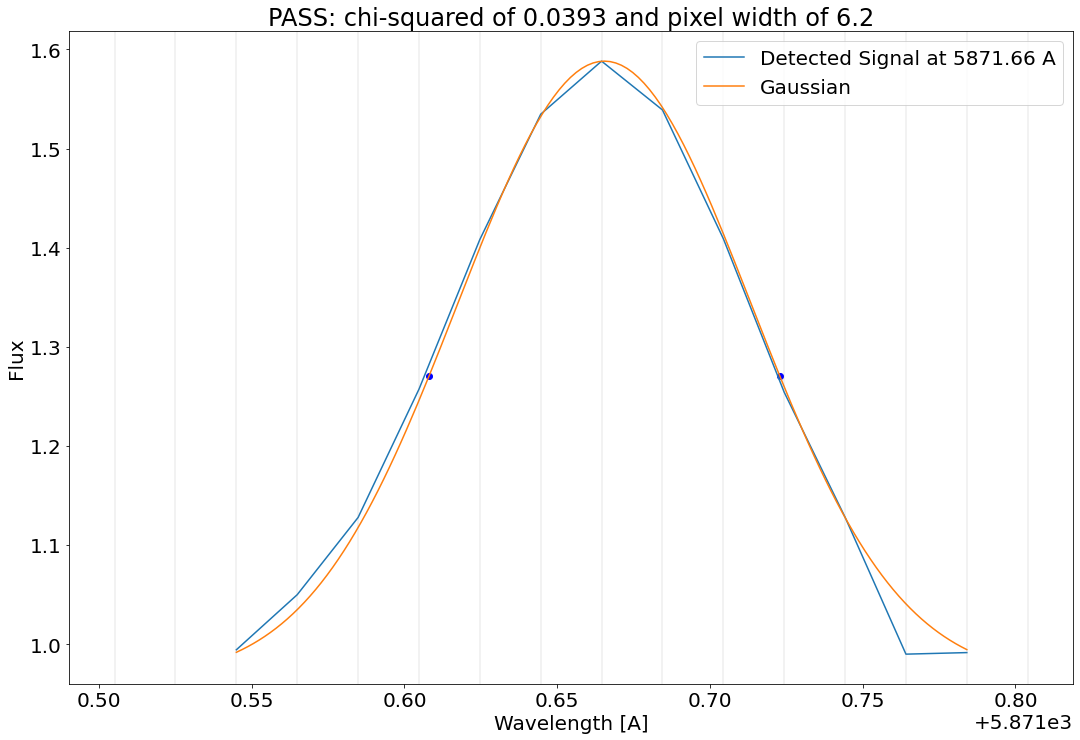

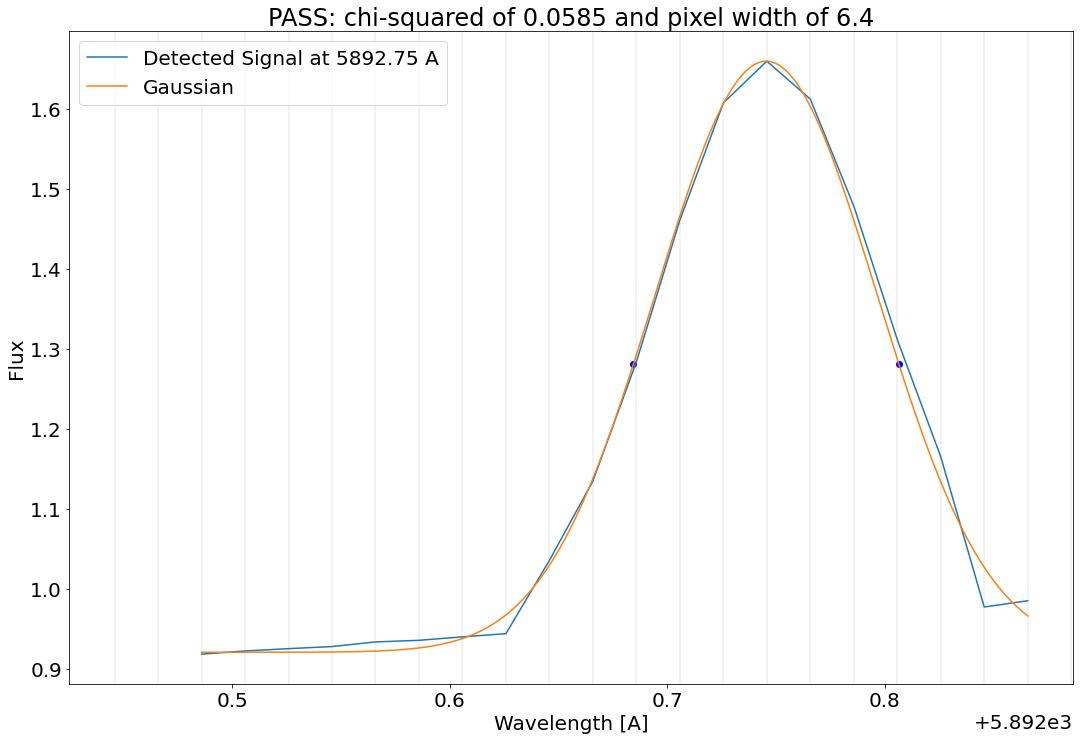

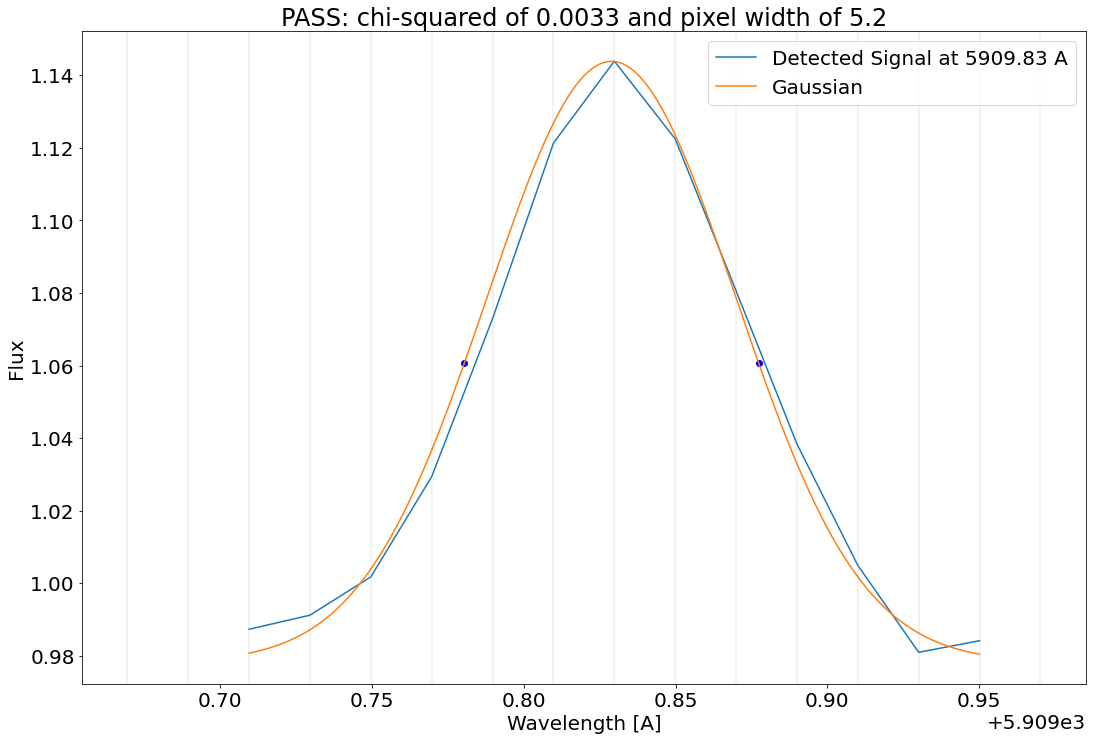

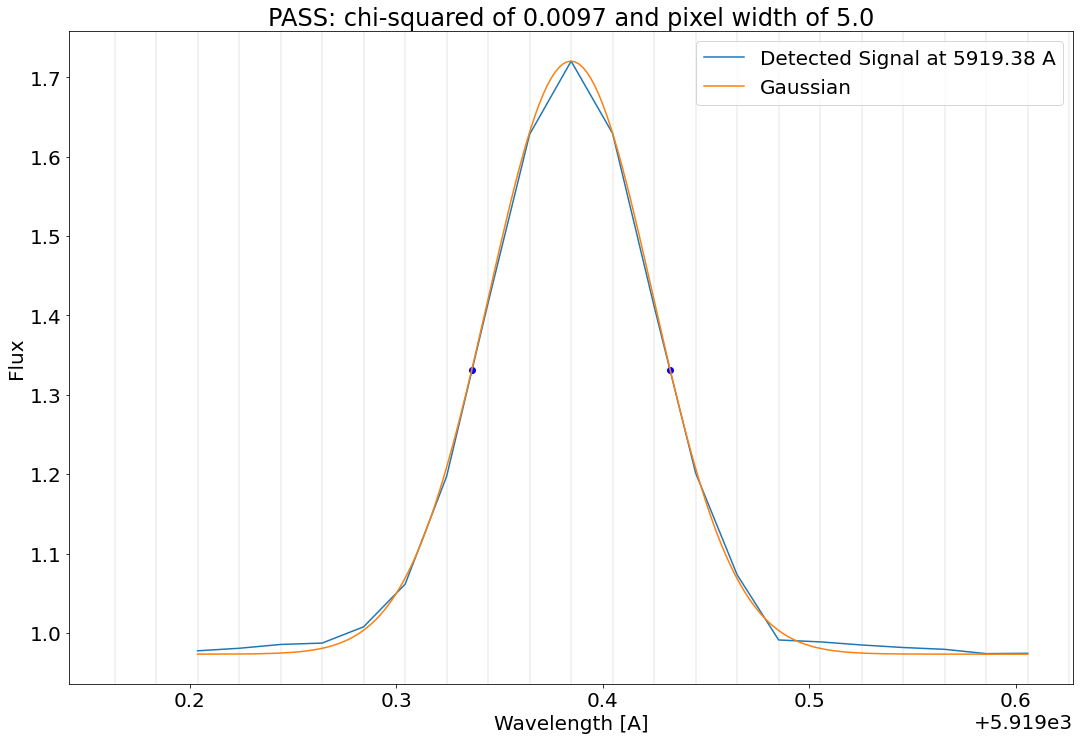

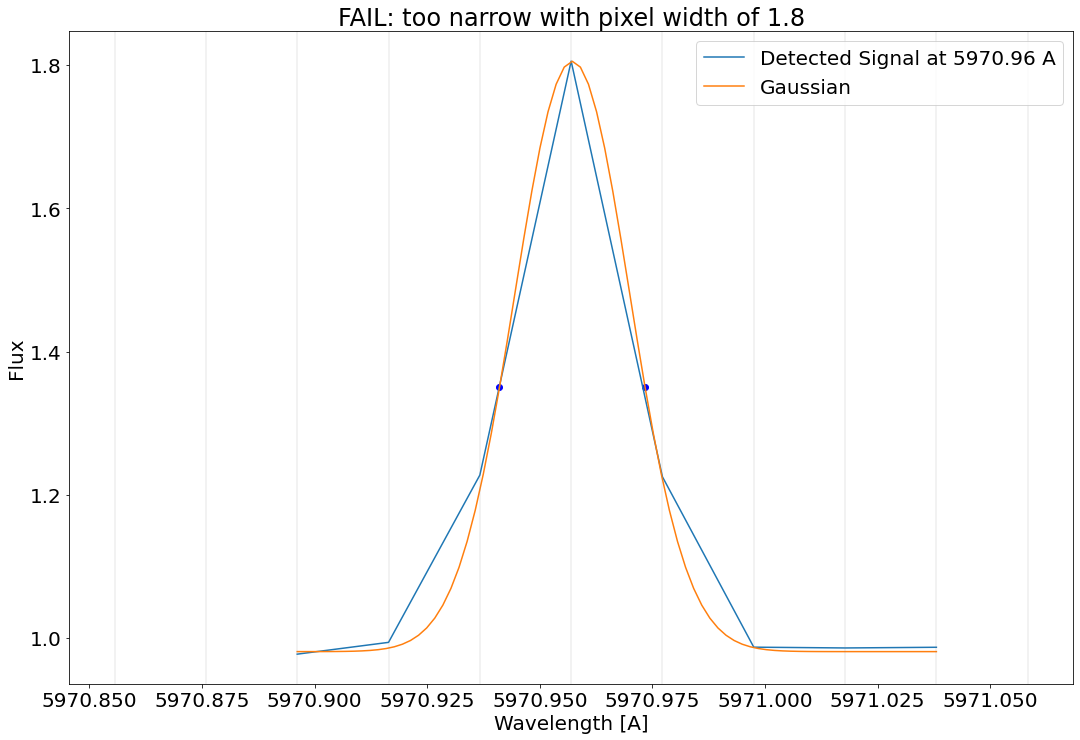

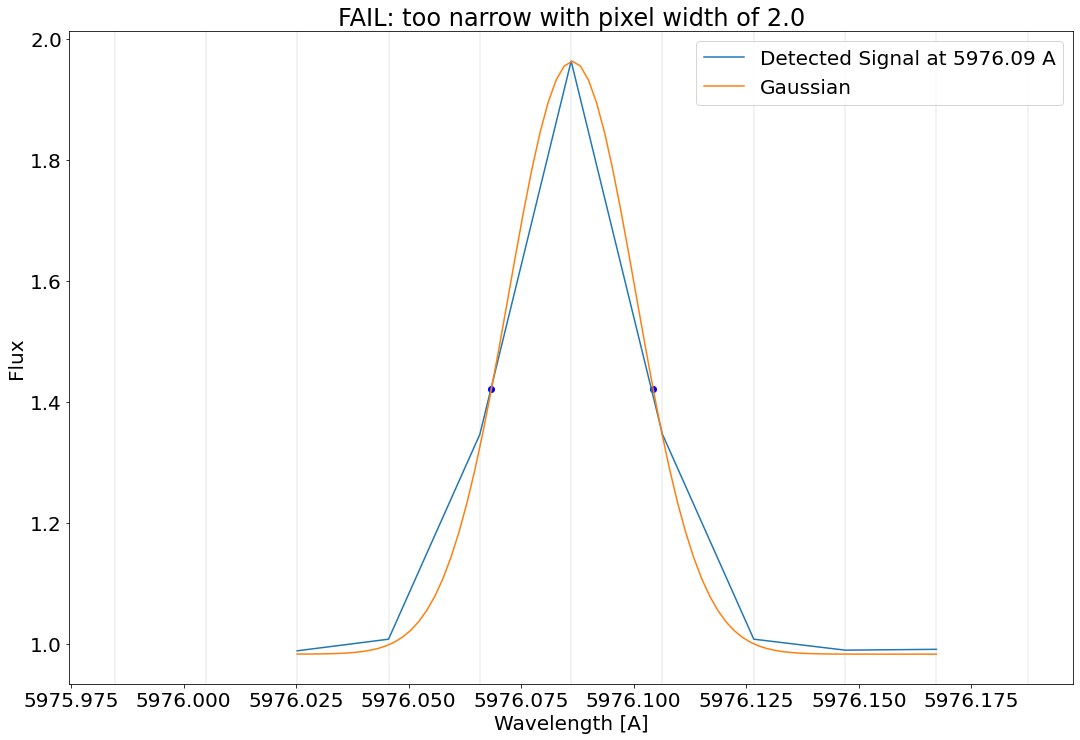

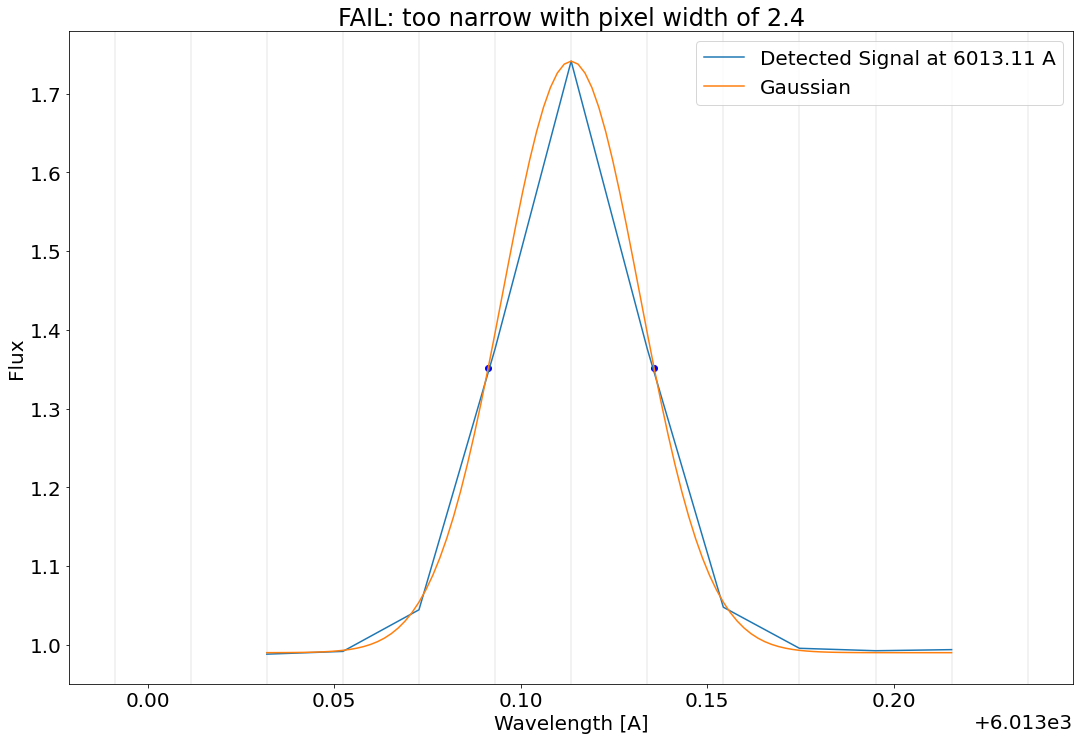

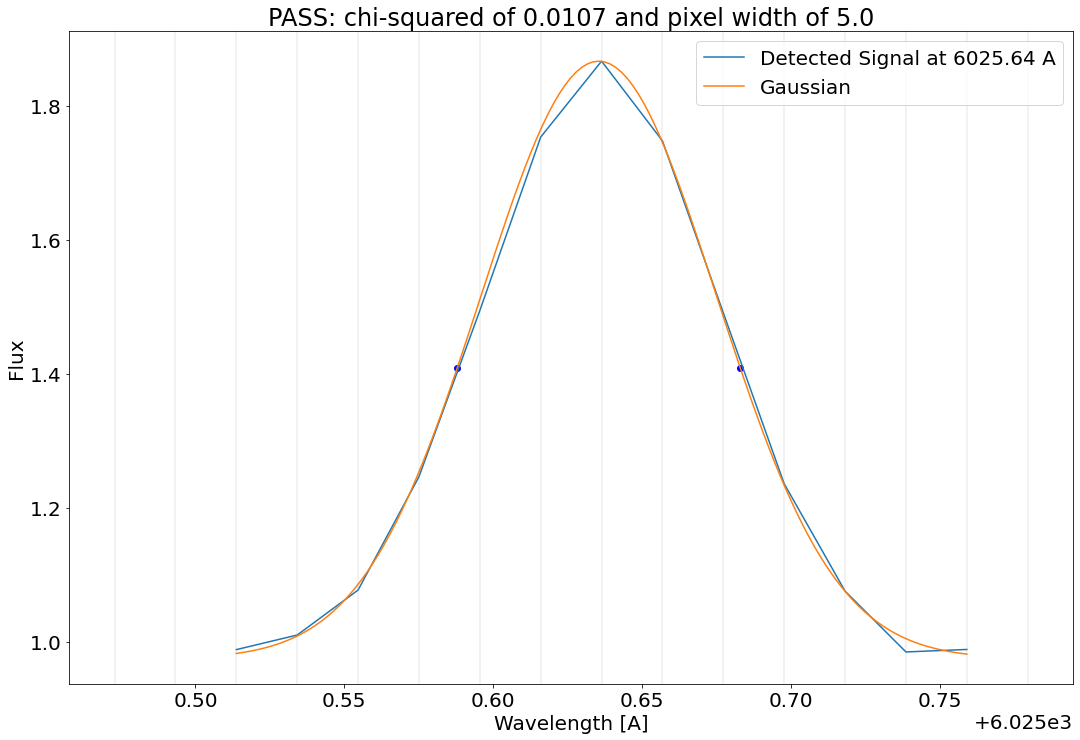

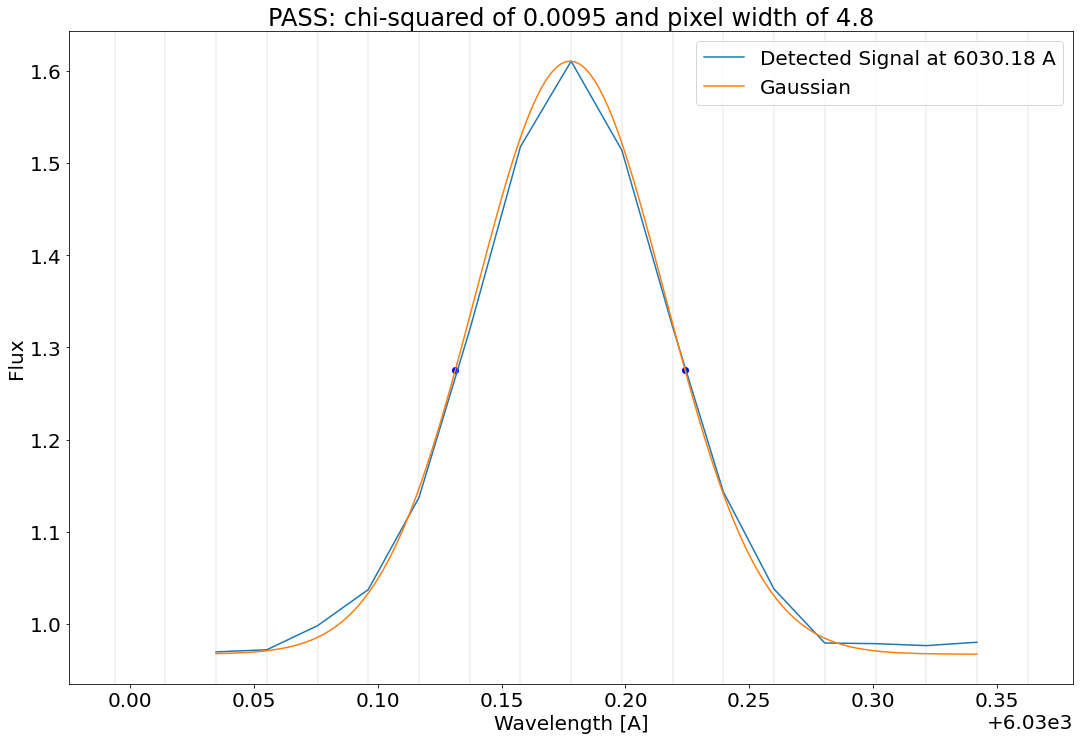

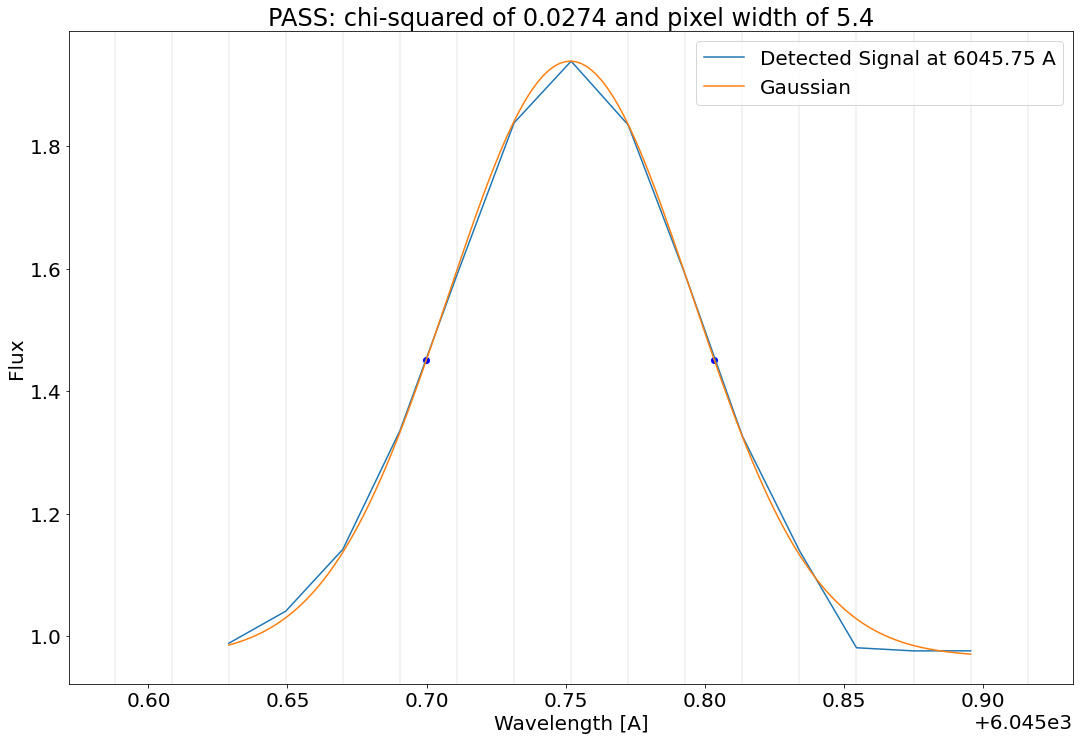

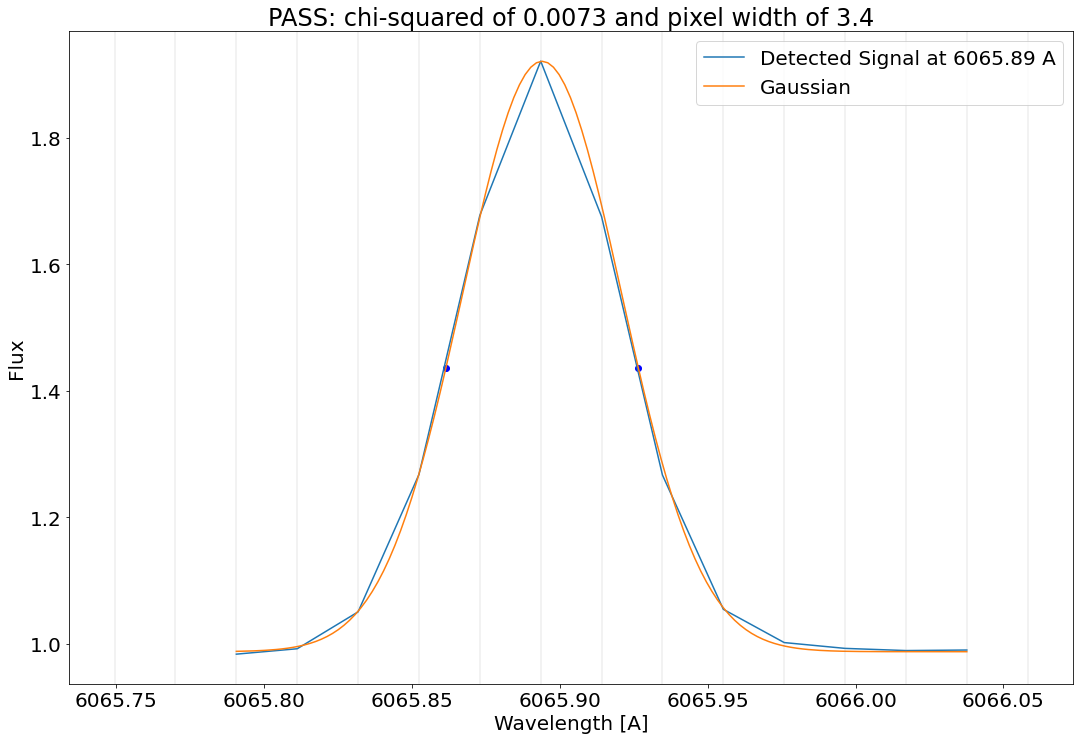

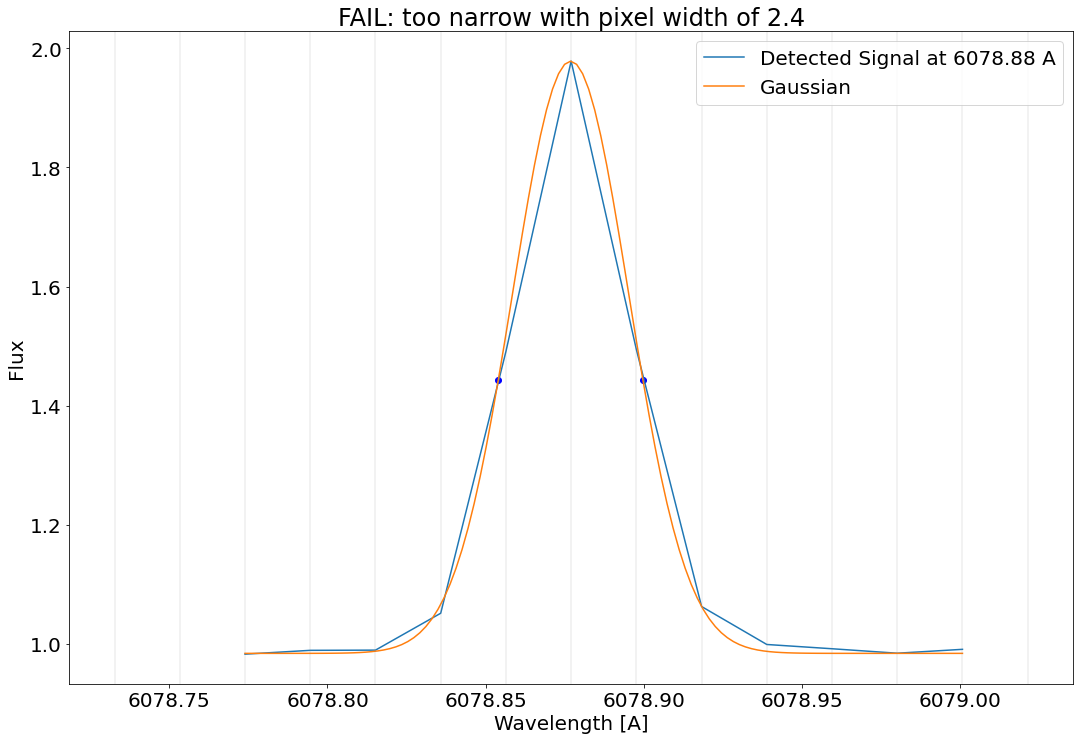

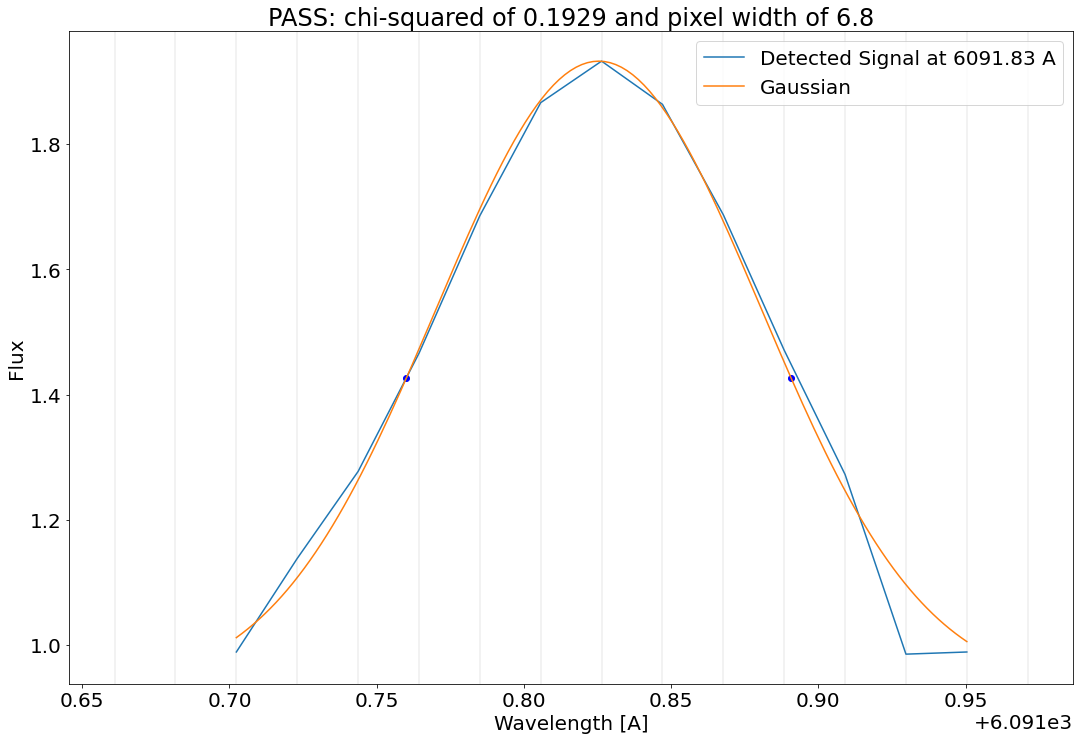

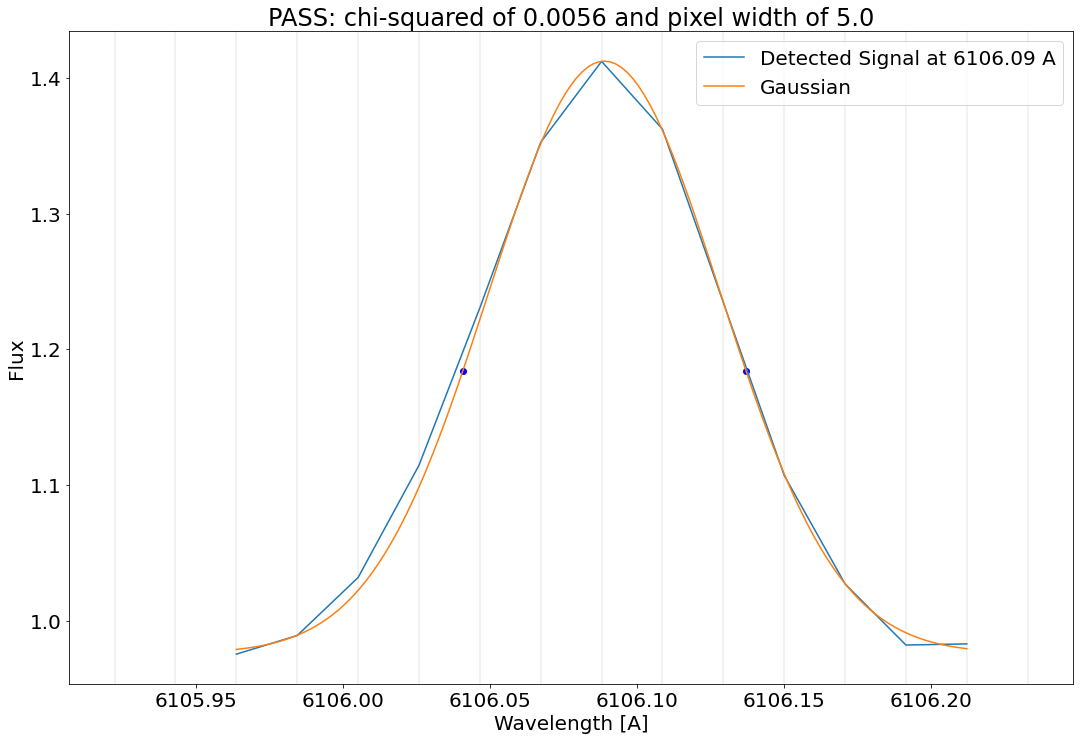

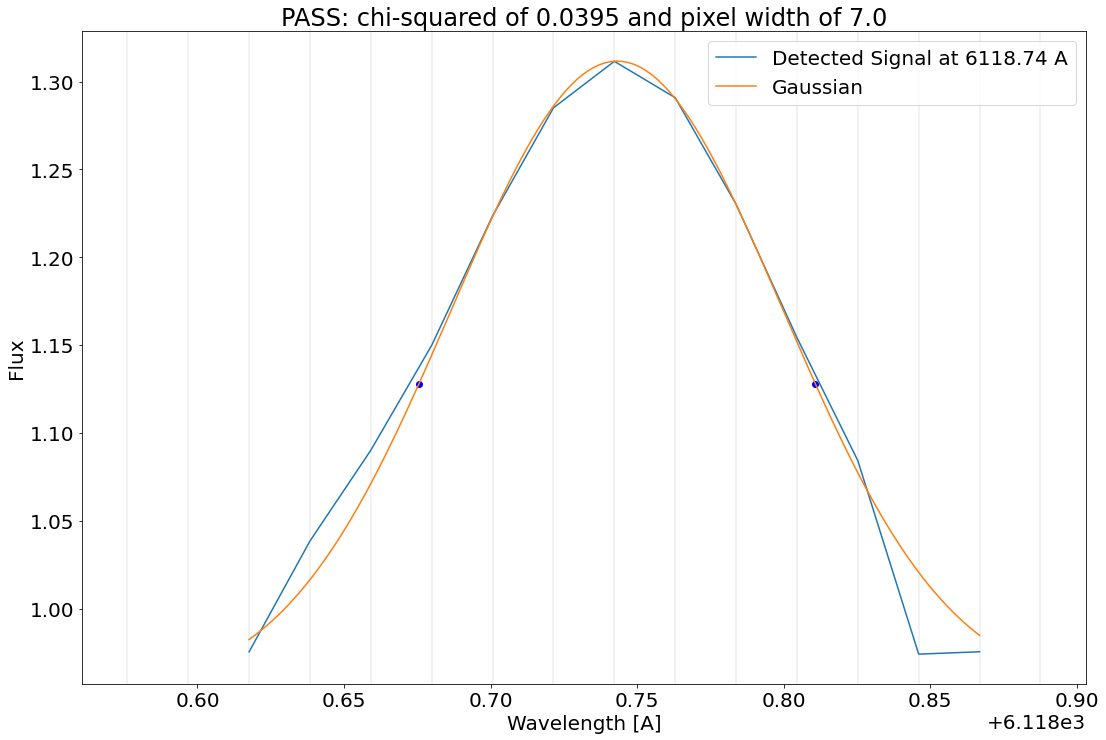

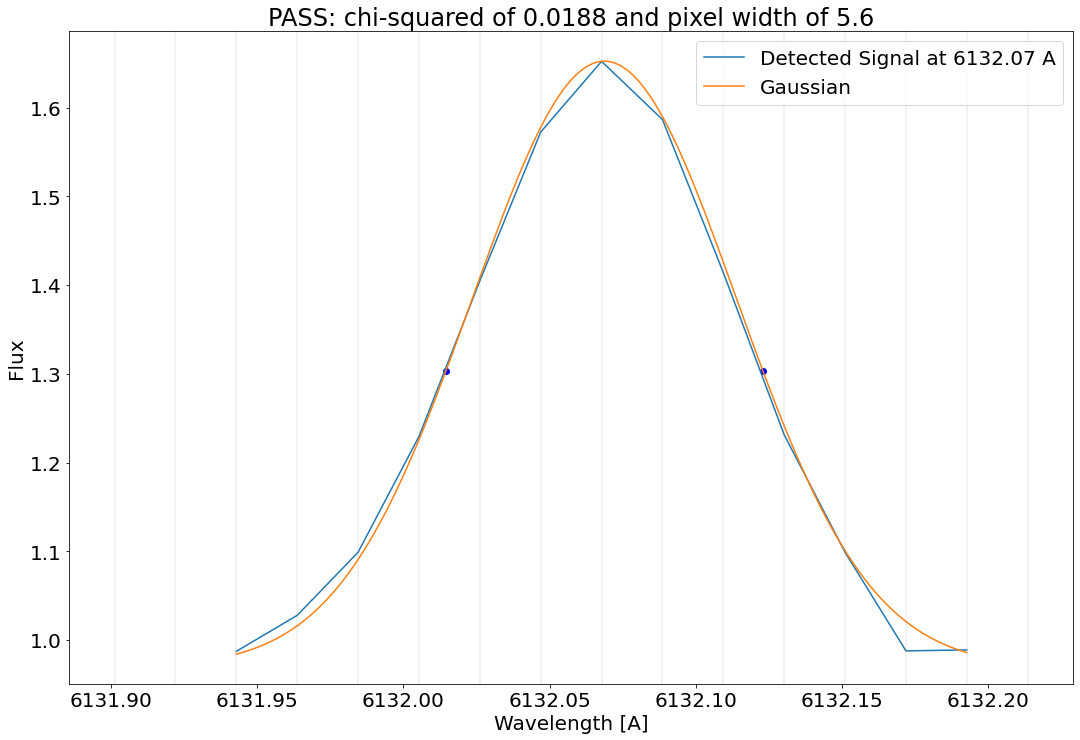

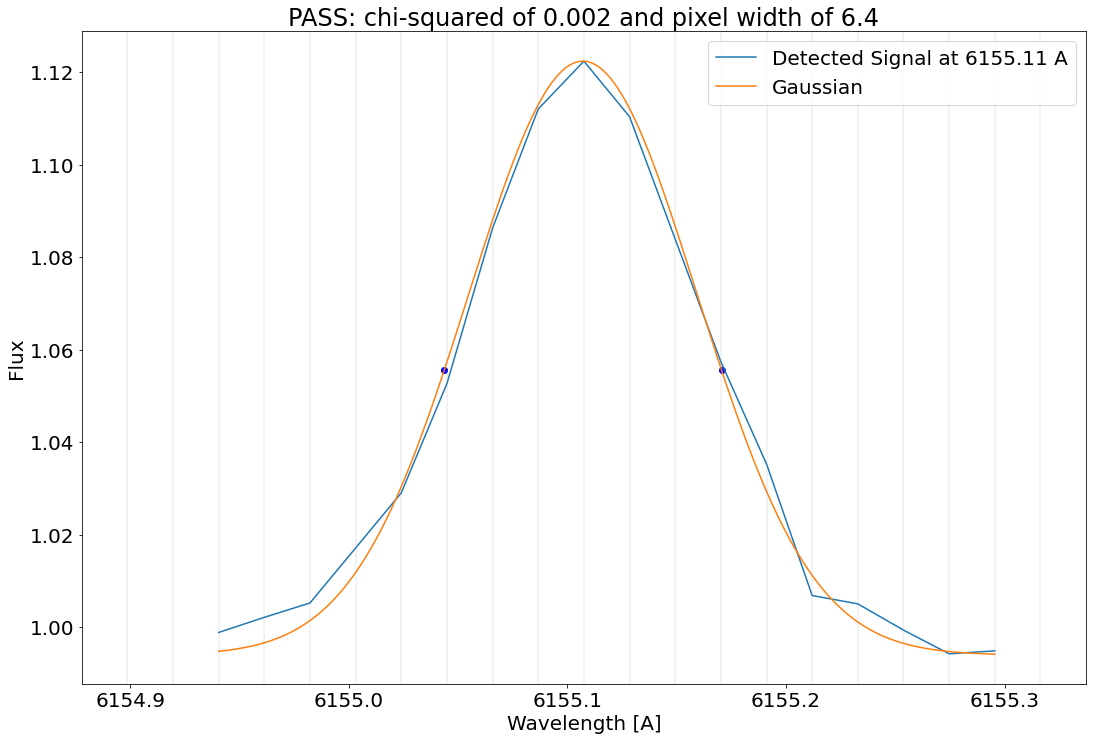

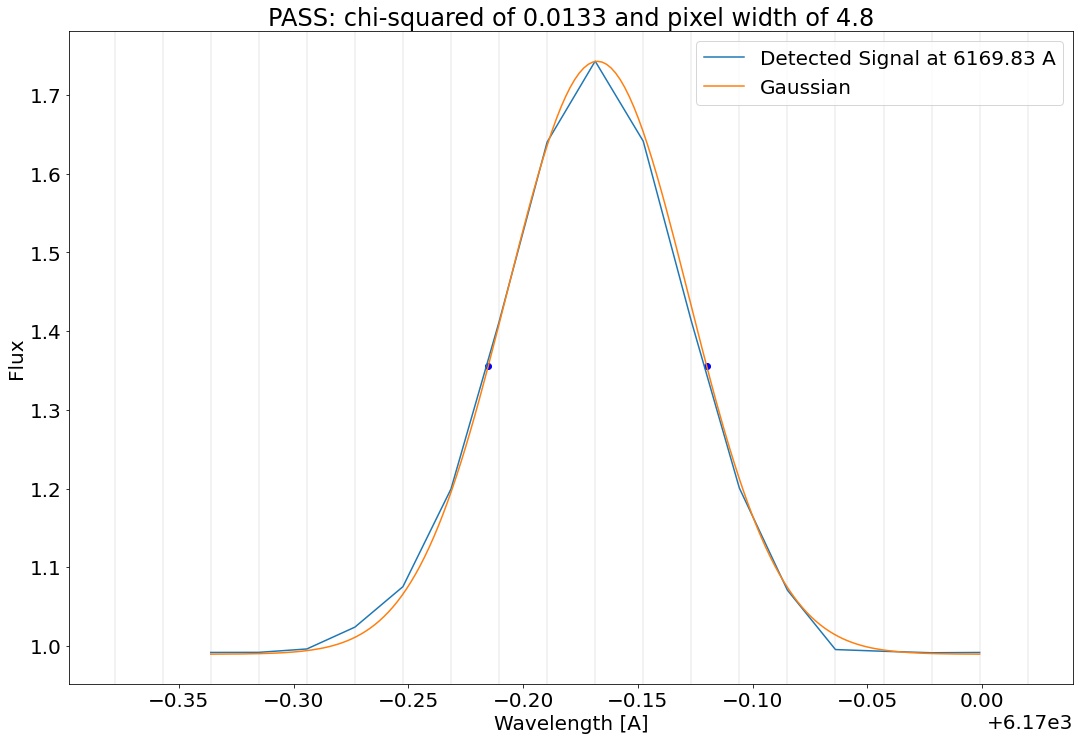

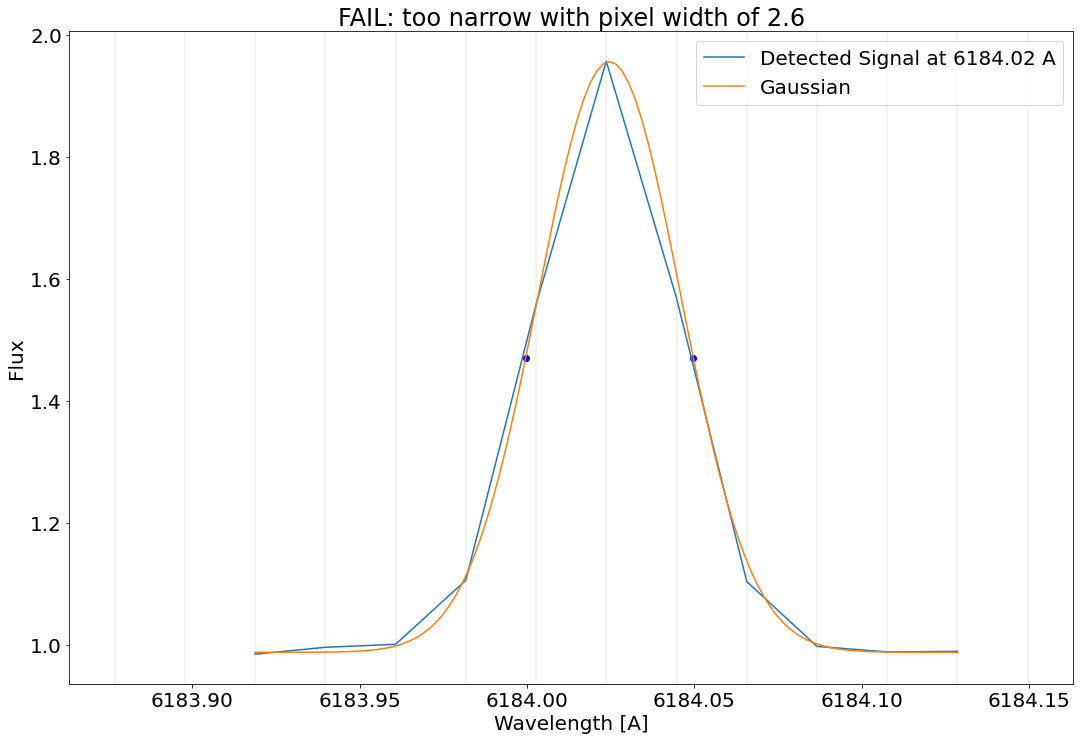

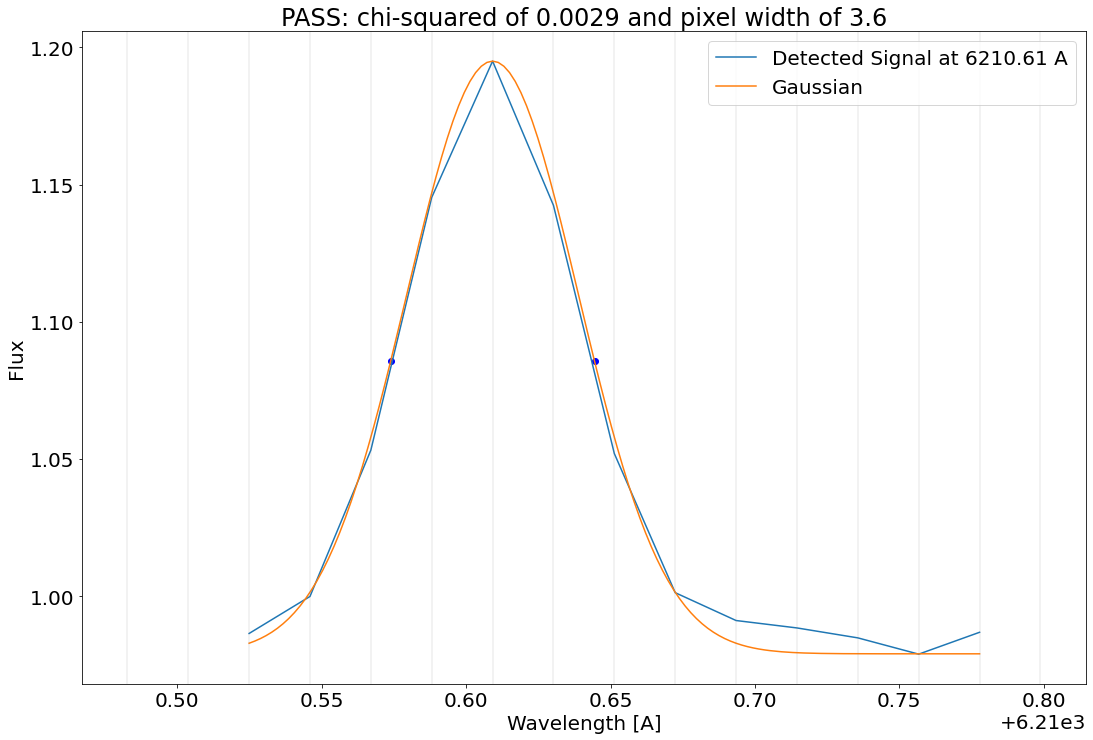

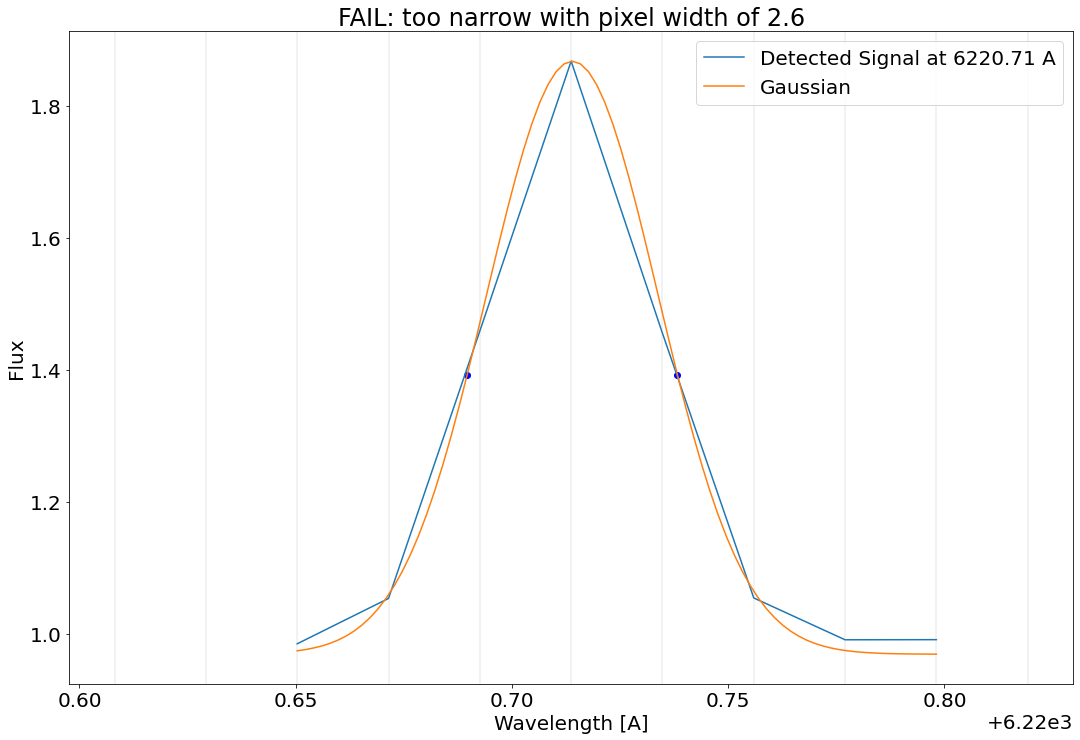

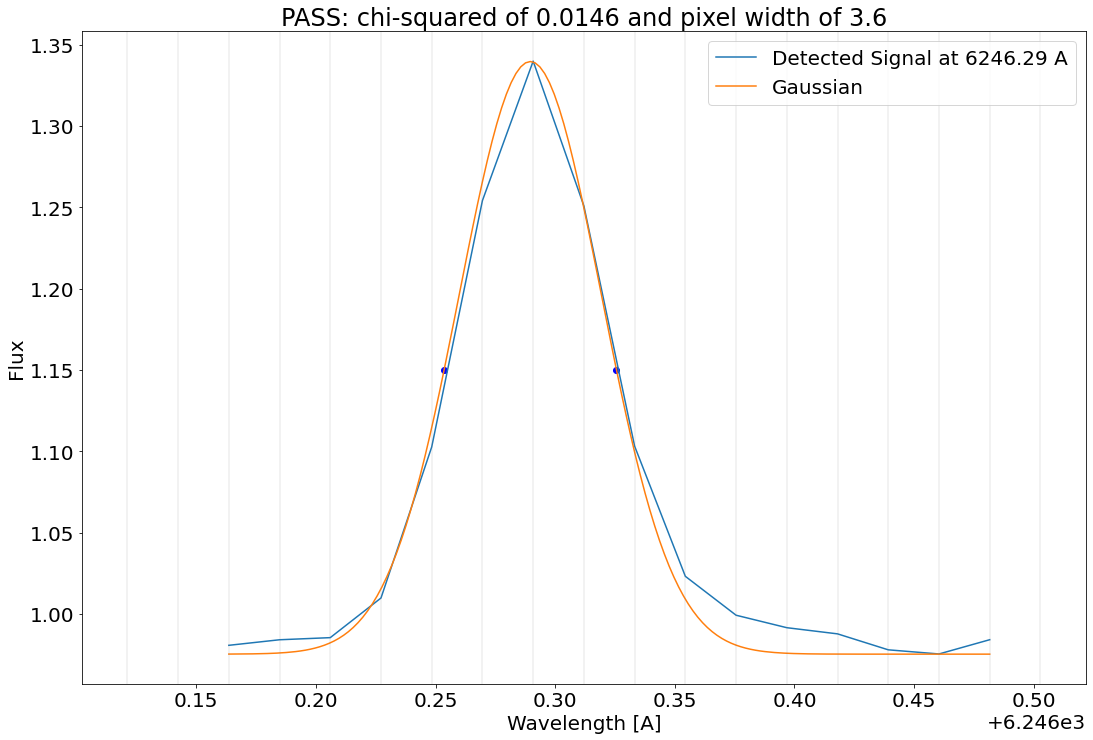

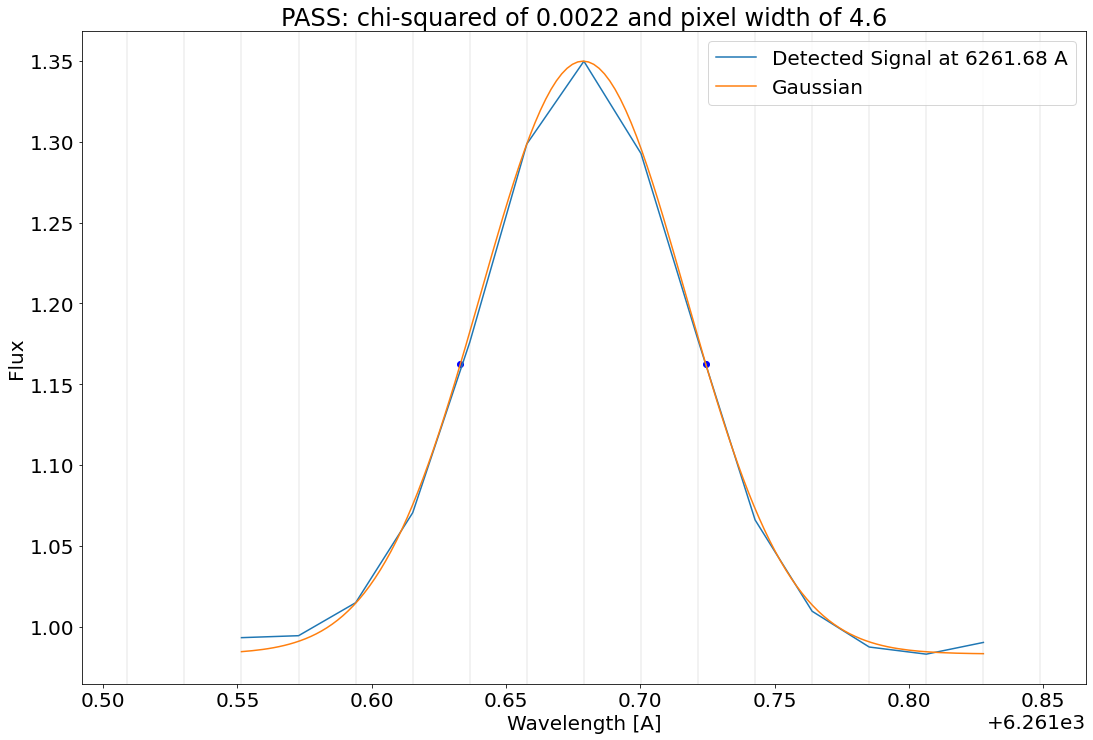

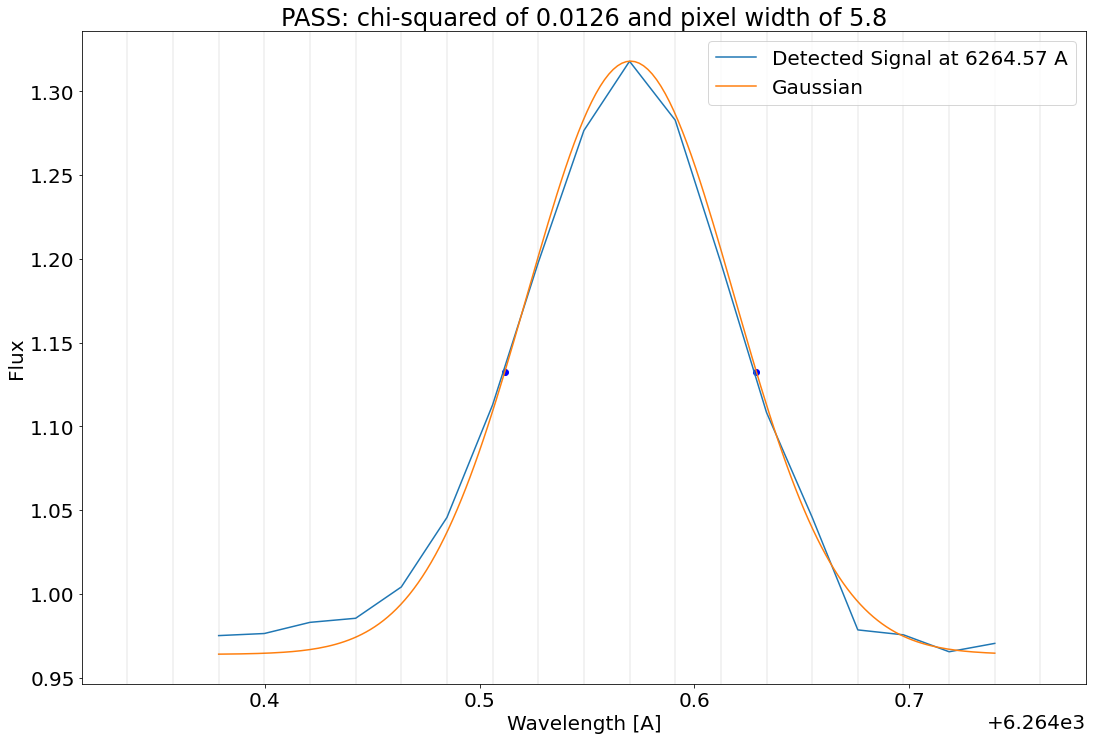

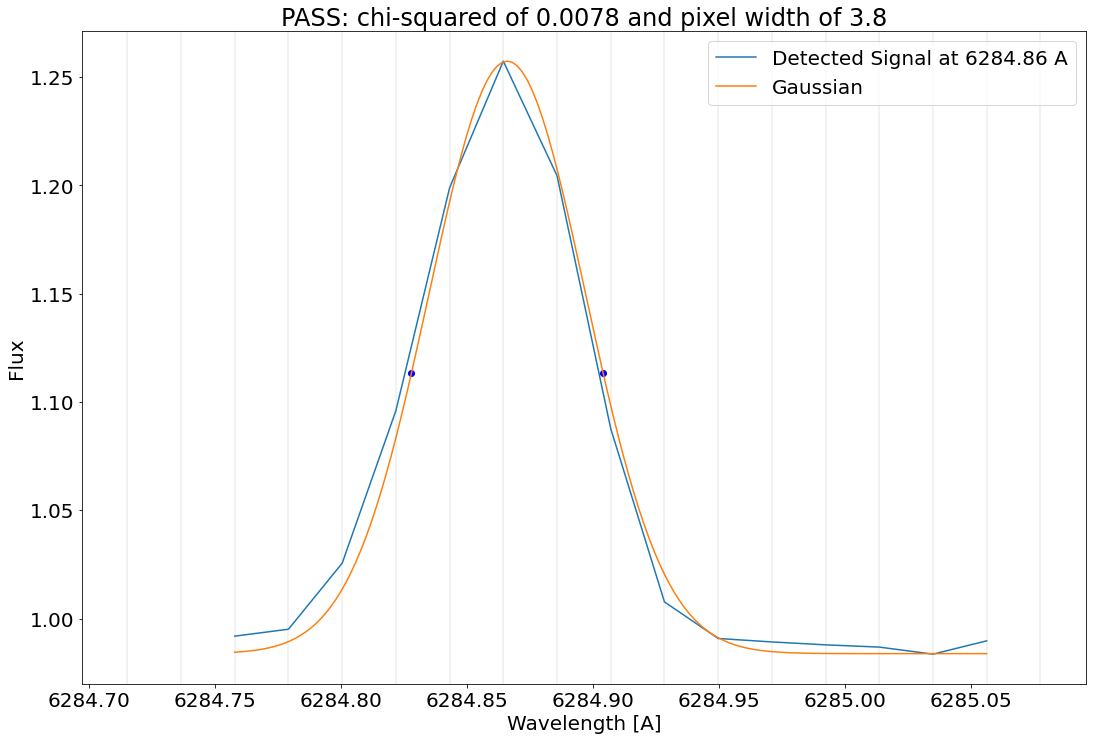

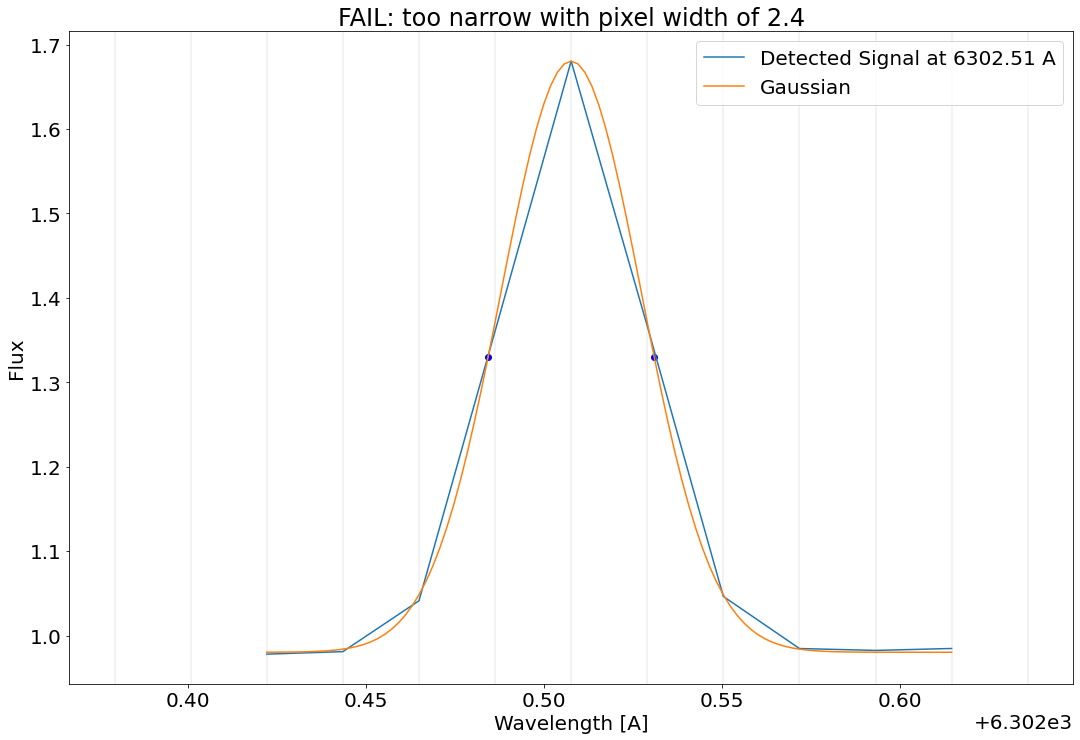

In [1793]:
for idx in idxs2:
    # fit a gaussian to the peak, see if the width is greater than or equal to 2 pixels
    # see how much signal resembles a gaussian
    # if last test is commented out, ALSO check FWHM of gaussian
    
    
#     # METHOD 1 FOR DETERMINING EDGES OF SIGNAL: mark edge when flux falls below median
#     # PRO: can deal with noise in signal
#     # CON: can't identify two signals together
#     temp_ind = idx
#     left_bound = 0
#     while temp_ind > 0:
#         temp_ind -= 1
#         if spect[temp_ind] < median:
#             left_bound = temp_ind
#             break
#     temp_ind = idx
#     right_bound = len(spect) - 1
#     while temp_ind < len(spect) - 1:
#         temp_ind += 1
#         if spect[temp_ind] < median:
#             right_bound = temp_ind
#             break
            
    # METHOD 2 FOR DETERMINING EDGES OF SIGNAL: mark edge when flux reaches a local minimum
    # PRO: can identify two signals together
    # CON: can't deal with noise in signal
    

    
    
    
    
    temp_ind = idx
    left_bound = 0
    while temp_ind > 1:
        temp_ind -= 1
        if spect[temp_ind] < spect[temp_ind - 1] and spect[temp_ind] < spect[temp_ind + 1]:
            left_bound = temp_ind
            break
    temp_ind = idx
    right_bound = len(spect) - 1
    while temp_ind < len(spect) - 4:
        temp_ind += 1
        if (spect[temp_ind] < spect[temp_ind - 1]) and (spect[temp_ind] < spect[temp_ind + 1]):
            right_bound = temp_ind
            break

    x = wl[left_bound:right_bound + 2]
    y = spect[left_bound:right_bound + 2]
    
    oversampled_x = np.linspace(x[0], x[-1], len(x) * 10)
    spl = splrep(x, y)
    oversampled_y = splev(oversampled_x, spl)
    
    
    
    max_y = max(oversampled_y)
    min_y = np.percentile(oversampled_y, 3) 
    height = max_y - min_y
    ind = oversampled_y.tolist().index(max_y)
    pos = oversampled_x[ind]
    min_width = 0.00001
    max_width = oversampled_x[len(oversampled_x) - 1] - oversampled_x[0]
    width_spacing = 0.001

    chi_squared_values = []
    width_vals = np.arange(min_width, max_width, width_spacing)
    for w in width_vals:
        gaus = gaussian(oversampled_x, height, pos, w, min_y)
        chi_squared = chi(gaus, oversampled_y)
        chi_squared_values = np.append(chi_squared_values, chi_squared)
    min_chi_squared = min(chi_squared_values)
    ind_of_min_chisquared = chi_squared_values.tolist().index(min_chi_squared)
    width = width_vals[ind_of_min_chisquared]
    gaus = gaussian(oversampled_x, height, pos, width, min_y)
    
    width_threshold = False
    gauss_threshold = False
    
#     plt.plot(x, y)
#     plt.plot(oversampled_x, oversampled_y)
#     plt.plot(oversampled_x, gaus)

    
    # find the width of the gaussian in pixels
    
    peak = max(gaus)
    half_max = peak - height / 2
    
    peak_index = gaus.tolist().index(peak)
    temp_left_bound = peak_index
    temp_right_bound = peak_index

    
    while gaus[temp_left_bound] > half_max and temp_left_bound > 0:
        temp_left_bound -=1
        
    while gaus[temp_right_bound] > half_max and temp_right_bound < len(gaus) - 1:
        temp_right_bound += 1
    
    pixel_width = (temp_right_bound - temp_left_bound) / 10
    
#     if plot == True or save_figs == True:
#         fig = plt.figure()
#         plt.plot(x, y, label = 'Detected Signal at ' + str(round(wl[idx], 2)) + ' A')
# #         plt.plot(oversampled_x, oversampled_y, label = 'Oversampled Signal')
#         plt.plot(oversampled_x, gaus, label = 'Gaussian')
#         plt.scatter(oversampled_x[temp_left_bound], gaus[temp_left_bound])
#         plt.scatter(oversampled_x[temp_right_bound], gaus[temp_right_bound])
#         plt.title('Gaussian Fit with pixel width of ' + str(pixel_width))
#         plt.xlabel('Wavelength [A]')
#         plt.xlim(wl[left_bound - 2], wl[right_bound + 2])
#         plt.ylabel('Flux')
#         plt.xticks(np.arange(wl[left_bound - 1], wl[right_bound + 1]))
#         plt.grid(which = 'both')
#         for ind in np.arange(left_bound, right_bound):
#             plt.axvline(x=wl[ind], color='gray', linestyle='-', linewidth=0.2)
#         plt.legend()
#         plt.show()
    
    if pixel_width > 3:
        width_threshold = True
        idxs3 = idxs3 + [idx]
        
        if min_chi_squared < 11:
            gauss_threshold = True
            idxs4 = idxs4 + [idx]
    
    
    if plot == True or save_figs == True:
        fig = plt.figure()
        plt.plot(x, y, label = 'Detected Signal at ' + str(round(wl[idx], 2)) + ' A')
        plt.plot(oversampled_x, gaus, label = 'Gaussian')
        plt.scatter(oversampled_x[temp_left_bound], gaus[temp_left_bound], color = 'blue')
        plt.scatter(oversampled_x[temp_right_bound], gaus[temp_right_bound], color = 'blue')
        if gauss_threshold == True:
            # passed width threshold AND gaussian threshold
            plt.title('PASS: chi-squared of ' + str(round(min_chi_squared, 4)) + ' and pixel width of ' + str(pixel_width))
        elif gauss_fit == False:
            # failed gaussian threshold
            plt.title('FAIL: not gaussian-shaped: chi-squared of ' + str(round(min_chi_squared, 4)))
        else:
            # failed width threshold
            plt.title('FAIL: too narrow with pixel width of ' + str(pixel_width))
        plt.xlabel('Wavelength [A]')
        plt.ylabel('Flux')
        for ind in np.arange(left_bound - 2, right_bound + 3):
            plt.axvline(x=wl[ind], color='gray', linestyle='-', linewidth=0.2)
        plt.legend()
        if plot == True:
            plt.show()
        if save_figs == True:
            test4_path = path + '/test4'
            if not (os.path.isdir(test4_path)):
                os.mkdir(test4_path)
            pos_path = test4_path + '/pass'
            neg_path = test4_path + '/fail'
            if not (os.path.isdir(pos_path) and os.path.isdir(neg_path)):
                os.mkdir(pos_path)
                os.mkdir(neg_path)
            if passed:
                fig.savefig(pos_path + '/test4' + '_' + str(round(wl[idx])) + '.png')
            else:
                fig.savefig(neg_path + '/test4' + '_' + str(round(wl[idx])) + '.png')
                
        

In [1717]:
detected_indicies = []
recovered_indicies = []

In [1718]:
if threshold_testing == True:               
    for idx in idxs4:    
        absolute_difference_function = lambda list_value : abs(list_value - idx)
        i = min(indicies.tolist(), key = absolute_difference_function)
        index = indicies.tolist().index(i)
        if abs(idx - indicies[index]) < 4 and (indicies[index] not in recovered_indicies):
            recovered_widths = np.append(recovered_widths, widths[index])
            recovered_heights = np.append(recovered_heights, heights[index])
            recovered_indicies = np.append(recovered_indicies, indicies[index])
            recovered_wavelengths = np.append(recovered_wavelengths, wl[index])
#             print(str(idx) + ' recovered')
        else:
#             print(str(idx) + ' not recovered')
            detected_widths = np.append(detected_widths, widths[index])
            detected_heights = np.append(detected_heights, heights[index])
            detected_indicies = np.append(detected_indicies, indicies[index])
            detected_wavelengths = np.append(detected_wavelengths, wl[index])

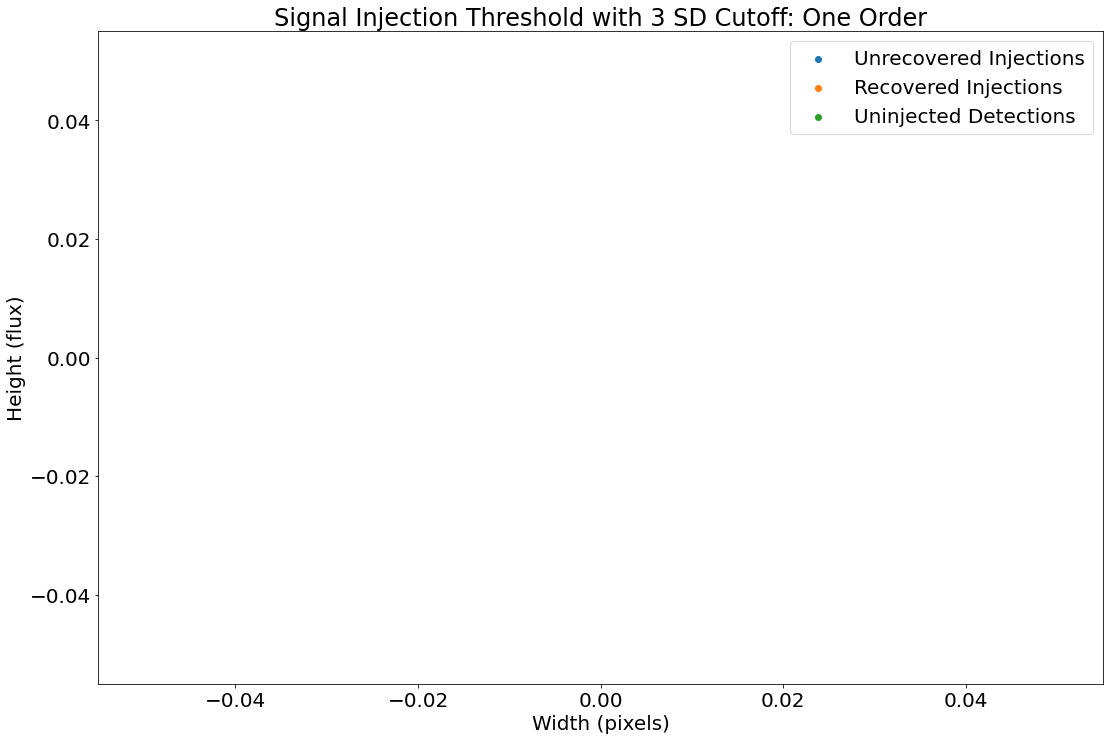

In [1719]:
min_width = 7.5
max_width = 8
min_height = 2.8
max_height = 3.3

if threshold_testing == True and plot == True or save_figs == True:
    fig = plt.figure()
    plt.scatter(widths, heights, label = 'Unrecovered Injections') 
    plt.scatter(recovered_widths, recovered_heights, label = 'Recovered Injections')
    plt.scatter(detected_widths, detected_heights, label = 'Uninjected Detections')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (flux)')
    if only_test_certain_range == True:
        plt.title('Signal Injection Threshold with ' + str(SDs_above_median) + ' SD Cutoff: One Order')
    else:
        plt.title('Signal Injection Threshold with ' + str(SDs_above_median) + ' SD Cutoff from Local Median: All Orders')
    plt.legend()
    if plot == True:
#         plt.xlim(min_width, max_width)
#         plt.ylim(min_height, max_height)
        plt.show()
    if save_figs == True:
        threshold_path = path + '/' + star + 'threshold'
        fig.savefig(threshold_path)

In [1662]:
coordinates = list(zip(widths, heights))

i = 0
for coordinate in coordinates:
    width = coordinate[0]
    height = coordinate[1]
    if min_width < width < max_width and min_height < height < max_height:
        index = i
    i += 1
    
print('Wavelength: ' + str(wavelengths[index]))
print('Height: ' + str(heights[index]))
print('Width: ' + str(widths[index]))
print('Location (pixels): ' + str(indicies[index]))

Wavelength: 6320.972680745073
Height: 0.6299999999999997
Width: 3.240000000000002
Location (pixels): 69230.0
